In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from nba_api.stats.endpoints import leaguegamelog, playergamelogs, teamgamelogs
from time import sleep
import time
from filterpy.kalman import KalmanFilter
from typing import Dict, Tuple
from tqdm import tqdm




ModuleNotFoundError: No module named 'autogluon'

In [2]:
pd.options.display.max_columns=None

In [3]:
DB_NAME = 'nba_stats.db'

conn = sqlite3.connect(DB_NAME)
tables = pd.read_sql("""select * from sqlite_master where type='table'""", conn)
conn.close
table_list = tables['name'].tolist()

['traditional_stats',
 'advanced_stats',
 'scoring_stats',
 'defensive_stats',
 'hustle_stats',
 'player_traditional_stats',
 'team_traditional_stats',
 'player_advanced_stats',
 'team_advanced_stats',
 'player_scoring_stats',
 'team_scoring_stats',
 'player_defensive_stats',
 'team_defensive_stats',
 'player_hustle_stats',
 'team_hustle_stats',
 'player_track_stats',
 'team_track_stats',
 'player_misc_stats',
 'team_misc_stats',
 'player_usage_stats',
 'team_usage_stats',
 'player_miscellaneous_stats',
 'team_miscellaneous_stats',
 'team_basic_stats',
 'player_basic_stats',
 'nba_odds',
 'player_info',
 'defensive_stats_by_position',
 'team_basic_stats_by_position',
 'team_advanced_stats_by_position',
 'team_scoring_stats_by_position',
 'player_shot_locations_boxscores',
 'team_base_stats_by_position',
 'team_shot_location_boxscores']

In [8]:
conn=sqlite3.connect(DB_NAME)
pts = pd.read_sql("""select * from player_track_stats""", conn)
phs = pd.read_sql("""select * from player_hustle_stats""", conn)

# tslb = pd.read_sql("""select * from team_shot_location_boxscores""", conn)
# tbs = pd.read_sql("""select * from team_basic_stats""", conn)

In [5]:
tslb[['Date', 'TEAM_ID']]

,Date,TEAM_ID
0,2014-10-29,1610612737
1,2014-10-29,1610612738
2,2014-10-29,1610612751
3,2014-10-29,1610612766
4,2014-10-29,1610612741
...,...,...
25689,2024-06-12,1610612742
25690,2024-06-14,1610612738
25691,2024-06-14,1610612742
25692,2024-06-17,1610612738


In [6]:
tbs[['GAME_DATE', 'TEAM_ID']]

,GAME_DATE,TEAM_ID
0,2015-10-27,1610612737
1,2015-10-27,1610612765
2,2015-10-27,1610612741
3,2015-10-27,1610612744
4,2015-10-27,1610612740
...,...,...
28303,2015-06-11,1610612744
28304,2015-06-14,1610612744
28305,2015-06-14,1610612739
28306,2015-06-16,1610612744


In [11]:
query = """ WITH player_game_stats AS (
    SELECT
        pbs.SEASON_YEAR,
        pbs.PLAYER_ID,
        pbs.PLAYER_NAME,
        pbs.TEAM_ID,
        pbs.TEAM_ABBREVIATION,
        pbs.GAME_ID,
        pbs.GAME_DATE,
        pbs.MATCHUP,
        pbs.WL,
        pbs.MIN,
        pbs.PTS,
        pbs.FGM,
        pbs.FGA,
        pbs.FG3M,
        pbs.FG3A,
        pbs.FTM,
        pbs.FTA,
        pbs.OREB,
        pbs.DREB,
        pbs.REB,
        pbs.AST,
        pbs.TOV,
        pbs.STL,
        pbs.BLK,
        pbs.PLUS_MINUS,
        pas.OFF_RATING,
        pas.DEF_RATING,
        pas.NET_RATING,
        pas.PACE,
        pas.PIE,
        pss.PCT_PTS_2PT_MR,
        pss.PCT_AST_2PM,
        pss.PCT_UAST_2PM,
        pss.PCT_AST_3PM,
        pss.PCT_UAST_3PM,
        phs.offensiveBoxOuts as OFFENSIVE_BOX_OUTS,
        phs.looseBallsRecoveredOffensive as LOOSE_BALLS_RECOVERED_OFFENSIVE,
        pts.DIST,
        pts.SPD,
        pts.TCHS,
        pts.PASS,
        pts.CFGM,
        pts.CFGA,
        pts.UFGM,
        pts.UFGA,
        pts.DFGM,
        pts.DFGA,
        pms.PTS_OFF_TOV,
        pms.PTS_2ND_CHANCE,
        pms.PTS_FB,
        pms.PTS_PAINT,
        pms.OPP_PTS_OFF_TOV,
        pms.OPP_PTS_2ND_CHANCE,
        pms.OPP_PTS_FB,
        pms.OPP_PTS_PAINT,
        pms.BLK as BLOCKS,
        pms.BLKA as BLOCKED_ATT,
        pms.PF,
        pms.PFD,
        pslb.[Restricted Area FGM] as FGM_RESTRICTED,
        pslb.[Restricted Area FGA] as FGA_RESTRICTED,
        pslb.[In The Paint (Non-RA) FGM] as FGM_PAINT_NON_RA,
        pslb.[In The Paint (Non-RA) FGA] as FGA_PAINT_NON_RA,
        pslb.[Mid-Range FGM] as FGM_MIDRANGE,
        pslb.[Mid-Range FGA] as FGA_MIDRANGE,
        pslb.[Corner 3 FGM] as FGM_CORNER3,
        pslb.[Corner 3 FGA] as FGA_CORNER3,
        pslb.[Above the Break 3 FGM] as FGM_ABOVE_BREAK3,
        pslb.[Above the Break 3 FGA] as FGA_ABOVE_BREAK3,
        CASE WHEN pbs.TEAM_ABBREVIATION = SUBSTR(pbs.MATCHUP, 1, 3) THEN 1 ELSE 0 END as IS_HOME
    FROM player_basic_stats pbs
    LEFT JOIN player_advanced_stats pas ON pbs.PLAYER_ID = pas.PLAYER_ID AND pbs.GAME_ID = pas.GAME_ID
    LEFT JOIN player_scoring_stats pss ON pbs.PLAYER_ID = pss.PLAYER_ID AND pbs.GAME_ID = pss.GAME_ID
    LEFT JOIN player_hustle_stats phs ON pbs.PLAYER_ID = phs.personId AND pbs.GAME_ID = phs.gameId
    LEFT JOIN player_track_stats pts ON pbs.PLAYER_ID = pts.PLAYER_ID AND pbs.GAME_ID = pts.GAME_ID
    LEFT JOIN player_miscellaneous_stats pms ON pbs.PLAYER_ID = pms.PLAYER_ID AND pbs.GAME_ID = pms.GAME_ID
    LEFT JOIN player_shot_locations_boxscores pslb ON pbs.PLAYER_ID = pslb.PLAYER_ID AND SUBSTR(pbs.GAME_DATE, 1, 10) = pslb.Date
    WHERE pbs.SEASON_YEAR BETWEEN '2016-17' AND '2023-24'
),
player_info_extended AS (
    SELECT
        pi.*,
        CAST(SUBSTR(pi.HEIGHT, 1, INSTR(pi.HEIGHT, '-') - 1) AS INTEGER) * 12 +
        CAST(SUBSTR(pi.HEIGHT, INSTR(pi.HEIGHT, '-') + 1) AS INTEGER) as HEIGHT_INCHES,
        CAST(pi.WEIGHT AS INTEGER) as WEIGHT_LBS,
        CAST(SUBSTR(pi.BIRTHDATE, 1, 4) AS INTEGER) as BIRTH_YEAR
    FROM player_info pi
)
SELECT
    pgs.*,
    pie.POSITION,
    pie.HEIGHT_INCHES,
    pie.WEIGHT_LBS,
    pie.SEASON_EXP,
    CAST(SUBSTR(pgs.SEASON_YEAR, 1, 4) AS INTEGER) - pie.BIRTH_YEAR as AGE
FROM player_game_stats pgs
LEFT JOIN player_info_extended pie ON pgs.PLAYER_ID = pie.PERSON_ID
ORDER BY pgs.GAME_DATE, pgs.PLAYER_ID
"""

conn = sqlite3.connect('nba_stats.db')
df_player = pd.read_sql(query, conn)

conn.close()

In [42]:
query = """ SELECT
    tbs.SEASON_YEAR,
    tbs.TEAM_ID,
    tbs.TEAM_ABBREVIATION,
    tbs.GAME_ID,
    tbs.GAME_DATE,
    tbs.MATCHUP,
    tbs.WL,
    tbs.MIN,
    tbs.PTS,
    tbs.FGM,
    tbs.FGA,
    tbs.FG3M,
    tbs.FG3A,
    tbs.FTM,
    tbs.FTA,
    tbs.OREB,
    tbs.DREB,
    tbs.REB,
    tbs.AST,
    tbs.TOV,
    tbs.STL,
    tbs.BLK,
    tbs.PLUS_MINUS,
    tas.OFF_RATING,
    tas.DEF_RATING,
    tas.NET_RATING,
    tas.PACE,
    tas.PIE,
    tss.PCT_PTS_2PT_MR,
    tss.PCT_AST_2PM,
    tss.PCT_UAST_2PM,
    tss.PCT_AST_3PM,
    tss.PCT_UAST_3PM,
    ths.defensiveBoxOuts as DEFENSIVE_BOX_OUTS,
    ths.contestedShots2pt as CONTESTED_SHOTS_2PT,
    ths.contestedShots3pt as CONTESTED_SHOTS_3PT,
    ths.DEFLECTIONS,
    tts.DIST,
    tts.TCHS,
    tts.PASS,
    tts.CFGM,
    tts.CFGA,
    tts.UFGM,
    tts.UFGA,
    tts.DFGM,
    tts.DFGA,
    dsbp.OPP_FGM_C,
    dsbp.OPP_FGA_C,
    dsbp.OPP_FGM_F,
    dsbp.OPP_FGA_F,
    dsbp.OPP_FGM_G,
    dsbp.OPP_FGA_G,
    dsbp.OPP_FG3M_C,
    dsbp.OPP_FG3A_C,
    dsbp.OPP_FG3M_F,
    dsbp.OPP_FG3A_F,
    dsbp.OPP_FG3M_G,
    dsbp.OPP_FG3A_G,
    dsbp.OPP_FTM_C,
    dsbp.OPP_FTM_F,
    dsbp.OPP_FTM_G,
    dsbp.OPP_FTA_C,
    dsbp.OPP_FTA_F,
    dsbp.OPP_FTA_G,
    tms.PTS_OFF_TOV,
    tms.PTS_2ND_CHANCE,
    tms.PTS_FB,
    tms.PTS_PAINT,
    tms.OPP_PTS_OFF_TOV,
    tms.OPP_PTS_2ND_CHANCE,
    tms.OPP_PTS_FB,
    tms.OPP_PTS_PAINT,
    tms.BLK as BLOCKS,
    tms.BLKA as BLOCKED_ATT,
    tms.PF,
    tms.PFD,
    tslb.[Restricted Area FGM] as FGM_RESTRICTED,
    tslb.[Restricted Area FGA] as FGA_RESTRICTED,
    tslb.[In The Paint (Non-RA) FGM] as FGM_PAINT_NON_RA,
    tslb.[In The Paint (Non-RA) FGA] as FGA_PAINT_NON_RA,
    tslb.[Mid-Range FGM] as FGM_MIDRANGE,
    tslb.[Mid-Range FGA] as FGA_MIDRANGE,
    tslb.[Corner 3 FGM] as FGM_CORNER3,
    tslb.[Corner 3 FGA] as FGA_CORNER3,
    tslb.[Above the Break 3 FGM] as FGM_ABOVE_BREAK3,
    tslb.[Above the Break 3 FGA] as FGA_ABOVE_BREAK3,
    CASE WHEN MATCHUP like '%@%' THEN 0 ELSE 1 END as IS_HOME
FROM team_basic_stats tbs
LEFT JOIN team_advanced_stats tas ON tbs.TEAM_ID = tas.TEAM_ID AND tbs.GAME_ID = tas.GAME_ID
LEFT JOIN team_scoring_stats tss ON tbs.TEAM_ID = tss.TEAM_ID AND tbs.GAME_ID = tss.GAME_ID
LEFT JOIN team_hustle_stats ths ON tbs.TEAM_ID = ths.teamId AND tbs.GAME_ID = ths.gameId
LEFT JOIN team_track_stats tts ON tbs.TEAM_ID = tts.TEAM_ID AND tbs.GAME_ID = tts.GAME_ID
LEFT JOIN defensive_stats_by_position dsbp ON tbs.TEAM_ID = dsbp.TEAM_ID AND tbs.GAME_DATE = dsbp.Date
LEFT JOIN team_miscellaneous_stats tms ON tbs.TEAM_ID = tms.TEAM_ID AND tbs.GAME_ID = tms.GAME_ID
LEFT JOIN team_shot_location_boxscores tslb ON tbs.TEAM_ID = tslb.TEAM_ID AND tbs.GAME_DATE = tslb.Date
WHERE tbs.SEASON_YEAR BETWEEN '2016-17' AND '2023-24'
ORDER BY tbs.GAME_DATE, tbs.TEAM_ID"""

conn = sqlite3.connect(DB_NAME)
df_team = pd.read_sql(query, conn)

df_team = df_team.drop_duplicates()

In [43]:
def simplify_position(position):
    # Split hyphenated positions and take the first one
    primary_position = position.split('-')[0]
    
    # Map to simplified positions
    if primary_position == 'Guard':
        return 'G'
    elif primary_position == 'Forward':
        return 'F'
    elif primary_position == 'Center':
        return 'C'
    else:
        return ''  # Return empty string for empty input

# Assuming your dataframe is called 'df' and the column with positions is called 'position'
df_player['SIMPLIFIED_POSITION'] = df_player['POSITION'].apply(simplify_position)

# Display the first few rows to verify the results
df_player[['POSITION', 'SIMPLIFIED_POSITION']]

,POSITION,SIMPLIFIED_POSITION
0,Guard,G
1,Center-Forward,C
2,Guard-Forward,G
3,Forward,F
4,Guard,G
...,...,...
216722,Forward,F
216723,Guard,G
216724,Guard,G
216725,Center,C


In [44]:
df_player.groupby(['SEASON_YEAR', 'POSITION']).size().reset_index()

,SEASON_YEAR,POSITION,0
0,2016-17,Center,2965
1,2016-17,Center-Forward,1433
2,2016-17,Forward,7526
3,2016-17,Forward-Center,2525
4,2016-17,Forward-Guard,878
5,2016-17,Guard,10236
6,2016-17,Guard-Forward,2313
7,2017-18,Center,2674
8,2017-18,Center-Forward,1504
9,2017-18,Forward,7422


In [45]:
print(df_player.info())
print("\nShape of df_player:", df_player.shape)
print("\nMissing values:\n", df_player.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216727 entries, 0 to 216726
Data columns (total 76 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   SEASON_YEAR                      216727 non-null  object 
 1   PLAYER_ID                        216727 non-null  int64  
 2   PLAYER_NAME                      216727 non-null  object 
 3   TEAM_ID                          216727 non-null  int64  
 4   TEAM_ABBREVIATION                216727 non-null  object 
 5   GAME_ID                          216727 non-null  object 
 6   GAME_DATE                        216727 non-null  object 
 7   MATCHUP                          216727 non-null  object 
 8   WL                               216727 non-null  object 
 9   MIN                              216727 non-null  float64
 10  PTS                              216727 non-null  int64  
 11  FGM                              216727 non-null  int64  
 12  FG

In [46]:
print("Number of duplicate rows:", df_player.duplicated().sum())

Number of duplicate rows: 0


In [47]:
print(df_team.info())
print("\nShape of df_team:", df_team.shape)
print("\nMissing values:\n", df_team.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 20416 entries, 0 to 20789
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEASON_YEAR          20416 non-null  object 
 1   TEAM_ID              20416 non-null  int64  
 2   TEAM_ABBREVIATION    20416 non-null  object 
 3   GAME_ID              20416 non-null  object 
 4   GAME_DATE            20416 non-null  object 
 5   MATCHUP              20416 non-null  object 
 6   WL                   20416 non-null  object 
 7   MIN                  20416 non-null  int64  
 8   PTS                  20416 non-null  int64  
 9   FGM                  20416 non-null  int64  
 10  FGA                  20416 non-null  int64  
 11  FG3M                 20416 non-null  int64  
 12  FG3A                 20416 non-null  int64  
 13  FTM                  20416 non-null  int64  
 14  FTA                  20416 non-null  int64  
 15  OREB                 20416 non-null  int6

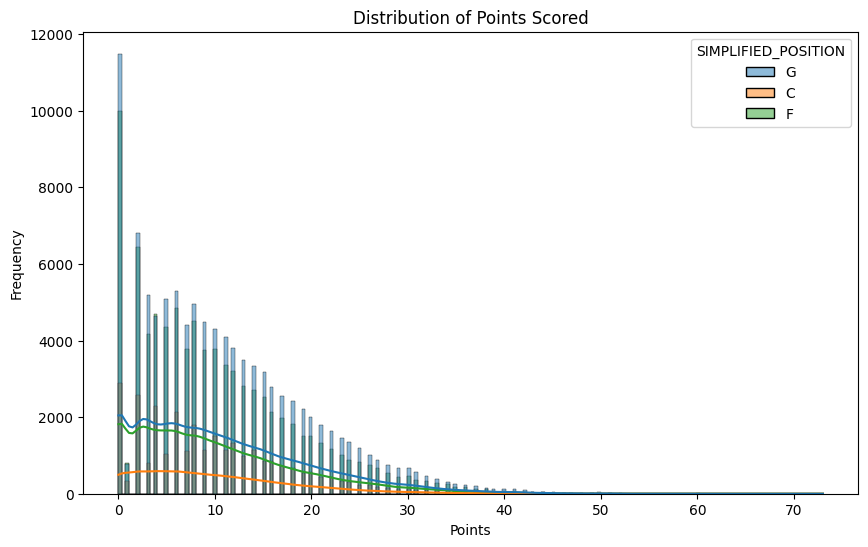

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df_player, x='PTS', hue='SIMPLIFIED_POSITION', kde=True)
plt.title('Distribution of Points Scored')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

In [49]:
print("Number of duplicate rows:", df_team.duplicated().sum())

Number of duplicate rows: 0


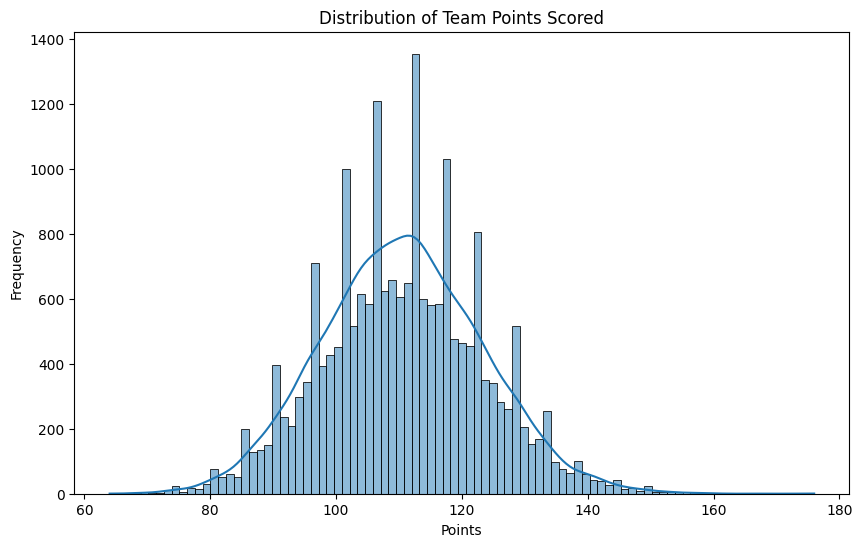

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(df_team['PTS'], kde=True)
plt.title('Distribution of Team Points Scored')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

In [51]:
df_team.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FGM_C,OPP_FGA_C,OPP_FGM_F,OPP_FGA_F,OPP_FGM_G,OPP_FGA_G,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME
0,2016-17,1610612739,CLE,0021600001,2016-10-25,CLE vs. NYK,W,240,117,45,94,13,35,14,19,11,40,51,31,15,12,5,29,115.8,87.1,28.7,101.0,0.703,0.103,0.625,0.375,0.846,0.154,0,46,19,16,17.12,441,314,17,39,28,55,10,18,4.4,10.2,15.6,47.4,16.6,42.2,1.0,2.8,4.4,15.6,5.0,14.0,1.0,9.2,6.8,1.6,11.6,9.6,21.0,16.0,16.0,52.0,14.0,16.0,9.0,28.0,5,6,22,22,23.0,36.0,3.0,7.0,6.0,16.0,6.0,12.0,7.0,23.0,1
2,2016-17,1610612744,GSW,0021600003,2016-10-25,GSW vs. SAS,L,240,100,40,85,7,33,13,18,8,27,35,24,16,11,6,-29,99.0,129.0,-30.0,100.5,0.400,0.180,0.576,0.424,0.714,0.286,0,62,21,23,16.90,397,277,21,38,19,47,20,32,5.2,10.8,22.0,45.6,25.6,53.4,1.0,2.2,6.0,11.6,7.0,13.4,2.4,10.6,13.2,2.6,12.2,15.0,15.0,4.0,20.0,48.0,17.0,26.0,24.0,50.0,6,3,19,19,17.0,25.0,7.0,12.0,9.0,15.0,1.0,10.0,6.0,22.0,1
4,2016-17,1610612752,NYK,0021600001,2016-10-25,NYK @ CLE,L,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,8.0,18.6,19.6,41.4,20.2,40.8,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5.8,7.2,3.0,7.8,9.8,14.0,16.0,9.0,28.0,21.0,16.0,16.0,52.0,6,5,22,22,10.0,22.0,4.0,8.0,9.0,30.0,3.0,5.0,6.0,21.0,0
6,2016-17,1610612757,POR,0021600002,2016-10-25,POR vs. UTA,W,240,113,39,75,13,19,22,22,5,29,34,22,13,5,3,9,122.8,114.3,8.5,91.5,0.548,0.159,0.500,0.500,0.692,0.308,0,44,18,9,16.65,362,255,19,43,20,32,14,20,4.6,8.0,21.6,43.8,20.6,43.2,1.4,2.6,4.4,13.4,3.6,11.8,2.2,7.6,7.0,2.2,7.6,7.0,20.0,15.0,4.0,34.0,8.0,4.0,8.0,50.0,3,5,18,19,10.0,21.0,7.0,17.0,9.0,18.0,1.0,3.0,12.0,16.0,1
8,2016-17,1610612759,SAS,0021600003,2016-10-25,SAS @ GSW,W,240,129,47,98,12,24,23,26,21,34,55,25,14,13,3,29,129.0,99.0,30.0,100.5,0.600,0.155,0.429,0.571,0.833,0.167,0,34,30,19,17.76,471,339,23,45,24,53,16,23,7.8,17.0,22.2,47.0,20.2,42.0,1.4,6.6,4.0,18.2,3.0,15.6,1.6,7.8,7.2,2.8,10.0,10.2,17.0,26.0,24.0,50.0,15.0,4.0,20.0,48.0,3,6,19,19,18.0,31.0,7.0,17.0,10.0,26.0,4.0,7.0,8.0,17.0,0


C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_17060\1197179024.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


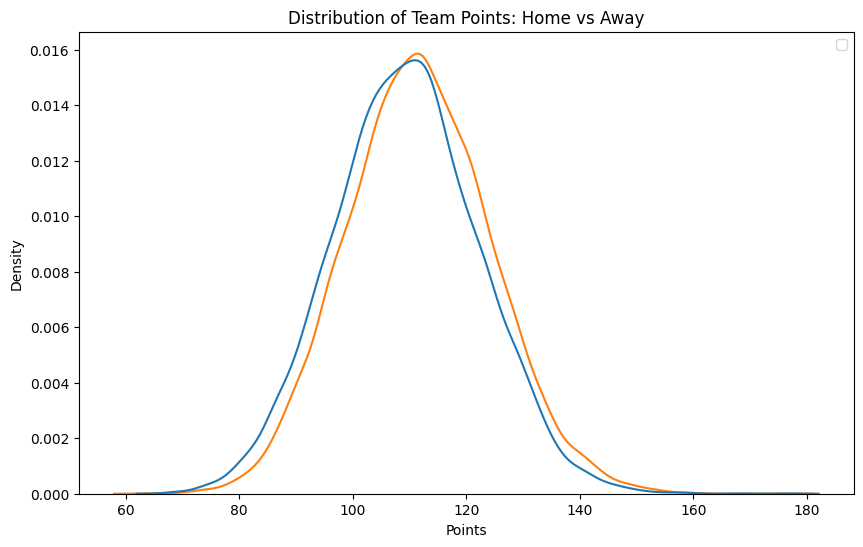

In [52]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_team, x='PTS', hue='IS_HOME', legend=True)
plt.title('Distribution of Team Points: Home vs Away')
plt.xlabel('Points')
plt.ylabel('Density')
plt.legend()
plt.show()

In [53]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    df = df.rename(columns={'SEASON_YEAR': 'SEASON'})

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    df = df.fillna(0)
    
    return df


df_team_clean = clean_team_data(df_team)
df_player_clean = clean_team_data(df_player)


In [54]:
conn = sqlite3.connect(DB_NAME)
pas = pd.read_sql("SELECT * FROM player_advanced_stats", conn)
pas.loc[pas['GAME_ID'].isin(('0041400312', '0021500970'))]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
383702,0041400312,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,F,,38.000000:58,101.1,100.0,99.3,98.7,1.8,1.3,0.037,0.50,9.1,0.051,0.133,0.087,18.2,0.438,0.438,0.116,0.119,92.21,93.02,77.52,76,0.029
383703,0041400312,1610612745,HOU,Houston,2746,Josh Smith,Josh,F,,21.000000:09,88.7,85.0,113.5,104.9,-24.8,-19.9,0.222,2.00,10.0,0.000,0.083,0.028,5.0,0.294,0.294,0.400,0.416,86.47,91.91,76.60,40,-0.012
383704,0041400312,1610612745,HOU,Houston,2730,Dwight Howard,Dwight,C,,40.000000:05,109.7,108.9,102.0,103.8,7.8,5.1,0.040,0.50,5.9,0.135,0.343,0.236,11.8,0.727,0.675,0.184,0.187,95.06,94.60,78.84,79,0.159
383705,0041400312,1610612745,HOU,Houston,201935,James Harden,James,G,,40.000000:59,115.8,113.6,99.1,100.0,16.6,13.6,0.391,4.50,25.0,0.026,0.265,0.137,5.6,0.690,0.748,0.303,0.309,93.81,94.28,78.57,81,0.289
383706,0041400312,1610612745,HOU,Houston,1891,Jason Terry,Jason,G,,35.000000:17,112.4,114.5,104.6,100.0,7.9,14.5,0.138,0.00,36.4,0.029,0.000,0.017,0.0,0.643,0.643,0.091,0.091,91.39,92.50,77.09,69,0.045
383707,0041400312,1610612745,HOU,Houston,203991,Clint Capela,Clint,,,7.000000:48,92.3,80.0,138.0,130.8,-45.7,-50.8,0.000,0.00,0.0,0.100,0.333,0.154,0.0,0.000,0.000,0.000,0.000,77.87,86.12,71.76,15,0.048
383708,0041400312,1610612745,HOU,Houston,203093,Terrence Jones,Terrence,,,26.000000:23,123.0,123.1,100.3,101.9,22.7,21.2,0.053,0.50,6.7,0.050,0.038,0.043,13.3,0.500,0.500,0.241,0.245,96.30,95.50,79.58,52,0.079
383709,0041400312,1610612745,HOU,Houston,203143,Pablo Prigioni,Pablo,,,7.000000:17,86.4,87.5,142.2,141.2,-55.8,-53.7,0.200,0.00,33.3,0.000,0.000,0.000,0.0,0.000,0.000,0.105,0.104,109.01,108.74,90.62,16,-0.026
383710,0041400312,1610612745,HOU,Houston,201147,Corey Brewer,Corey,,,19.000000:14,83.0,80.6,133.5,133.3,-50.5,-52.8,0.091,1.00,12.5,0.000,0.000,0.000,12.5,0.200,0.255,0.163,0.171,92.26,93.61,78.01,36,-0.056
383711,0041400312,1610612745,HOU,Houston,203910,Nick Johnson,Nick,,,2.000000:50,100.0,80.0,50.0,40.0,50.0,40.0,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.167,0.200,67.69,84.61,70.51,5,-0.222


In [55]:
df_player_clean.isnull().sum()

SEASON                             0
PLAYER_ID                          0
PLAYER_NAME                        0
TEAM_ID                            0
TEAM_ABBREVIATION                  0
GAME_ID                            0
GAME_DATE                          0
MATCHUP                            0
WL                                 0
MIN                                0
PTS                                0
FGM                                0
FGA                                0
FG3M                               0
FG3A                               0
FTM                                0
FTA                                0
OREB                               0
DREB                               0
REB                                0
AST                                0
TOV                                0
STL                                0
BLK                                0
PLUS_MINUS                         0
OFF_RATING                         0
DEF_RATING                         0
N

In [56]:
pd.options.display.max_rows = 100

# df_player_clean.loc[df_player['FGA_ABOVE_BREAK3'].isnull()]
df_player_clean[df_player_clean.isnull().any(axis=1)].groupby('SEASON').size().reset_index(name='rows_with_null')
df_team_clean[df_team_clean.isnull().any(axis=1)].groupby('SEASON').size().reset_index(name='rows_with_null')


,SEASON,rows_with_null


In [57]:
df_player_clean[['PTS', 'PCT_PTS_2PT_MR']]

(df_player_clean['PTS'] * df_player_clean['PCT_PTS_2PT_MR'])

0         0.000
1         2.000
2         6.003
3         0.000
4         1.998
          ...  
216722    2.000
216723    0.000
216724    2.001
216725    0.000
216726    0.000
Length: 216727, dtype: float64

In [58]:
def prep_for_aggregation_player(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']) #.astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']) #.astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']) #.astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']) #.astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']) #.astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    # percentage_columns = [x for x in df.columns if 'PCT' in x]
    # other_drop_columns = ['POSS', 'POSS', 'AST_TOV', 'AST_TOV', 'AST_RATIO', 'AST_RATIO',
    #                       'MIN', 'PIE', 'PIE']
    
    # drop_cols = percentage_columns + other_drop_columns
    
    # df = df.drop(columns = drop_cols)
    
    ## Reorder Columns


    return df


def prep_for_aggregation_team(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']) #.astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']) #.astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']) #.astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']) #.astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']) #.astype('int8')

    df['OPP_FG2M_G'] = df['OPP_FGM_G'] - df['OPP_FG3M_G']
    df['OPP_FG2A_G'] = df['OPP_FGA_G'] - df['OPP_FG3A_G']

    df['OPP_FG2M_F'] = df['OPP_FGM_F'] - df['OPP_FG3M_F']
    df['OPP_FG2A_F'] = df['OPP_FGA_F'] - df['OPP_FG3A_F']
    
    df['OPP_FG2M_C'] = df['OPP_FGM_C'] - df['OPP_FG3M_C']
    df['OPP_FG2A_C'] = df['OPP_FGA_C'] - df['OPP_FG3A_C']

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    # percentage_columns = [x for x in df.columns if 'PCT' in x]
    drop_cols= ['OPP_FGM_G', 'OPP_FGA_G', 'OPP_FGM_F', 'OPP_FGA_F', 'OPP_FGM_C', 'OPP_FGA_C']
    #                       'MIN', 'PIE', 'PIE']
        
    df = df.drop(columns = drop_cols)
    
    ## Reorder Columns


    return df


df_team_clean2 = prep_for_aggregation_team(df_team_clean)
df_player_clean2 = prep_for_aggregation_player(df_player_clean)

df_team_clean2

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE
0,2016-17,1610612739,CLE,0021600001,2016-10-25,CLE vs. NYK,1,240,117,45,94,13,35,14,19,11,40,51,31,15,12,5,29,115.8,87.1,28.7,101.0,0.703,0.103,0.625,0.375,0.846,0.154,0,46,19,16,17.12,441,314,17,39,28,55,10,18,1.0,2.8,4.4,15.6,5.0,14.0,1.0,9.2,6.8,1.6,11.6,9.6,21.0,16.0,16.0,52.0,14.0,16.0,9.0,28.0,5,6,22,22,23.0,36.0,3.0,7.0,6.0,16.0,6.0,12.0,7.0,23.0,1,32,59,12.051,20.000,10.998,12.000,2.002,11.6,28.2,11.2,31.8,3.4,7.4,29,1,117
2,2016-17,1610612744,GSW,0021600003,2016-10-25,GSW vs. SAS,0,240,100,40,85,7,33,13,18,8,27,35,24,16,11,6,-29,99.0,129.0,-30.0,100.5,0.400,0.180,0.576,0.424,0.714,0.286,0,62,21,23,16.90,397,277,21,38,19,47,20,32,1.0,2.2,6.0,11.6,7.0,13.4,2.4,10.6,13.2,2.6,12.2,15.0,15.0,4.0,20.0,48.0,17.0,26.0,24.0,50.0,6,3,19,19,17.0,25.0,7.0,12.0,9.0,15.0,1.0,10.0,6.0,22.0,1,33,52,18.000,19.008,4.998,13.992,2.002,18.6,40.0,16.0,34.0,4.2,8.6,-29,0,100
4,2016-17,1610612752,NYK,0021600001,2016-10-25,NYK @ CLE,0,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5.8,7.2,3.0,7.8,9.8,14.0,16.0,9.0,28.0,21.0,16.0,16.0,52.0,6,5,22,22,10.0,22.0,4.0,8.0,9.0,30.0,3.0,5.0,6.0,21.0,0,23,60,18.040,8.993,8.001,14.007,0.999,14.2,25.4,14.2,26.4,6.0,12.4,-29,0,88
6,2016-17,1610612757,POR,0021600002,2016-10-25,POR vs. UTA,1,240,113,39,75,13,19,22,22,5,29,34,22,13,5,3,9,122.8,114.3,8.5,91.5,0.548,0.159,0.500,0.500,0.692,0.308,0,44,18,9,16.65,362,255,19,43,20,32,14,20,1.4,2.6,4.4,13.4,3.6,11.8,2.2,7.6,7.0,2.2,7.6,7.0,20.0,15.0,4.0,34.0,8.0,4.0,8.0,50.0,3,5,18,19,10.0,21.0,7.0,17.0,9.0,18.0,1.0,3.0,12.0,16.0,1,26,56,17.967,13.000,8.996,13.000,4.004,17.0,31.4,17.2,30.4,3.2,5.4,9,1,113
8,2016-17,1610612759,SAS,0021600003,2016-10-25,SAS @ GSW,1,240,129,47,98,12,24,23,26,21,34,55,25,14,13,3,29,129.0,99.0,30.0,100.5,0.600,0.155,0.429,0.571,0.833,0.167,0,34,30,19,17.76,471,339,23,45,24,53,16,23,1.4,6.6,4.0,18.2,3.0,15.6,1.6,7.8,7.2,2.8,10.0,10.2,17.0,26.0,24.0,50.0,15.0,4.0,20.0,48.0,3,6,19,19,18.0,31.0,7.0,17.0,10.0,26.0,4.0,7.0,8.0,17.0,0,35,74,19.995,15.015,9.996,19.985,2.004,17.2,26.4,18.2,28.8,6.4,10.4,29,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20785,2023-24,1610612742,DAL,0042300403,2024-06-12,DAL vs. BOS,0,240,99,38,86,9,25,14,16,7,36,43,15,9,5,1,-7,106.5,115.2,-8.8,92.5,0.456,0.061,0.345,0.655,0.556,0.444,5,13,22,5,17.05,341,225,16,38,22,48,13,19,3.2,8.8,9.8,25.8,9.0,24.8,2.6,7.0,7.2,2.8,7.4,7.8,12.0,14.0,12.0,52.0,13.0,6.0,12.0,36.0,1,6,17,19,15.0,26.0,11.0,28.0,3.0,7.0,3.0,6.0,6.0,19.0,1,29,61,6.039,10.005,5.004,18.995,3.996,11.0,19.2,12.6,21.2,4.0,7.0,-7,0,99
20786,2023-24,1610612738,BOS,0042300404,2024-06-14,BOS @ DAL,0,240,84,29,80,14,41,12,13,4,27,3

In [7]:
# def create_matchups(df):
#     """This function makes each row a matchup between 
#     team and opp"""
#     keep_cols = ['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL',]
#     team_cols = [x for x in clean_df2.columns if '_team' in x]
    
#     team_df = clean_df2[keep_cols + team_cols]
#     team_df = team_df.drop_duplicates()
    
#     matchups = pd.merge(df, team_df, how='left', on=['GAME_ID'], suffixes=['', '_opp'])
#     matchups = matchups.loc[matchups['TEAM_ID'] != matchups['TEAM_ID_opp']]

#     matchups = matchups.drop(columns = ['SEASON_opp',
#                              'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
#                              'MATCHUP_opp', 'TEAM_NAME_opp',
#                                        'TEAM_ID_opp', 'WL_opp']
#                  )
    
#     matchups
    
#     return matchups


# matchups = create_matchups(clean_df2)


,SEASON,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_player,FGM_player,FGA_player,FG3M_player,FG3A_player,FTM_player,FTA_player,OREB_player,DREB_player,REB_player,AST_player,TOV_player,STL_player,BLK_player,BLKA_player,PF_player,PFD_player,PTS_player,PLUS_MINUS_player,E_OFF_RATING_player,E_DEF_RATING_player,E_NET_RATING_player,E_PACE_player,contestedShots_player,contestedShots2pt_player,contestedShots3pt_player,deflections_player,chargesDrawn_player,screenAssists_player,screenAssistPoints_player,looseBallsRecoveredOffensive_player,looseBallsRecoveredDefensive_player,looseBallsRecoveredTotal_player,offensiveBoxOuts_player,defensiveBoxOuts_player,boxOutPlayerTeamRebounds_player,boxOutPlayerRebounds_player,boxOuts_player,DIST_player,ORBC_player,DRBC_player,RBC_player,TCHS_player,SAST_player,FTAST_player,PASS_player,CFGM_player,CFGA_player,UFGM_player,UFGA_player,DFGM_player,DFGA_player,PTS_OFF_TOV_player,PTS_2ND_CHANCE_player,PTS_FB_player,PTS_PAINT_player,FGM_team,FGA_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,SEASON_YEAR_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,E_PACE_team,contestedShots_team,contestedShots2pt_team,contestedShots3pt_team,deflections_team,chargesDrawn_team,screenAssists_team,screenAssistPoints_team,looseBallsRecoveredOffensive_team,looseBallsRecoveredDefensive_team,looseBallsRecoveredTotal_team,offensiveBoxOuts_team,defensiveBoxOuts_team,boxOutPlayerTeamRebounds_team,boxOutPlayerRebounds_team,boxOuts_team,DIST_team,ORBC_team,DRBC_team,RBC_team,TCHS_team,SAST_team,FTAST_team,PASS_team,CFGM_team,CFGA_team,UFGM_team,UFGA_team,DFGM_team,DFGA_team,PTS_OFF_TOV_team,PTS_2ND_CHANCE_team,PTS_FB_team,PTS_PAINT_team,HOME_GAME,FG2M_player,FG2A_player,PTS_2PT_MR_player,AST_2PM_player,AST_3PM_player,UAST_2PM_player,UAST_3PM_player,POINT_DIFF_team,RECORD_team,TEAM_SCORE,FGM_team_opp,FGA_team_opp,FG3M_team_opp,FG3A_team_opp,FTM_team_opp,FTA_team_opp,OREB_team_opp,DREB_team_opp,REB_team_opp,AST_team_opp,STL_team_opp,BLK_team_opp,TOV_team_opp,PF_team_opp,PTS_team_opp,PLUS_MINUS_team_opp,SEASON_YEAR_team_opp,E_OFF_RATING_team_opp,E_DEF_RATING_team_opp,E_NET_RATING_team_opp,E_PACE_team_opp,contestedShots_team_opp,contestedShots2pt_team_opp,contestedShots3pt_team_opp,deflections_team_opp,chargesDrawn_team_opp,screenAssists_team_opp,screenAssistPoints_team_opp,looseBallsRecoveredOffensive_team_opp,looseBallsRecoveredDefensive_team_opp,looseBallsRecoveredTotal_team_opp,offensiveBoxOuts_team_opp,defensiveBoxOuts_team_opp,boxOutPlayerTeamRebounds_team_opp,boxOutPlayerRebounds_team_opp,boxOuts_team_opp,DIST_team_opp,ORBC_team_opp,DRBC_team_opp,RBC_team_opp,TCHS_team_opp,SAST_team_opp,FTAST_team_opp,PASS_team_opp,CFGM_team_opp,CFGA_team_opp,UFGM_team_opp,UFGA_team_opp,DFGM_team_opp,DFGA_team_opp,PTS_OFF_TOV_team_opp,PTS_2ND_CHANCE_team_opp,PTS_FB_team_opp,PTS_PAINT_team_opp,POINT_DIFF_team_opp,RECORD_team_opp
1,2016-17,1626171,Bobby Portis,Bobby,1610612741,CHI,Chicago Bulls,0021601222,2017-04-12,CHI vs. BKN,1,25.391667,5,11,1,2,1,2,2,8,10,3,1,2,0,0,1,2,12,16,117.7,84.5,33.2,99.36,11.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.88,5.0,9.0,13.0,63.0,0.0,0.0,49.0,4.0,5.0,1.0,6.0,1.0,3.0,4.0,0.0,4.0,8.0,41,95,14,30,16,21,14,48,62,28,15,4,13,18,112,39,2016-17,108.5,70.9,37.6,103.08,76.0,45.0,31.0,20.0,0.0,7.0,16.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,17.54,38.0,72.0,109.0,445.0,3.0,3.0,315.0,21.0,42.0,20.0,53.0,18.0,31.0,33.0,13.0,17.0,44.0,1,4,9,0,4,1,0,0,39,1,112,28,86,3,33,14,18,10,38,48,17,8,3,19,16,73,-39,2016-17,70.9,108.5,-37.6,103.08,71.0,48.0,23.0,15.0,0.0,7.0,14.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,17.54,35.0,73.0,107.0,424.0,2.0,0.0,300.0,18.0,39.0,10.0,47.0,16.0,28.0,10.0,16.0,9.0,40.0,-39,0
3,2016-17,1627758,Ron Baker,Ron,1610612752,NYK,New York Knicks,0021601220,2017-04-12,NYK vs. PHI,1,29.350000,3,6,1,3,1,2,0,1,1,4,2,0,0,0,1,3,8,-4,111.1,116.2,-5.0,96.

In [59]:
df_player_clean2.columns.tolist()

['SEASON',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG3M',
 'FG3A',
 'FTM',
 'FTA',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'PLUS_MINUS',
 'OFF_RATING',
 'DEF_RATING',
 'NET_RATING',
 'PACE',
 'PIE',
 'PCT_PTS_2PT_MR',
 'PCT_AST_2PM',
 'PCT_UAST_2PM',
 'PCT_AST_3PM',
 'PCT_UAST_3PM',
 'OFFENSIVE_BOX_OUTS',
 'LOOSE_BALLS_RECOVERED_OFFENSIVE',
 'DIST',
 'SPD',
 'TCHS',
 'PASS',
 'CFGM',
 'CFGA',
 'UFGM',
 'UFGA',
 'DFGM',
 'DFGA',
 'PTS_OFF_TOV',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_PAINT',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_PAINT',
 'BLOCKS',
 'BLOCKED_ATT',
 'PF',
 'PFD',
 'FGM_RESTRICTED',
 'FGA_RESTRICTED',
 'FGM_PAINT_NON_RA',
 'FGA_PAINT_NON_RA',
 'FGM_MIDRANGE',
 'FGA_MIDRANGE',
 'FGM_CORNER3',
 'FGA_CORNER3',
 'FGM_ABOVE_BREAK3',
 'FGA_ABOVE_BREAK3',
 'IS_HOME',
 'POSITION',
 'HEIGHT_INCHES',
 'WEIGHT_LBS',
 'SEASON_EXP',
 'AGE',

In [60]:
df_team_clean2.columns.tolist()

['SEASON',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG3M',
 'FG3A',
 'FTM',
 'FTA',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'PLUS_MINUS',
 'OFF_RATING',
 'DEF_RATING',
 'NET_RATING',
 'PACE',
 'PIE',
 'PCT_PTS_2PT_MR',
 'PCT_AST_2PM',
 'PCT_UAST_2PM',
 'PCT_AST_3PM',
 'PCT_UAST_3PM',
 'DEFENSIVE_BOX_OUTS',
 'CONTESTED_SHOTS_2PT',
 'CONTESTED_SHOTS_3PT',
 'deflections',
 'DIST',
 'TCHS',
 'PASS',
 'CFGM',
 'CFGA',
 'UFGM',
 'UFGA',
 'DFGM',
 'DFGA',
 'OPP_FG3M_C',
 'OPP_FG3A_C',
 'OPP_FG3M_F',
 'OPP_FG3A_F',
 'OPP_FG3M_G',
 'OPP_FG3A_G',
 'OPP_FTM_C',
 'OPP_FTM_F',
 'OPP_FTM_G',
 'OPP_FTA_C',
 'OPP_FTA_F',
 'OPP_FTA_G',
 'PTS_OFF_TOV',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_PAINT',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_PAINT',
 'BLOCKS',
 'BLOCKED_ATT',
 'PF',
 'PFD',
 'FGM_RESTRICTED',
 'FGA_RESTRICTED',
 'FGM_PAINT_NON_RA',
 'FGA_PAINT_NON_RA',
 'FGM_MIDRANGE',
 'FGA_M

In [62]:
def calculate_ewa_multiple_spans(df: pd.DataFrame, group_col: str, value_col: str, spans: list, team_level: bool) -> pd.DataFrame:
   
    df = df.sort_values([group_col, 'GAME_DATE'])
    
    ewa_df = pd.DataFrame()
    for span in tqdm(spans):
        col_name = f'EWA_{span}'
        ewa_df[col_name] = df.groupby(group_col)[value_col].transform(
            lambda x: x.ewm(span=span, adjust=False).mean().shift(1)
        )
    
    return ewa_df


def evaluate_ewa_multiple_spans(df: pd.DataFrame, actual_col: str, ewa_cols: list) -> pd.DataFrame:
    results = []
    for col in ewa_cols:
        # Remove rows where either the actual value or the EWA is NaN
        valid_data = df[[actual_col, col]].dropna()
        
        if len(valid_data) > 0:
            mae = mean_absolute_error(valid_data[actual_col], valid_data[col])
            mse = mean_squared_error(valid_data[actual_col], valid_data[col])
            span = int(col.split('_')[1])  # Extract span from column name
            results.append({'span': span, 'mae': mae, 'mse': mse})
    
    return pd.DataFrame(results)


def find_optimal_span(df: pd.DataFrame, group_col: str, value_col: str, spans: list, team_level: bool) -> int:

    ewa_df = calculate_ewa_multiple_spans(df, group_col, value_col, spans, team_level)
    ewa_cols = ewa_df.columns
    
    df_with_ewa = pd.concat([df[[group_col, 'GAME_DATE', value_col]], ewa_df], axis=1)
    
    eval_results = evaluate_ewa_multiple_spans(df_with_ewa, value_col, ewa_cols)
    optimal_span = eval_results.loc[eval_results['mae'].idxmin(), 'span']
    
    return optimal_span


def optimize_spans(df: pd.DataFrame, group_col: str, features: list, spans: list, team_level: bool) -> dict:
    optimal_spans = {}
    for feature in features:
        print(feature)
        optimal_span = find_optimal_span(df, group_col, feature, spans, team_level)
        optimal_spans[feature] = optimal_span
    return optimal_spans


# Define spans to test
spans = list(range(5, 53, 1))

# # Player-level optimization

# player_non_stat_cols = ['SEASON', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'POINT_DIFF', 'RECORD', 'TEAM_SCORE', 'POSITION', 'SIMPLIFIED_POSITION', 'IS_HOME']

# player_features = [col for col in df_player_clean2.columns if col not in player_non_stat_cols]
# player_optimal_spans = optimize_spans(df_player_clean2, 'PLAYER_ID', player_features, spans, team_level=False)

# Team-level optimization
team_non_stat_cols = ['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'POINT_DIFF', 'RECORD', 'TEAM_SCORE', 'IS_HOME']
team_features = [col for col in df_team_clean2.columns if col not in team_non_stat_cols]

team_optimal_spans = optimize_spans(df_team_clean2, 'TEAM_ID', team_features, spans, team_level=True)


PTS


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 99.79it/s] 


FGM


100%|██████████| 48/48 [00:00<00:00, 105.51it/s]


FGA


100%|██████████| 48/48 [00:00<00:00, 106.44it/s]


FG3M


100%|██████████| 48/48 [00:00<00:00, 79.60it/s]


FG3A


100%|██████████| 48/48 [00:00<00:00, 101.05it/s]


FTM


100%|██████████| 48/48 [00:00<00:00, 77.80it/s]


FTA


100%|██████████| 48/48 [00:00<00:00, 72.03it/s]


OREB


100%|██████████| 48/48 [00:00<00:00, 97.37it/s] 


DREB


100%|██████████| 48/48 [00:00<00:00, 96.00it/s]


REB


100%|██████████| 48/48 [00:00<00:00, 95.81it/s]


AST


100%|██████████| 48/48 [00:00<00:00, 101.91it/s]


TOV


100%|██████████| 48/48 [00:00<00:00, 69.38it/s]


STL


100%|██████████| 48/48 [00:00<00:00, 71.56it/s]


BLK


100%|██████████| 48/48 [00:00<00:00, 96.78it/s]


PLUS_MINUS


100%|██████████| 48/48 [00:00<00:00, 106.67it/s]


OFF_RATING


100%|██████████| 48/48 [00:00<00:00, 89.56it/s]


DEF_RATING


100%|██████████| 48/48 [00:00<00:00, 68.79it/s]


NET_RATING


100%|██████████| 48/48 [00:00<00:00, 104.80it/s]


PACE


100%|██████████| 48/48 [00:00<00:00, 94.49it/s] 


PIE


100%|██████████| 48/48 [00:00<00:00, 98.77it/s] 


PCT_PTS_2PT_MR


100%|██████████| 48/48 [00:00<00:00, 97.63it/s]


PCT_AST_2PM


100%|██████████| 48/48 [00:00<00:00, 100.81it/s]


PCT_UAST_2PM


100%|██████████| 48/48 [00:00<00:00, 105.50it/s]


PCT_AST_3PM


100%|██████████| 48/48 [00:00<00:00, 99.38it/s] 


PCT_UAST_3PM


100%|██████████| 48/48 [00:00<00:00, 96.78it/s] 


DEFENSIVE_BOX_OUTS


100%|██████████| 48/48 [00:00<00:00, 63.35it/s]


CONTESTED_SHOTS_2PT


100%|██████████| 48/48 [00:00<00:00, 97.56it/s] 


CONTESTED_SHOTS_3PT


100%|██████████| 48/48 [00:00<00:00, 88.05it/s]


deflections


100%|██████████| 48/48 [00:00<00:00, 101.27it/s]


DIST


100%|██████████| 48/48 [00:00<00:00, 93.52it/s]


TCHS


100%|██████████| 48/48 [00:00<00:00, 105.90it/s]


PASS


100%|██████████| 48/48 [00:00<00:00, 91.96it/s] 


CFGM


100%|██████████| 48/48 [00:00<00:00, 90.21it/s]


CFGA


100%|██████████| 48/48 [00:00<00:00, 106.43it/s]


UFGM


100%|██████████| 48/48 [00:00<00:00, 110.60it/s]


UFGA


100%|██████████| 48/48 [00:00<00:00, 109.09it/s]


DFGM


100%|██████████| 48/48 [00:00<00:00, 107.39it/s]


DFGA


100%|██████████| 48/48 [00:00<00:00, 109.85it/s]


OPP_FG3M_C


100%|██████████| 48/48 [00:00<00:00, 110.60it/s]


OPP_FG3A_C


100%|██████████| 48/48 [00:00<00:00, 110.86it/s]


OPP_FG3M_F


100%|██████████| 48/48 [00:00<00:00, 95.81it/s] 


OPP_FG3A_F


100%|██████████| 48/48 [00:00<00:00, 109.09it/s]


OPP_FG3M_G


100%|██████████| 48/48 [00:00<00:00, 109.59it/s]


OPP_FG3A_G


100%|██████████| 48/48 [00:00<00:00, 111.63it/s]


OPP_FTM_C


100%|██████████| 48/48 [00:00<00:00, 110.86it/s]


OPP_FTM_F


100%|██████████| 48/48 [00:00<00:00, 108.11it/s]


OPP_FTM_G


100%|██████████| 48/48 [00:00<00:00, 111.89it/s]


OPP_FTA_C


100%|██████████| 48/48 [00:00<00:00, 111.37it/s]


OPP_FTA_F


100%|██████████| 48/48 [00:00<00:00, 112.68it/s]


OPP_FTA_G


100%|██████████| 48/48 [00:00<00:00, 93.80it/s] 


PTS_OFF_TOV


100%|██████████| 48/48 [00:00<00:00, 112.38it/s]


PTS_2ND_CHANCE


100%|██████████| 48/48 [00:00<00:00, 112.69it/s]


PTS_FB


100%|██████████| 48/48 [00:00<00:00, 111.11it/s]


PTS_PAINT


100%|██████████| 48/48 [00:00<00:00, 109.83it/s]


OPP_PTS_OFF_TOV


100%|██████████| 48/48 [00:00<00:00, 109.34it/s]


OPP_PTS_2ND_CHANCE


100%|██████████| 48/48 [00:00<00:00, 111.11it/s]


OPP_PTS_FB


100%|██████████| 48/48 [00:00<00:00, 110.35it/s]


OPP_PTS_PAINT


100%|██████████| 48/48 [00:00<00:00, 93.52it/s] 


BLOCKS


100%|██████████| 48/48 [00:00<00:00, 110.81it/s]


BLOCKED_ATT


100%|██████████| 48/48 [00:00<00:00, 101.06it/s]


PF


100%|██████████| 48/48 [00:00<00:00, 109.84it/s]


PFD


100%|██████████| 48/48 [00:00<00:00, 110.71it/s]


FGM_RESTRICTED


100%|██████████| 48/48 [00:00<00:00, 111.37it/s]


FGA_RESTRICTED


100%|██████████| 48/48 [00:00<00:00, 110.60it/s]


FGM_PAINT_NON_RA


100%|██████████| 48/48 [00:00<00:00, 110.43it/s]


FGA_PAINT_NON_RA


100%|██████████| 48/48 [00:00<00:00, 111.11it/s]


FGM_MIDRANGE


100%|██████████| 48/48 [00:00<00:00, 110.35it/s]


FGA_MIDRANGE


100%|██████████| 48/48 [00:00<00:00, 109.75it/s]


FGM_CORNER3


100%|██████████| 48/48 [00:00<00:00, 111.63it/s]


FGA_CORNER3


100%|██████████| 48/48 [00:00<00:00, 110.86it/s]


FGM_ABOVE_BREAK3


100%|██████████| 48/48 [00:00<00:00, 111.11it/s]


FGA_ABOVE_BREAK3


100%|██████████| 48/48 [00:00<00:00, 111.89it/s]


FG2M


100%|██████████| 48/48 [00:00<00:00, 106.90it/s]


FG2A


100%|██████████| 48/48 [00:00<00:00, 89.14it/s] 


PTS_2PT_MR


100%|██████████| 48/48 [00:00<00:00, 110.86it/s]


AST_2PM


100%|██████████| 48/48 [00:00<00:00, 110.09it/s]


AST_3PM


100%|██████████| 48/48 [00:00<00:00, 111.25it/s]


UAST_2PM


100%|██████████| 48/48 [00:00<00:00, 109.34it/s]


UAST_3PM


100%|██████████| 48/48 [00:00<00:00, 95.06it/s] 


OPP_FG2M_G


100%|██████████| 48/48 [00:00<00:00, 106.43it/s]


OPP_FG2A_G


100%|██████████| 48/48 [00:00<00:00, 111.17it/s]


OPP_FG2M_F


100%|██████████| 48/48 [00:00<00:00, 110.35it/s]


OPP_FG2A_F


100%|██████████| 48/48 [00:00<00:00, 110.34it/s]


OPP_FG2M_C


100%|██████████| 48/48 [00:00<00:00, 111.63it/s]


OPP_FG2A_C


100%|██████████| 48/48 [00:00<00:00, 110.82it/s]


In [29]:
player_optimal_spans

{'MIN': 6,
 'PTS': 15,
 'FGM': 16,
 'FGA': 11,
 'FG3M': 22,
 'FG3A': 13,
 'FTM': 23,
 'FTA': 22,
 'OREB': 23,
 'DREB': 19,
 'REB': 16,
 'AST': 18,
 'TOV': 26,
 'STL': 27,
 'BLK': 20,
 'PLUS_MINUS': 31,
 'OFF_RATING': 20,
 'DEF_RATING': 21,
 'NET_RATING': 21,
 'PACE': 16,
 'PIE': 24,
 'PCT_PTS_2PT_MR': 14,
 'PCT_AST_2PM': 18,
 'PCT_UAST_2PM': 19,
 'PCT_AST_3PM': 6,
 'PCT_UAST_3PM': 22,
 'OFFENSIVE_BOX_OUTS': 17,
 'LOOSE_BALLS_RECOVERED_OFFENSIVE': 52,
 'DIST': 6,
 'SPD': 17,
 'TCHS': 7,
 'PASS': 7,
 'CFGM': 19,
 'CFGA': 15,
 'UFGM': 22,
 'UFGA': 14,
 'DFGM': 22,
 'DFGA': 18,
 'PTS_OFF_TOV': 26,
 'PTS_2ND_CHANCE': 25,
 'PTS_FB': 23,
 'PTS_PAINT': 17,
 'OPP_PTS_OFF_TOV': 17,
 'OPP_PTS_2ND_CHANCE': 19,
 'OPP_PTS_FB': 19,
 'OPP_PTS_PAINT': 10,
 'BLOCKS': 20,
 'BLOCKED_ATT': 24,
 'PF': 21,
 'PFD': 19,
 'FGM_RESTRICTED': 18,
 'FGA_RESTRICTED': 16,
 'FGM_PAINT_NON_RA': 25,
 'FGA_PAINT_NON_RA': 20,
 'FGM_MIDRANGE': 16,
 'FGA_MIDRANGE': 14,
 'FGM_CORNER3': 14,
 'FGA_CORNER3': 24,
 'FGM_ABOVE_BRE

In [63]:
team_optimal_spans

{'PTS': 29,
 'FGM': 33,
 'FGA': 32,
 'FG3M': 28,
 'FG3A': 19,
 'FTM': 37,
 'FTA': 37,
 'OREB': 33,
 'DREB': 37,
 'REB': 33,
 'AST': 30,
 'TOV': 39,
 'STL': 36,
 'BLK': 35,
 'PLUS_MINUS': 38,
 'OFF_RATING': 37,
 'DEF_RATING': 43,
 'NET_RATING': 39,
 'PACE': 17,
 'PIE': 37,
 'PCT_PTS_2PT_MR': 20,
 'PCT_AST_2PM': 31,
 'PCT_UAST_2PM': 31,
 'PCT_AST_3PM': 37,
 'PCT_UAST_3PM': 38,
 'DEFENSIVE_BOX_OUTS': 11,
 'CONTESTED_SHOTS_2PT': 24,
 'CONTESTED_SHOTS_3PT': 25,
 'deflections': 30,
 'DIST': 43,
 'TCHS': 31,
 'PASS': 22,
 'CFGM': 29,
 'CFGA': 26,
 'UFGM': 34,
 'UFGA': 32,
 'DFGM': 31,
 'DFGA': 29,
 'OPP_FG3M_C': 10,
 'OPP_FG3A_C': 7,
 'OPP_FG3M_F': 18,
 'OPP_FG3A_F': 11,
 'OPP_FG3M_G': 19,
 'OPP_FG3A_G': 12,
 'OPP_FTM_C': 12,
 'OPP_FTM_F': 20,
 'OPP_FTM_G': 21,
 'OPP_FTA_C': 11,
 'OPP_FTA_F': 18,
 'OPP_FTA_G': 19,
 'PTS_OFF_TOV': 45,
 'PTS_2ND_CHANCE': 37,
 'PTS_FB': 31,
 'PTS_PAINT': 27,
 'OPP_PTS_OFF_TOV': 47,
 'OPP_PTS_2ND_CHANCE': 47,
 'OPP_PTS_FB': 52,
 'OPP_PTS_PAINT': 32,
 'BLOCKS': 35

In [64]:
def apply_optimal_spans(df: pd.DataFrame, optimal_spans: dict, grouping_col) -> pd.DataFrame:
    
    df = df.sort_values([f'{grouping_col}', 'GAME_DATE'])
    
    for feature, span in optimal_spans.items():
        ewa_col = f'{feature}_EWA'
        df[ewa_col] = df.groupby(f'{grouping_col}')[feature].transform(
            lambda x: x.ewm(span=span, adjust=False).mean().shift(1)
        )
    
    
    return df


df_team_with_ewa = apply_optimal_spans(df_team_clean2, team_optimal_spans, 'TEAM_ID')
df_player_with_ewa = apply_optimal_spans(df_player_clean2, player_optimal_spans, 'PLAYER_ID')


C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_17060\306172694.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ewa_col] = df.groupby(f'{grouping_col}')[feature].transform(
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_17060\306172694.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ewa_col] = df.groupby(f'{grouping_col}')[feature].transform(
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_17060\306172694.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [65]:
df_team_with_ewa

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE,PTS_EWA,FGM_EWA,FGA_EWA,FG3M_EWA,FG3A_EWA,FTM_EWA,FTA_EWA,OREB_EWA,DREB_EWA,REB_EWA,AST_EWA,TOV_EWA,STL_EWA,BLK_EWA,PLUS_MINUS_EWA,OFF_RATING_EWA,DEF_RATING_EWA,NET_RATING_EWA,PACE_EWA,PIE_EWA,PCT_PTS_2PT_MR_EWA,PCT_AST_2PM_EWA,PCT_UAST_2PM_EWA,PCT_AST_3PM_EWA,PCT_UAST_3PM_EWA,DEFENSIVE_BOX_OUTS_EWA,CONTESTED_SHOTS_2PT_EWA,CONTESTED_SHOTS_3PT_EWA,deflections_EWA,DIST_EWA,TCHS_EWA,PASS_EWA,CFGM_EWA,CFGA_EWA,UFGM_EWA,UFGA_EWA,DFGM_EWA,DFGA_EWA,OPP_FG3M_C_EWA,OPP_FG3A_C_EWA,OPP_FG3M_F_EWA,OPP_FG3A_F_EWA,OPP_FG3M_G_EWA,OPP_FG3A_G_EWA,OPP_FTM_C_EWA,OPP_FTM_F_EWA,OPP_FTM_G_EWA,OPP_FTA_C_EWA,OPP_FTA_F_EWA,OPP_FTA_G_EWA,PTS_OFF_TOV_EWA,PTS_2ND_CHANCE_EWA,PTS_FB_EWA,PTS_PAINT_EWA,OPP_PTS_OFF_TOV_EWA,OPP_PTS_2ND_CHANCE_EWA,OPP_PTS_FB_EWA,OPP_PTS_PAINT_EWA,BLOCKS_EWA,BLOCKED_ATT_EWA,PF_EWA,PFD_EWA,FGM_RESTRICTED_EWA,FGA_RESTRICTED_EWA,FGM_PAINT_NON_RA_EWA,FGA_PAINT_NON_RA_EWA,FGM_MIDRANGE_EWA,FGA_MIDRANGE_EWA,FGM_CORNER3_EWA,FGA_CORNER3_EWA,FGM_ABOVE_BREAK3_EWA,FGA_ABOVE_BREAK3_EWA,FG2M_EWA,FG2A_EWA,PTS_2PT_MR_EWA,AST_2PM_EWA,AST_3PM_EWA,UAST_2PM_EWA,UAST_3PM_EWA,OPP_FG2M_G_EWA,OPP_FG2A_G_EWA,OPP_FG2M_F_EWA,OPP_FG2A_F_EWA,OPP_FG2M_C_EWA,OPP_FG2A_C_EWA
52,2016-17,1610612737,ATL,0021600014,2016-10-27,ATL vs. WAS,1,240,114,44,88,12,26,14,18,14,38,52,28,21,13,7,15,110.7,97.1,13.6,102.5,0.603,0.175,0.500,0.500,1.000,0.000,0,54,18,21,17.37,432,300,21,44,23,44,12,22,1.6,5.0,3.4,11.0,2.6,9.2,4.2,5.8,7.0,5.6,8.6,9.4,26.0,20.0,16.0,44.0,25.0,6.0,18.0,48.0,7,4,19,20,17.0,26.0,5.0,15.0,10.0,21.0,4.0,7.0,8.0,18.0,1,32,62,19.950,16.000,12.000,16.000,0.000,17.0,37.6,17.4,36.0,7.4,16.8,15,1,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,2016-17,1610612737,ATL,0021600026,2016-10-29,ATL @ PHI,1,240,104,42,85,5,20,15,23,6,41,47,31,12,11,7,32,103.0,72.0,31.0,100.5,0.742,0.231,0.703,0.297,1.000,0.000,0,46,13,14,18.03,398,276,19,37,23,48,8,19,1.2,3.6,2.0,8.4,3.0,9.6,1.8,6.4,6.2,2.6,8.6,8.0,22.0,8.0,19.0,50.0,8.0,9.0,7.0,36.0,7,5,14,20,20.0,26.0,5.0,15.0,12.0,24.0,2.0,4.0,3.0,15.0,0,37,65,24.024,26.011,5.000,10.989,0.000,11.4,30.8,11.6,32.4,4.8,11.6,32,1,104,114.000000,44.000000,88.000000,12.000000,26.000000,14.000000,18.000000,14.000000,38.000000,52.000000,28.000000,21.000000,13.000000,7.000000,15.000000,110.700000,97.100000,13.600000,102.500000,0.603000,0.175000,0.500000,0.500000,1.000000,0.000000,0.000000,54.000000,18.000000,21.000000,17.370000,432.000000,300.000000,21.000000,44.000000,23.000000,44.000000,12.000000,22.000000,1.600000,5.000000,3.400000,11.000000,2.600000,9.200000,4.200000,5.800000,7.000000,5.600000,8.600000,9.400000,26.000000,20.000000,16.000000,44.000000,25.000000,6.000000,18.000000,48.000000,7.000000,4.000000,19.000000,20.000000,17.000000,26.000000,5.000000,15.000000,10.000000,21.000000,4.000000,7.000000,8.000000,18.000000,32.000000,62.0000

In [89]:
df_player_with_ewa.columns.tolist()

['SEASON',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG3M',
 'FG3A',
 'FTM',
 'FTA',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'PLUS_MINUS',
 'OFF_RATING',
 'DEF_RATING',
 'NET_RATING',
 'PACE',
 'PIE',
 'PCT_PTS_2PT_MR',
 'PCT_AST_2PM',
 'PCT_UAST_2PM',
 'PCT_AST_3PM',
 'PCT_UAST_3PM',
 'OFFENSIVE_BOX_OUTS',
 'LOOSE_BALLS_RECOVERED_OFFENSIVE',
 'DIST',
 'SPD',
 'TCHS',
 'PASS',
 'CFGM',
 'CFGA',
 'UFGM',
 'UFGA',
 'DFGM',
 'DFGA',
 'PTS_OFF_TOV',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_PAINT',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_PAINT',
 'BLOCKS',
 'BLOCKED_ATT',
 'PF',
 'PFD',
 'FGM_RESTRICTED',
 'FGA_RESTRICTED',
 'FGM_PAINT_NON_RA',
 'FGA_PAINT_NON_RA',
 'FGM_MIDRANGE',
 'FGA_MIDRANGE',
 'FGM_CORNER3',
 'FGA_CORNER3',
 'FGM_ABOVE_BREAK3',
 'FGA_ABOVE_BREAK3',
 'IS_HOME',
 'POSITION',
 'HEIGHT_INCHES',
 'WEIGHT_LBS',
 'SEASON_EXP',
 'AGE',

In [76]:
def create_matchup_df(df):
    df_team_merged = pd.merge(df, df, on=['GAME_ID', 'GAME_DATE'], suffixes=('_tm', '_opp'))
    df_team_merged = df_team_merged.loc[df_team_merged['TEAM_ID_tm'] != df_team_merged['TEAM_ID_opp']]
    df_team_merged = df_team_merged.sort_values(['GAME_DATE', 'GAME_ID', 'IS_HOME_tm'])

    keep_cols = [col for col in df_team_merged.columns if "EWA" in col]
    keep_cols.extend(['SEASON_tm', 'TEAM_ID_tm', 'TEAM_ABBREVIATION_tm', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 'GAME_ID', 'GAME_DATE', 'MATCHUP_tm', 'WL_tm', 'PTS_tm', 'PTS_opp'])
    
    df_team_merged = df_team_merged.rename(columns={'EWA_tm': 'EWA_tm_tm', 'EWA_opp': 'EWA_tm_opp'}, inplace=True)
    
    return df_team_merged[keep_cols] 


df_matchup_team = create_matchup_df(df_team_with_ewa)



In [95]:
keep_cols = [col for col in df_player_with_ewa.columns if "EWA" in col]

keep_cols.extend(['SEASON', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'SIMPLIFIED_POSITION', 'AGE', 'HEIGHT_INCHES',
 'WEIGHT_LBS'])
df_player_with_ewa_2 = df_player_with_ewa[keep_cols].drop(columns=['HEIGHT_INCHES_EWA', 'WEIGHT_LBS_EWA', 'SEASON_EXP_EWA', 'AGE_EWA',])
df_player_with_ewa_2

,MIN_EWA,PTS_EWA,FGM_EWA,FGA_EWA,FG3M_EWA,FG3A_EWA,FTM_EWA,FTA_EWA,OREB_EWA,DREB_EWA,REB_EWA,AST_EWA,TOV_EWA,STL_EWA,BLK_EWA,PLUS_MINUS_EWA,OFF_RATING_EWA,DEF_RATING_EWA,NET_RATING_EWA,PACE_EWA,PIE_EWA,PCT_PTS_2PT_MR_EWA,PCT_AST_2PM_EWA,PCT_UAST_2PM_EWA,PCT_AST_3PM_EWA,PCT_UAST_3PM_EWA,OFFENSIVE_BOX_OUTS_EWA,LOOSE_BALLS_RECOVERED_OFFENSIVE_EWA,DIST_EWA,SPD_EWA,TCHS_EWA,PASS_EWA,CFGM_EWA,CFGA_EWA,UFGM_EWA,UFGA_EWA,DFGM_EWA,DFGA_EWA,PTS_OFF_TOV_EWA,PTS_2ND_CHANCE_EWA,PTS_FB_EWA,PTS_PAINT_EWA,OPP_PTS_OFF_TOV_EWA,OPP_PTS_2ND_CHANCE_EWA,OPP_PTS_FB_EWA,OPP_PTS_PAINT_EWA,BLOCKS_EWA,BLOCKED_ATT_EWA,PF_EWA,PFD_EWA,FGM_RESTRICTED_EWA,FGA_RESTRICTED_EWA,FGM_PAINT_NON_RA_EWA,FGA_PAINT_NON_RA_EWA,FGM_MIDRANGE_EWA,FGA_MIDRANGE_EWA,FGM_CORNER3_EWA,FGA_CORNER3_EWA,FGM_ABOVE_BREAK3_EWA,FGA_ABOVE_BREAK3_EWA,FG2M_EWA,FG2A_EWA,PTS_2PT_MR_EWA,AST_2PM_EWA,AST_3PM_EWA,UAST_2PM_EWA,UAST_3PM_EWA,SEASON,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,PTS,SIMPLIFIED_POSITION,AGE,HEIGHT_INCHES,WEIGHT_LBS
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-17,1713,Vince Carter,1610612763,MEM,0021600009,2016-10-26,MEM vs. MIN,3,G,39,78,220
544,28.088333,3.000000,1.000000,4.000000,0.000000,2.000000,1.000000,2.000000,1.000000,6.00000,7.000000,1.000000,0.000000,1.000000,1.000000,10.000000,116.100000,101.900000,14.200000,93.990000,0.053000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.940000,4.150000,32.000000,24.000000,1.000,1.000000,0.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,7.000000,11.00000,6.00000,30.000000,1.000000,0.000000,3.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.0,0.000000,0.000000,1.000000,0.000000,2016-17,1713,Vince Carter,1610612763,MEM,0021600028,2016-10-29,MEM @ NYK,5,G,39,78,220
745,27.338810,3.250000,1.117647,4.000000,0.086957,2.142857,0.916667,1.826087,1.000000,5.60000,6.529412,1.000000,0.000000,0.928571,0.904762,8.750000,114.757143,103.272727,11.545455,94.464118,0.053160,0.0,0.105263,0.900000,0.285714,0.000000,0.000000,0.0,1.880000,4.144444,30.500000,23.250000,0.900,0.875000,0.173913,3.133333,0.913043,1.789474,0.000000,0.230769,0.166667,2.000000,7.111111,10.90000,5.60000,28.909091,0.904762,0.000000,2.909091,0.90000,1.000000,1.000000,0.000000,0.000000,0.0,0.866667,0.133333,0.080000,0.000000,2.000000,1.000000,1.846154,0.0,0.100000,0.083333,0.894737,0.000000,2016-17,1713,Vince Carter,1610612763,MEM,0021600039,2016-10-30,MEM vs. WAS,18,G,39,78,220
985,28.619626,5.093750,1.574394,4.333333,0.514178,2.693878,1.090278,2.015123,0.916667,5.24000,5.996540,1.000000,0.000000,0.933673,0.913832,9.453125,116.475510,103.138843,13.314050,93.465986,0.062427,0.0,0.094183,0.810000,0.489796,0.000000,0.000000,0.0,1.928571,4.113951,32.375000,24.687500,0.810,0.890625,0.593573,3.382222,1.007561,1.811634,0.444444,0.443787,0.319444,1.777778,6.876543,10.31000,6.44000,29.107438,0.913832,0.000000,2.826446,1.01000,0.894737,0.882353,0.000000,0.000000,0.0,0.751111,0.515556,0.313600,0.173913,2.125000,0.882353,1.562130,0.0,0.090000,0.493056,0.800554,0.000000,2016-17,1713,Vince Carter,1610612763,MEM,0021600052,2016-11-01,MEM @ MIN,5,G,39,78,220
1180,24.571161,5.082031,1.624466,4.777778,0.556423,3.023324,0.999421,1.839895,0.840278,5.11600,5.761653,1.000000,0.000000,1.009840,0.826801,8.987305,114.315938,101.971675,12.412772,94.780576,0.069433,0.0,0.084269,0.829000,0.349854,0.086957,0.000000,0.0,1.668980,4.130178,30.781250,23.015625,0.829,1.154297,0.628914,3.464593,0.919947,1.620936,0.411523,0.409650,0.292824,1.802469,6.556927,9.27900,6.09600,24.542449,0.826801,0.000000,2.660406,0.90900,0.800554,0.778547,0.076923,0.190476,0.0,0.650963,0.446815,0.288512,0.245747,2.484375,0.896194,1.629495,0.0,0.081000,0.451968,0.821548,0.

In [96]:
final_df = pd.merge(df_player_with_ewa_2, df_matchup_team, how='left', left_on=['TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID_tm', 'GAME_ID'], suffixes = ['_player', ''])

final_df = final_df.dropna()

In [102]:
final_df.columns.tolist()

['MIN_EWA',
 'PTS_EWA',
 'FGM_EWA',
 'FGA_EWA',
 'FG3M_EWA',
 'FG3A_EWA',
 'FTM_EWA',
 'FTA_EWA',
 'OREB_EWA',
 'DREB_EWA',
 'REB_EWA',
 'AST_EWA',
 'TOV_EWA',
 'STL_EWA',
 'BLK_EWA',
 'PLUS_MINUS_EWA',
 'OFF_RATING_EWA',
 'DEF_RATING_EWA',
 'NET_RATING_EWA',
 'PACE_EWA',
 'PIE_EWA',
 'PCT_PTS_2PT_MR_EWA',
 'PCT_AST_2PM_EWA',
 'PCT_UAST_2PM_EWA',
 'PCT_AST_3PM_EWA',
 'PCT_UAST_3PM_EWA',
 'OFFENSIVE_BOX_OUTS_EWA',
 'LOOSE_BALLS_RECOVERED_OFFENSIVE_EWA',
 'DIST_EWA',
 'SPD_EWA',
 'TCHS_EWA',
 'PASS_EWA',
 'CFGM_EWA',
 'CFGA_EWA',
 'UFGM_EWA',
 'UFGA_EWA',
 'DFGM_EWA',
 'DFGA_EWA',
 'PTS_OFF_TOV_EWA',
 'PTS_2ND_CHANCE_EWA',
 'PTS_FB_EWA',
 'PTS_PAINT_EWA',
 'OPP_PTS_OFF_TOV_EWA',
 'OPP_PTS_2ND_CHANCE_EWA',
 'OPP_PTS_FB_EWA',
 'OPP_PTS_PAINT_EWA',
 'BLOCKS_EWA',
 'BLOCKED_ATT_EWA',
 'PF_EWA',
 'PFD_EWA',
 'FGM_RESTRICTED_EWA',
 'FGA_RESTRICTED_EWA',
 'FGM_PAINT_NON_RA_EWA',
 'FGA_PAINT_NON_RA_EWA',
 'FGM_MIDRANGE_EWA',
 'FGA_MIDRANGE_EWA',
 'FGM_CORNER3_EWA',
 'FGA_CORNER3_EWA',
 'FGM_ABOV


Training on seasons: 2016-17, 2017-18, 2018-19
Testing on season: 2019-20
Mean Absolute Error: 4.86
Root Mean Squared Error: 6.29
R-squared Score: 0.47


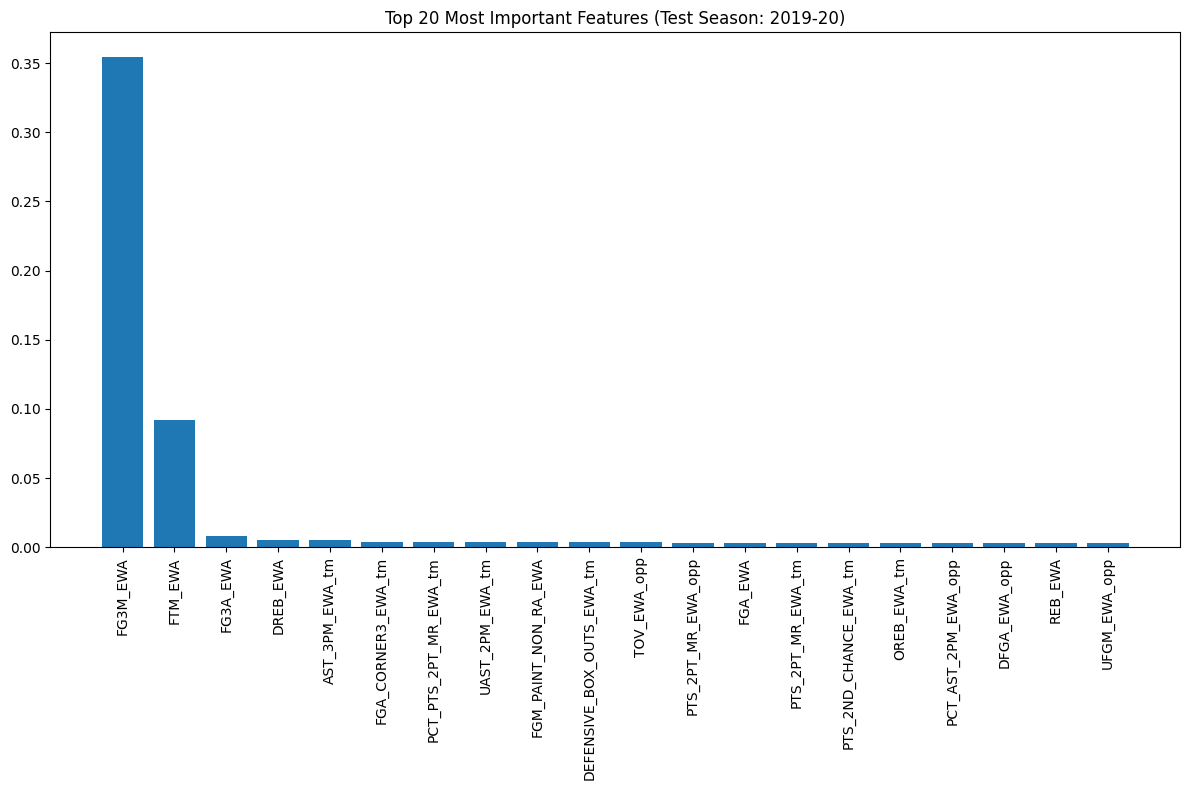


Top 20 Most Important Features:
FG3M_EWA: 0.3545
FTM_EWA: 0.0921
FG3A_EWA: 0.0082
DREB_EWA: 0.0054
AST_3PM_EWA_tm: 0.0051
FGA_CORNER3_EWA_tm: 0.0039
PCT_PTS_2PT_MR_EWA_tm: 0.0037
UAST_2PM_EWA_tm: 0.0037
FGM_PAINT_NON_RA_EWA: 0.0037
DEFENSIVE_BOX_OUTS_EWA_tm: 0.0037
TOV_EWA_opp: 0.0036
PTS_2PT_MR_EWA_opp: 0.0033
FGA_EWA: 0.0033
PTS_2PT_MR_EWA_tm: 0.0033
PTS_2ND_CHANCE_EWA_tm: 0.0032
OREB_EWA_tm: 0.0031
PCT_AST_2PM_EWA_opp: 0.0031
DFGA_EWA_opp: 0.0031
REB_EWA: 0.0031
UFGM_EWA_opp: 0.0031

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20
Testing on season: 2020-21
Mean Absolute Error: 4.72
Root Mean Squared Error: 6.11
R-squared Score: 0.51


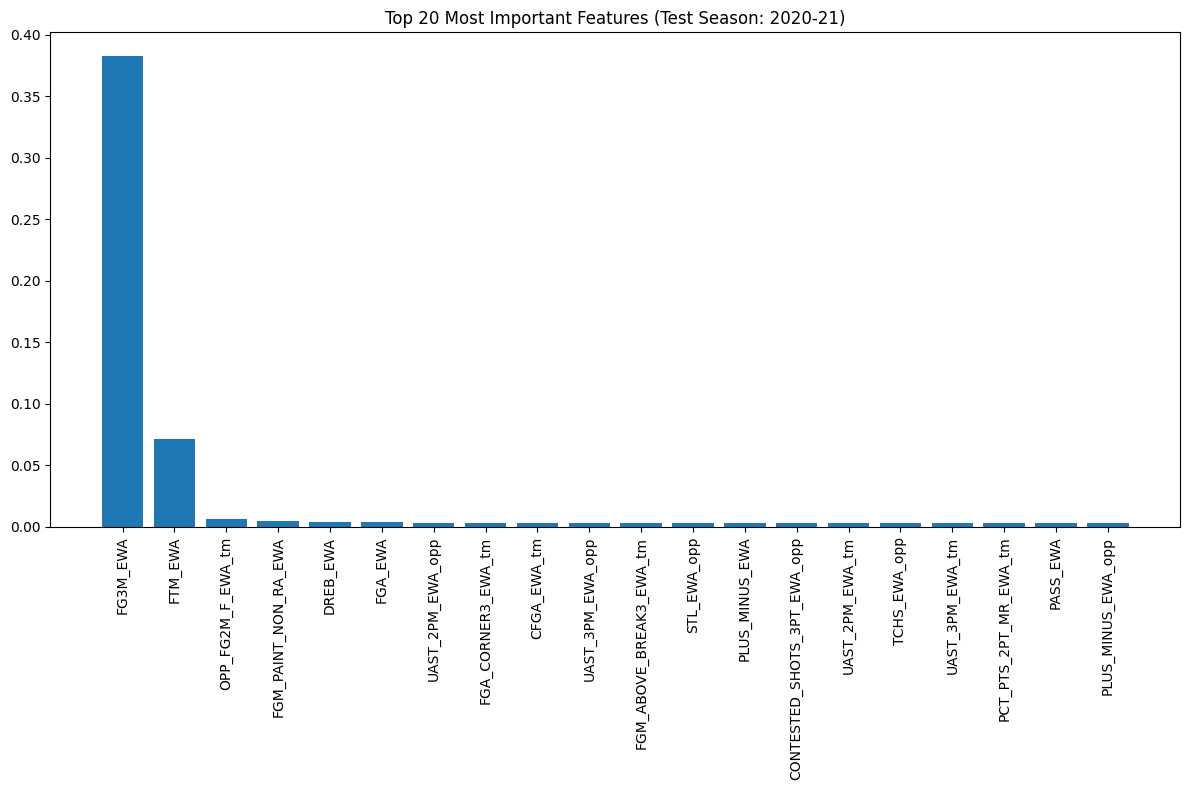


Top 20 Most Important Features:
FG3M_EWA: 0.3830
FTM_EWA: 0.0711
OPP_FG2M_F_EWA_tm: 0.0067
FGM_PAINT_NON_RA_EWA: 0.0050
DREB_EWA: 0.0042
FGA_EWA: 0.0039
UAST_2PM_EWA_opp: 0.0035
FGA_CORNER3_EWA_tm: 0.0034
CFGA_EWA_tm: 0.0034
UAST_3PM_EWA_opp: 0.0032
FGM_ABOVE_BREAK3_EWA_tm: 0.0032
STL_EWA_opp: 0.0031
PLUS_MINUS_EWA: 0.0031
CONTESTED_SHOTS_3PT_EWA_opp: 0.0030
UAST_2PM_EWA_tm: 0.0030
TCHS_EWA_opp: 0.0030
UAST_3PM_EWA_tm: 0.0029
PCT_PTS_2PT_MR_EWA_tm: 0.0029
PASS_EWA: 0.0029
PLUS_MINUS_EWA_opp: 0.0029

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21
Testing on season: 2021-22
Mean Absolute Error: 4.73
Root Mean Squared Error: 6.13
R-squared Score: 0.49


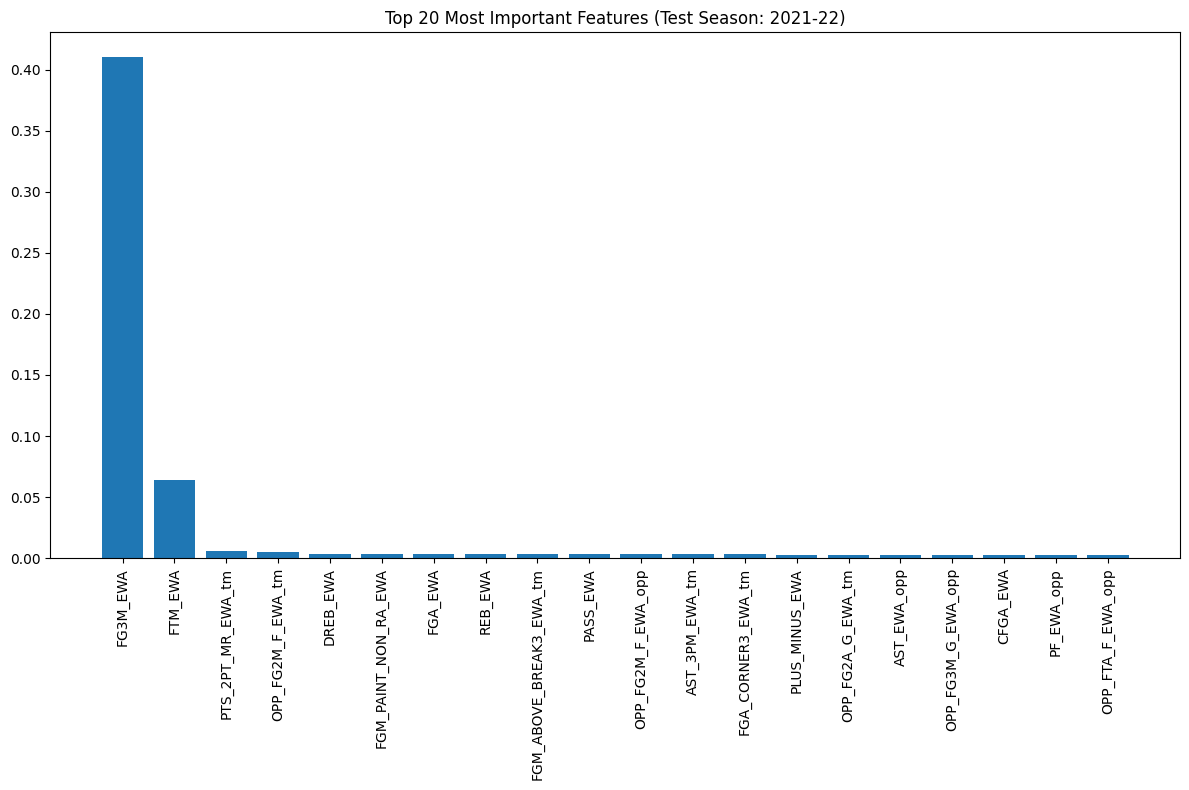


Top 20 Most Important Features:
FG3M_EWA: 0.4099
FTM_EWA: 0.0638
PTS_2PT_MR_EWA_tm: 0.0058
OPP_FG2M_F_EWA_tm: 0.0050
DREB_EWA: 0.0038
FGM_PAINT_NON_RA_EWA: 0.0038
FGA_EWA: 0.0036
REB_EWA: 0.0034
FGM_ABOVE_BREAK3_EWA_tm: 0.0033
PASS_EWA: 0.0033
OPP_FG2M_F_EWA_opp: 0.0031
AST_3PM_EWA_tm: 0.0031
FGA_CORNER3_EWA_tm: 0.0031
PLUS_MINUS_EWA: 0.0031
OPP_FG2A_G_EWA_tm: 0.0031
AST_EWA_opp: 0.0030
OPP_FG3M_G_EWA_opp: 0.0030
CFGA_EWA: 0.0029
PF_EWA_opp: 0.0029
OPP_FTA_F_EWA_opp: 0.0029

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22
Testing on season: 2022-23
Mean Absolute Error: 4.81
Root Mean Squared Error: 6.26
R-squared Score: 0.53


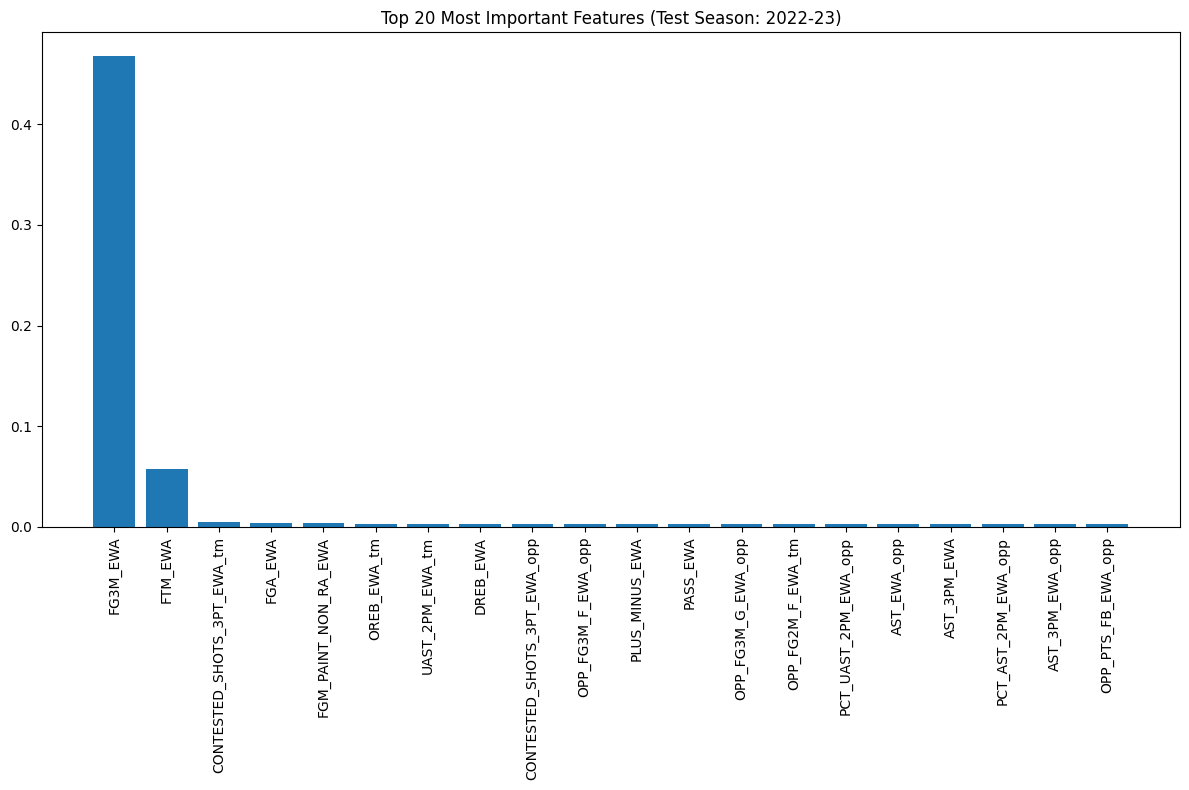


Top 20 Most Important Features:
FG3M_EWA: 0.4678
FTM_EWA: 0.0572
CONTESTED_SHOTS_3PT_EWA_tm: 0.0044
FGA_EWA: 0.0040
FGM_PAINT_NON_RA_EWA: 0.0036
OREB_EWA_tm: 0.0034
UAST_2PM_EWA_tm: 0.0033
DREB_EWA: 0.0032
CONTESTED_SHOTS_3PT_EWA_opp: 0.0030
OPP_FG3M_F_EWA_opp: 0.0030
PLUS_MINUS_EWA: 0.0030
PASS_EWA: 0.0029
OPP_FG3M_G_EWA_opp: 0.0029
OPP_FG2M_F_EWA_tm: 0.0028
PCT_UAST_2PM_EWA_opp: 0.0027
AST_EWA_opp: 0.0027
AST_3PM_EWA: 0.0027
PCT_AST_2PM_EWA_opp: 0.0027
AST_3PM_EWA_opp: 0.0026
OPP_PTS_FB_EWA_opp: 0.0026

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23
Testing on season: 2023-24
Mean Absolute Error: 4.70
Root Mean Squared Error: 6.09
R-squared Score: 0.55


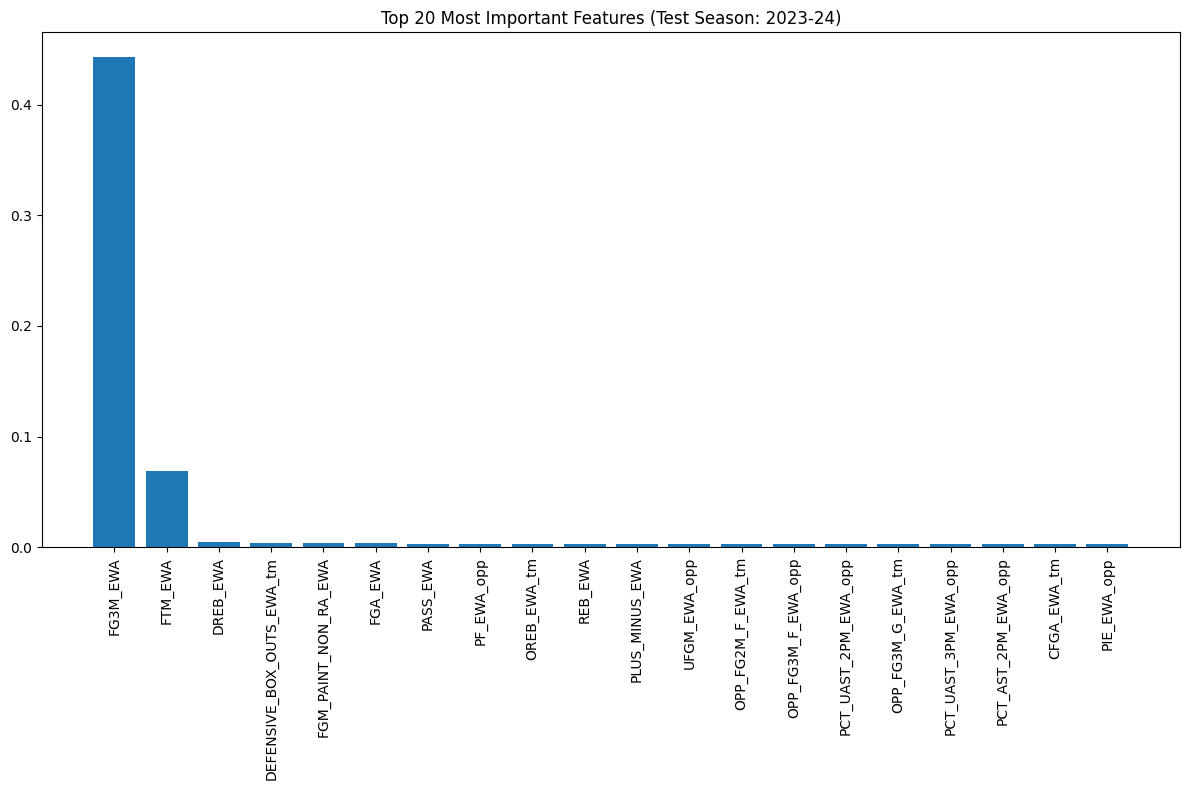


Top 20 Most Important Features:
FG3M_EWA: 0.4431
FTM_EWA: 0.0685
DREB_EWA: 0.0046
DEFENSIVE_BOX_OUTS_EWA_tm: 0.0040
FGM_PAINT_NON_RA_EWA: 0.0040
FGA_EWA: 0.0039
PASS_EWA: 0.0032
PF_EWA_opp: 0.0031
OREB_EWA_tm: 0.0029
REB_EWA: 0.0029
PLUS_MINUS_EWA: 0.0029
UFGM_EWA_opp: 0.0028
OPP_FG2M_F_EWA_tm: 0.0028
OPP_FG3M_F_EWA_opp: 0.0027
PCT_UAST_2PM_EWA_opp: 0.0027
OPP_FG3M_G_EWA_tm: 0.0027
PCT_UAST_3PM_EWA_opp: 0.0026
PCT_AST_2PM_EWA_opp: 0.0026
CFGA_EWA_tm: 0.0026
PIE_EWA_opp: 0.0026

All Results:
                                       Train Seasons Test Season       MAE  \
0                          2016-17, 2017-18, 2018-19     2019-20  4.859076   
1                 2016-17, 2017-18, 2018-19, 2019-20     2020-21  4.717960   
2        2016-17, 2017-18, 2018-19, 2019-20, 2020-21     2021-22  4.729009   
3  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2022-23  4.808636   
4  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2023-24  4.695498   

       RMSE  R-squared  
0  6.2938

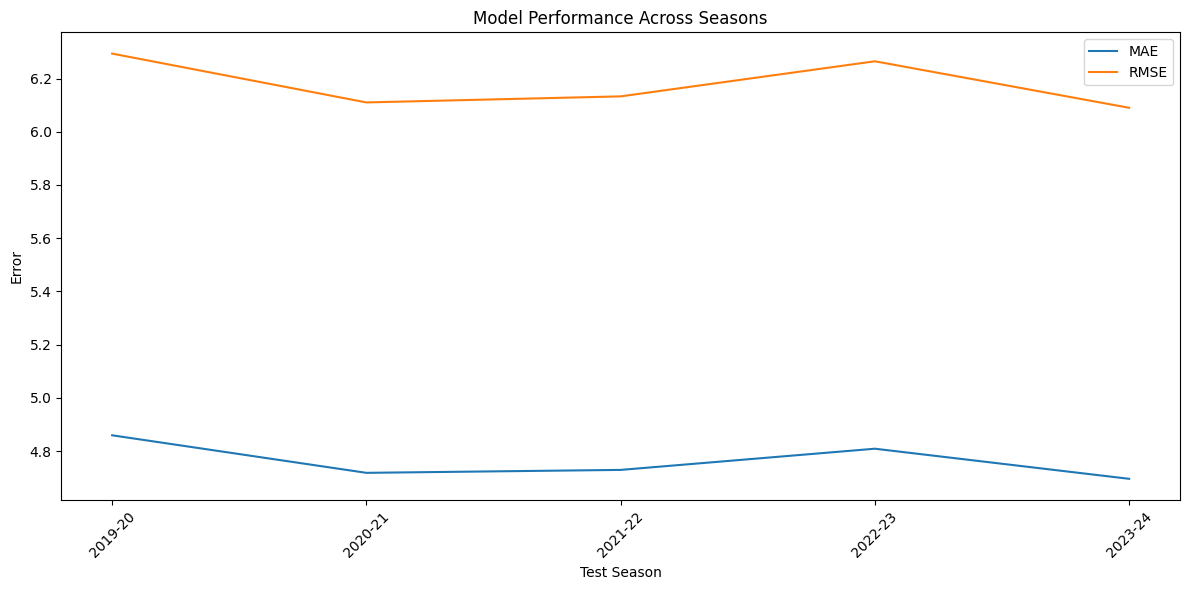

In [99]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

def custom_time_series_cv(X, y, train_seasons, test_season):
    train_mask = X['SEASON'].isin(train_seasons)
    test_mask = X['SEASON'] == test_season
    X_train = X[train_mask].drop('SEASON', axis=1)
    X_test = X[test_mask].drop('SEASON', axis=1)
    return X_train, X_test, y[train_mask], y[test_mask]

# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
X = final_df[['SEASON', 'SIMPLIFIED_POSITION', 'AGE', 'HEIGHT_INCHES', 'WEIGHT_LBS'] + ewa_columns]  # Include 'SEASON' column
X = pd.get_dummies(X, columns=['SIMPLIFIED_POSITION'], drop_first=True)
y = final_df['PTS']

# Define all seasons
all_seasons = sorted(X['SEASON'].unique())

# Initialize results storage
results = []

# Iterate through seasons, starting with training on the first 3 and testing on the 4th
for i in range(3, len(all_seasons)):
    train_seasons = all_seasons[:i]
    test_season = all_seasons[i]
    
    print(f"\nTraining on seasons: {', '.join(train_seasons)}")
    print(f"Testing on season: {test_season}")
    
    # Perform custom time series split
    X_train, X_test, y_train, y_test = custom_time_series_cv(X, y, train_seasons, test_season)
    
    # Create and train the XGBoost model
    model = xgb.XGBRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    # Store results
    results.append({
        'Train Seasons': ', '.join(train_seasons),
        'Test Season': test_season,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2
    })
    
    # Analyze feature importance
    feature_importance = model.feature_importances_
    feature_importance_sorted = sorted(zip(feature_importance, ewa_columns), reverse=True)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 8))
    plt.bar(range(20), [imp for imp, _ in feature_importance_sorted[:20]])
    plt.xticks(range(20), [name for _, name in feature_importance_sorted[:20]], rotation=90)
    plt.title(f"Top 20 Most Important Features (Test Season: {test_season})")
    plt.tight_layout()
    plt.show()
    
    # Print top 20 most important features
    print("\nTop 20 Most Important Features:")
    for imp, name in feature_importance_sorted[:20]:
        print(f"{name}: {imp:.4f}")

# Create a DataFrame with all results
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df)

# Plot the performance metrics across seasons
plt.figure(figsize=(12, 6))
plt.plot(results_df['Test Season'], results_df['MAE'], label='MAE')
plt.plot(results_df['Test Season'], results_df['RMSE'], label='RMSE')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Across Seasons')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
results_df

,Train Seasons,Test Season,MAE,RMSE,R-squared
0,"2016-17, 2017-18, 2018-19",2019-20,4.859076,6.293882,0.470572
1,"2016-17, 2017-18, 2018-19, 2019-20",2020-21,4.717960,6.110302,0.513498
2,"2016-17, 2017-18, 2018-19, 2019-20, 2020-21",2021-22,4.729009,6.133077,0.493852
3,"2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...",2022-23,4.808636,6.264985,0.526521
4,"2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...",2023-24,4.695498,6.090166,0.545291


In [79]:
# Define all seasons
all_seasons = sorted(X['SEASON'].unique())

results_ewa = []

# Iterate through seasons, starting with training on the first 3 and testing on the 4th
for i, s in enumerate(all_seasons):
    
    if i >= 3:

        print(f"Testing season: {s}")

        season_df = df_with_ewa.loc[df_with_ewa['SEASON'] == s].dropna()
        
        ewa_pts = season_df['PTS_player_EWA']
        
        actual_pts = season_df['PTS_player']

        # Make predictions and evaluate the model
        mae = mean_absolute_error(actual_pts, ewa_pts)
        rmse = np.sqrt(mean_squared_error(actual_pts, ewa_pts))
        r2 = r2_score(actual_pts, ewa_pts)
        
        # print(f"Mean Absolute Error: {mae:.2f}")
        # print(f"Root Mean Squared Error: {rmse:.2f}")
        # print(f"R-squared Score: {r2:.2f}")
        
        # Store results
        results_ewa.append({
            'Test Season': s,
            'MAE': mae,
            'RMSE': rmse,
            'R-squared': r2
        })

pd.DataFrame(results_ewa)

Testing season: 2019-20
Testing season: 2020-21
Testing season: 2021-22
Testing season: 2022-23
Testing season: 2023-24


,Test Season,MAE,RMSE,R-squared
0,2019-20,4.634868,6.049399,0.510904
1,2020-21,4.536323,5.946151,0.539286
2,2021-22,4.617342,6.028034,0.511042
3,2022-23,4.675384,6.146787,0.544218
4,2023-24,4.556409,6.000317,0.558609



Training on seasons: 2016-17, 2017-18, 2018-19
Testing on season: 2019-20

Linear Regression Results:
Mean Absolute Error: 4.64
Root Mean Squared Error: 5.98
R-squared Score: 0.52

XGBoost Results:
Mean Absolute Error: 4.88
Root Mean Squared Error: 6.29
R-squared Score: 0.47


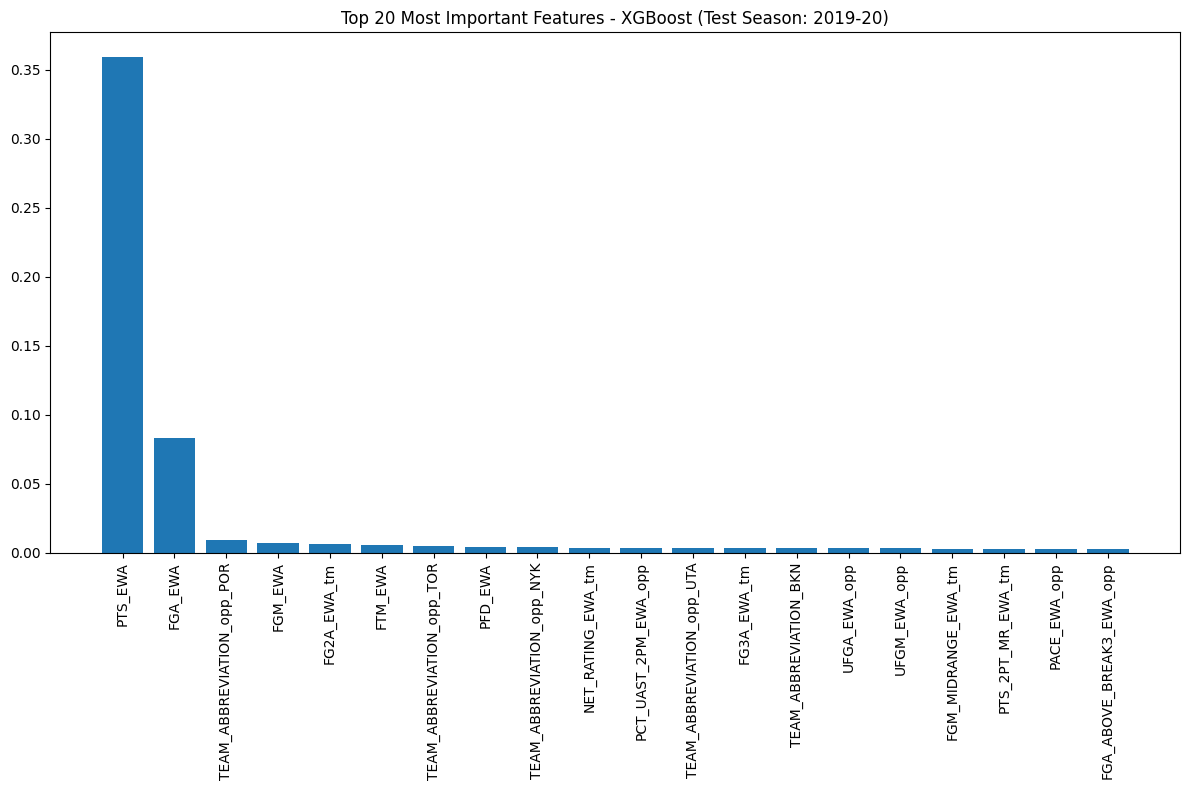


Top 20 Most Important Features (XGBoost):
PTS_EWA: 0.3592
FGA_EWA: 0.0830
TEAM_ABBREVIATION_opp_POR: 0.0092
FGM_EWA: 0.0069
FG2A_EWA_tm: 0.0064
FTM_EWA: 0.0053
TEAM_ABBREVIATION_opp_TOR: 0.0047
PFD_EWA: 0.0038
TEAM_ABBREVIATION_opp_NYK: 0.0037
NET_RATING_EWA_tm: 0.0033
PCT_UAST_2PM_EWA_opp: 0.0032
TEAM_ABBREVIATION_opp_UTA: 0.0032
FG3A_EWA_tm: 0.0031
TEAM_ABBREVIATION_BKN: 0.0030
UFGA_EWA_opp: 0.0030
UFGM_EWA_opp: 0.0030
FGM_MIDRANGE_EWA_tm: 0.0029
PTS_2PT_MR_EWA_tm: 0.0028
PACE_EWA_opp: 0.0028
FGA_ABOVE_BREAK3_EWA_opp: 0.0027

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20
Testing on season: 2020-21

Linear Regression Results:
Mean Absolute Error: 4.52
Root Mean Squared Error: 5.87
R-squared Score: 0.55

XGBoost Results:
Mean Absolute Error: 4.74
Root Mean Squared Error: 6.12
R-squared Score: 0.51


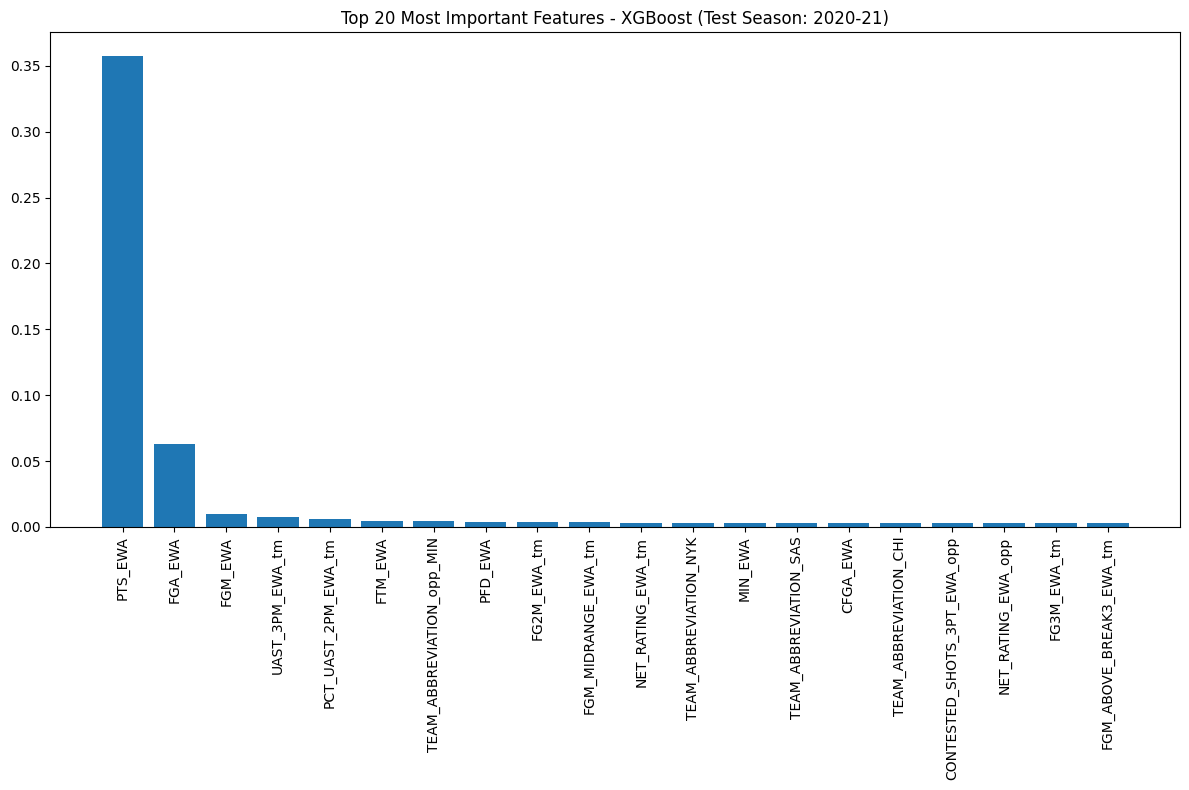


Top 20 Most Important Features (XGBoost):
PTS_EWA: 0.3575
FGA_EWA: 0.0626
FGM_EWA: 0.0097
UAST_3PM_EWA_tm: 0.0074
PCT_UAST_2PM_EWA_tm: 0.0060
FTM_EWA: 0.0047
TEAM_ABBREVIATION_opp_MIN: 0.0043
PFD_EWA: 0.0037
FG2M_EWA_tm: 0.0036
FGM_MIDRANGE_EWA_tm: 0.0035
NET_RATING_EWA_tm: 0.0033
TEAM_ABBREVIATION_NYK: 0.0032
MIN_EWA: 0.0032
TEAM_ABBREVIATION_SAS: 0.0032
CFGA_EWA: 0.0031
TEAM_ABBREVIATION_CHI: 0.0031
CONTESTED_SHOTS_3PT_EWA_opp: 0.0030
NET_RATING_EWA_opp: 0.0030
FG3M_EWA_tm: 0.0029
FGM_ABOVE_BREAK3_EWA_tm: 0.0029

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21
Testing on season: 2021-22

Linear Regression Results:
Mean Absolute Error: 4.60
Root Mean Squared Error: 5.95
R-squared Score: 0.52

XGBoost Results:
Mean Absolute Error: 4.73
Root Mean Squared Error: 6.14
R-squared Score: 0.49


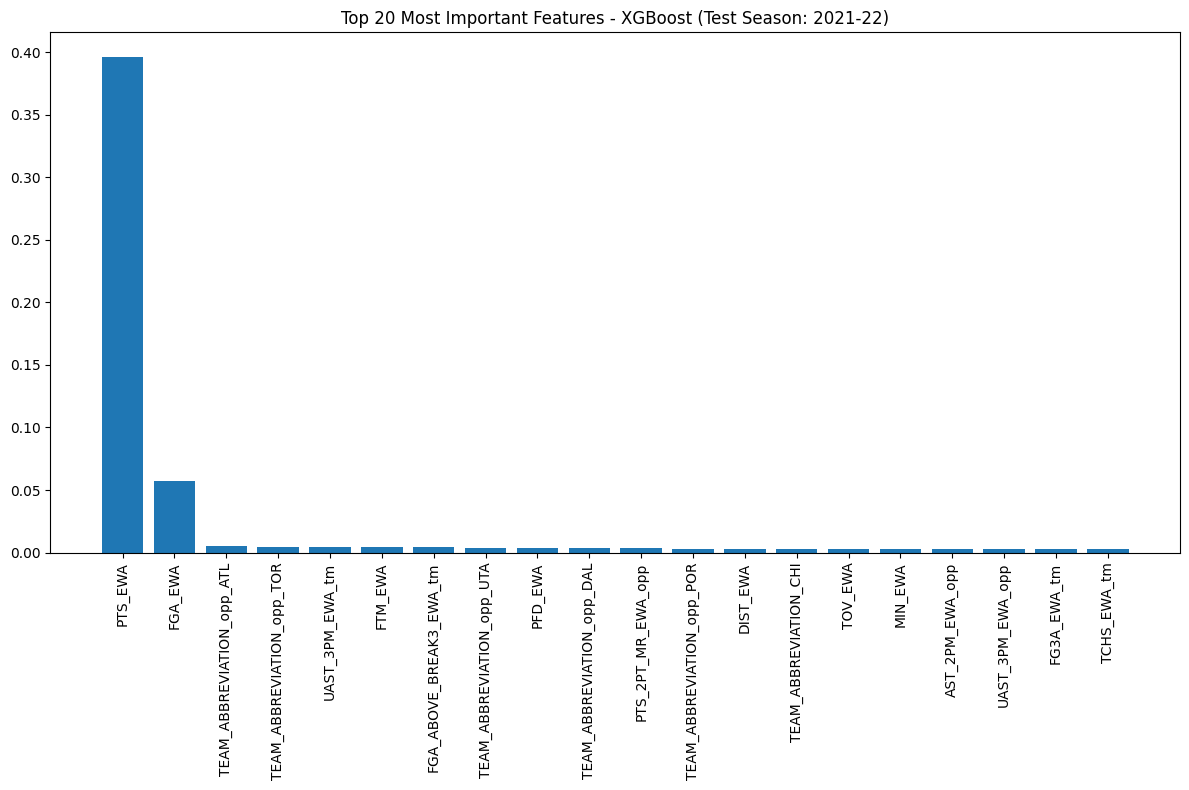


Top 20 Most Important Features (XGBoost):
PTS_EWA: 0.3962
FGA_EWA: 0.0574
TEAM_ABBREVIATION_opp_ATL: 0.0049
TEAM_ABBREVIATION_opp_TOR: 0.0048
UAST_3PM_EWA_tm: 0.0047
FTM_EWA: 0.0044
FGA_ABOVE_BREAK3_EWA_tm: 0.0040
TEAM_ABBREVIATION_opp_UTA: 0.0039
PFD_EWA: 0.0039
TEAM_ABBREVIATION_opp_DAL: 0.0037
PTS_2PT_MR_EWA_opp: 0.0033
TEAM_ABBREVIATION_opp_POR: 0.0032
DIST_EWA: 0.0031
TEAM_ABBREVIATION_CHI: 0.0030
TOV_EWA: 0.0030
MIN_EWA: 0.0030
AST_2PM_EWA_opp: 0.0029
UAST_3PM_EWA_opp: 0.0028
FG3A_EWA_tm: 0.0028
TCHS_EWA_tm: 0.0027

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22
Testing on season: 2022-23

Linear Regression Results:
Mean Absolute Error: 904279274.62
Root Mean Squared Error: 7145234950.91
R-squared Score: -615876181793922304.00

XGBoost Results:
Mean Absolute Error: 4.76
Root Mean Squared Error: 6.22
R-squared Score: 0.53


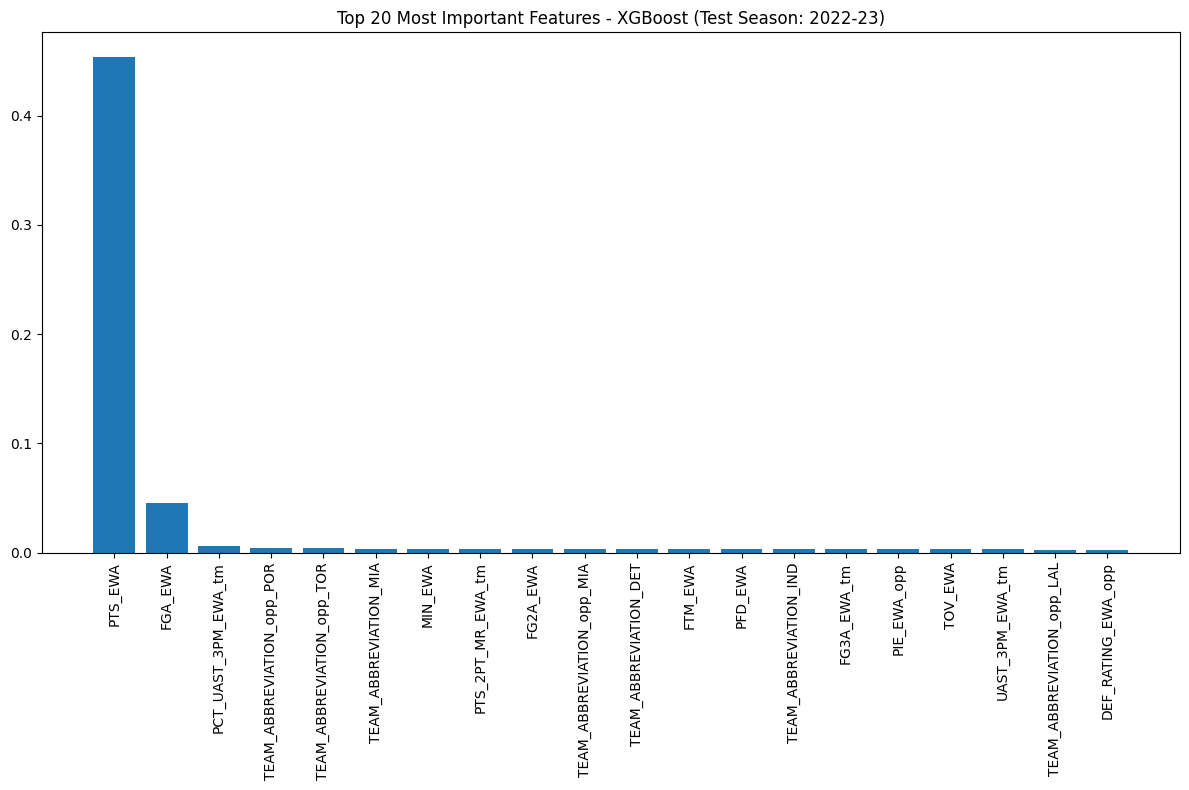


Top 20 Most Important Features (XGBoost):
PTS_EWA: 0.4537
FGA_EWA: 0.0451
PCT_UAST_3PM_EWA_tm: 0.0062
TEAM_ABBREVIATION_opp_POR: 0.0044
TEAM_ABBREVIATION_opp_TOR: 0.0039
TEAM_ABBREVIATION_MIA: 0.0033
MIN_EWA: 0.0033
PTS_2PT_MR_EWA_tm: 0.0032
FG2A_EWA: 0.0032
TEAM_ABBREVIATION_opp_MIA: 0.0032
TEAM_ABBREVIATION_DET: 0.0031
FTM_EWA: 0.0030
PFD_EWA: 0.0030
TEAM_ABBREVIATION_IND: 0.0030
FG3A_EWA_tm: 0.0029
PIE_EWA_opp: 0.0028
TOV_EWA: 0.0028
UAST_3PM_EWA_tm: 0.0028
TEAM_ABBREVIATION_opp_LAL: 0.0028
DEF_RATING_EWA_opp: 0.0027

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23
Testing on season: 2023-24

Linear Regression Results:
Mean Absolute Error: 4.52
Root Mean Squared Error: 5.90
R-squared Score: 0.57

XGBoost Results:
Mean Absolute Error: 4.70
Root Mean Squared Error: 6.10
R-squared Score: 0.54


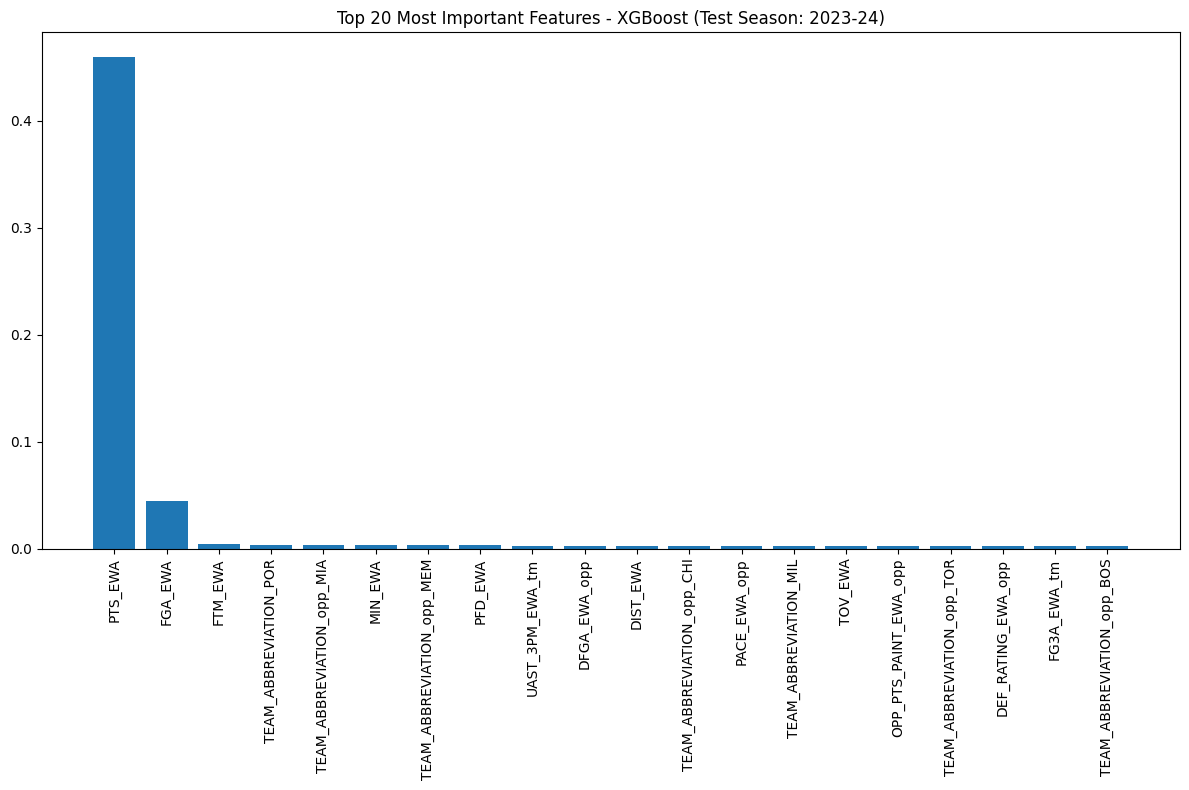


Top 20 Most Important Features (XGBoost):
PTS_EWA: 0.4597
FGA_EWA: 0.0446
FTM_EWA: 0.0044
TEAM_ABBREVIATION_POR: 0.0040
TEAM_ABBREVIATION_opp_MIA: 0.0038
MIN_EWA: 0.0037
TEAM_ABBREVIATION_opp_MEM: 0.0034
PFD_EWA: 0.0032
UAST_3PM_EWA_tm: 0.0029
DFGA_EWA_opp: 0.0028
DIST_EWA: 0.0028
TEAM_ABBREVIATION_opp_CHI: 0.0027
PACE_EWA_opp: 0.0027
TEAM_ABBREVIATION_MIL: 0.0026
TOV_EWA: 0.0026
OPP_PTS_PAINT_EWA_opp: 0.0026
TEAM_ABBREVIATION_opp_TOR: 0.0026
DEF_RATING_EWA_opp: 0.0025
FG3A_EWA_tm: 0.0025
TEAM_ABBREVIATION_opp_BOS: 0.0024

All Results:
                                       Train Seasons Test Season  \
0                          2016-17, 2017-18, 2018-19     2019-20   
1                 2016-17, 2017-18, 2018-19, 2019-20     2020-21   
2        2016-17, 2017-18, 2018-19, 2019-20, 2020-21     2021-22   
3  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2022-23   
4  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2023-24   

   Linear Regression MAE  Linear Regression RMSE

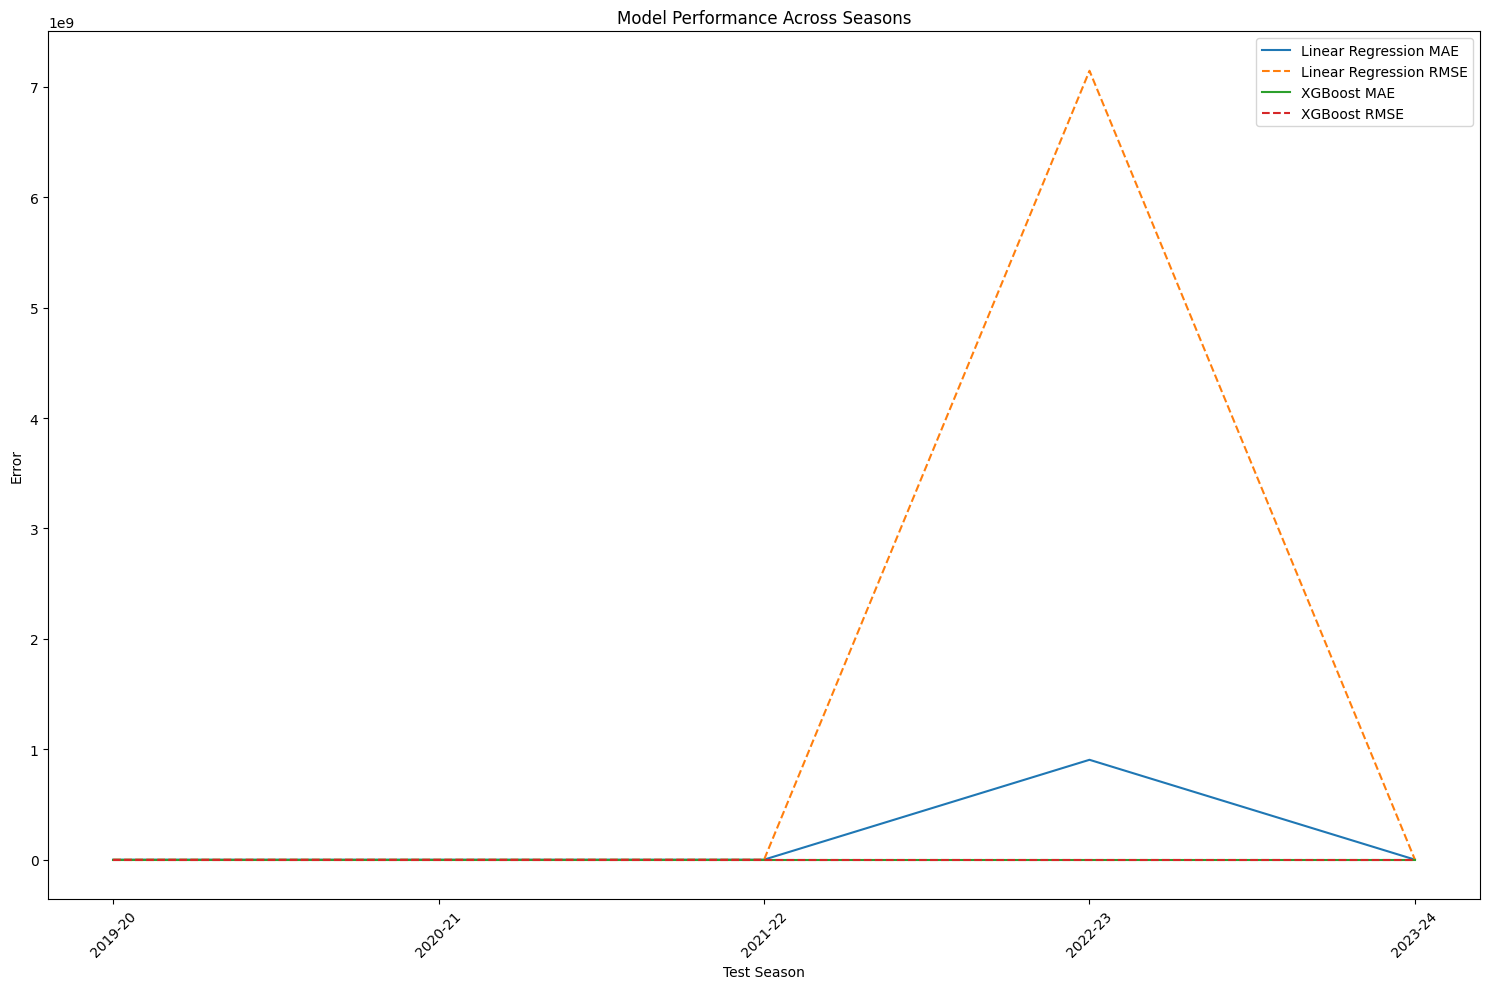

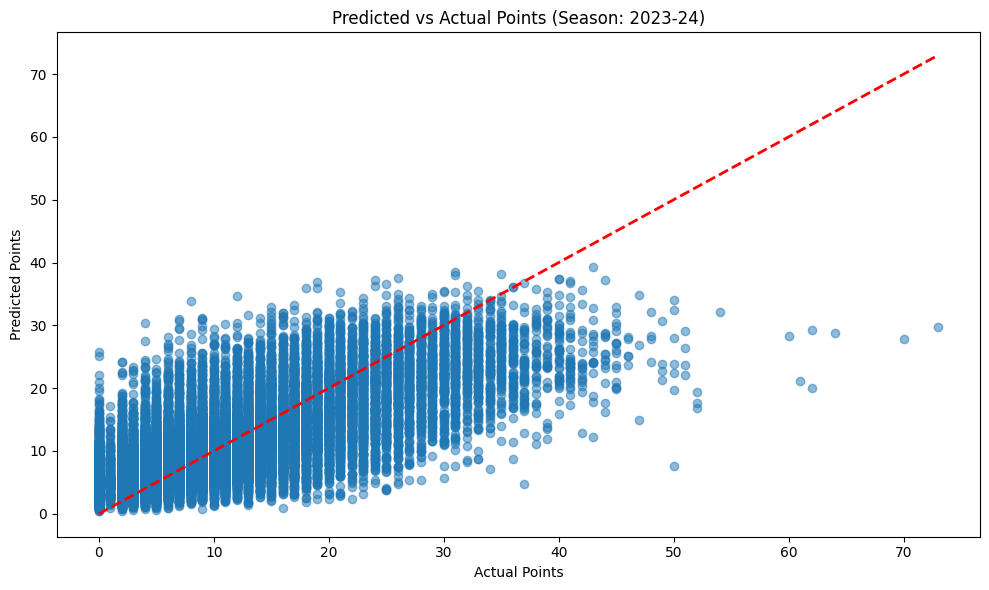

In [107]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def custom_time_series_cv(X, y, train_seasons, test_season):
    train_mask = X['SEASON'].isin(train_seasons)
    test_mask = X['SEASON'] == test_season
    X_train = X[train_mask].drop('SEASON', axis=1)
    X_test = X[test_mask].drop('SEASON', axis=1)
    return X_train, X_test, y[train_mask], y[test_mask]

# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
categorical_features = ['SIMPLIFIED_POSITION', 'TEAM_ABBREVIATION', 'TEAM_ABBREVIATION_tm', 'TEAM_ABBREVIATION_opp']
numeric_features = ['AGE', 'HEIGHT_INCHES', 'WEIGHT_LBS'] + ewa_columns
X = final_df[['SEASON'] + numeric_features + categorical_features]
y = final_df['PTS']

# Define all seasons
all_seasons = sorted(X['SEASON'].unique())

# Initialize results storage
results = []

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_estimators=100)
}

# Iterate through seasons, starting with training on the first 3 and testing on the 4th
for i in range(3, len(all_seasons)):
    train_seasons = all_seasons[:i]
    test_season = all_seasons[i]
    
    print(f"\nTraining on seasons: {', '.join(train_seasons)}")
    print(f"Testing on season: {test_season}")
    
    # Perform custom time series split
    X_train, X_test, y_train, y_test = custom_time_series_cv(X, y, train_seasons, test_season)
    
    # Fit preprocessor on training data
    preprocessor.fit(X_train)
    
    # Transform both training and test data
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    season_results = {'Train Seasons': ', '.join(train_seasons), 'Test Season': test_season}
    
    for name, model in models.items():
        # Create and train the model
        model.fit(X_train_preprocessed, y_train)
        
        # Make predictions and evaluate the model
        y_pred = model.predict(X_test_preprocessed)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n{name} Results:")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"R-squared Score: {r2:.2f}")
        
        season_results[f'{name} MAE'] = mae
        season_results[f'{name} RMSE'] = rmse
        season_results[f'{name} R-squared'] = r2
        
        # Analyze feature importance for tree-based models
        if name in ['XGBoost']:
            feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
            feature_importance = model.feature_importances_
            feature_importance_sorted = sorted(zip(feature_importance, feature_names), reverse=True)
            
            # Plot top 20 most important features
            plt.figure(figsize=(12, 8))
            plt.bar(range(20), [imp for imp, _ in feature_importance_sorted[:20]])
            plt.xticks(range(20), [name for _, name in feature_importance_sorted[:20]], rotation=90)
            plt.title(f"Top 20 Most Important Features - {name} (Test Season: {test_season})")
            plt.tight_layout()
            plt.show()
            
            # Print top 20 most important features
            print(f"\nTop 20 Most Important Features ({name}):")
            for imp, name in feature_importance_sorted[:20]:
                print(f"{name}: {imp:.4f}")
    
    results.append(season_results)

# Create a DataFrame with all results
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df)

# Plot the performance metrics across seasons
plt.figure(figsize=(15, 10))
for model_name in models.keys():
    plt.plot(results_df['Test Season'], results_df[f'{model_name} MAE'], label=f'{model_name} MAE')
    plt.plot(results_df['Test Season'], results_df[f'{model_name} RMSE'], label=f'{model_name} RMSE', linestyle='--')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Across Seasons')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize predictions vs actual for the latest season
latest_season = all_seasons[-1]
X_train, X_test, y_train, y_test = custom_time_series_cv(X, y, all_seasons[:-1], latest_season)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

best_model = models['XGBoost']  # You can change this to the best performing model
best_model.fit(X_train_preprocessed, y_train)
y_pred = best_model.predict(X_test_preprocessed)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title(f'Predicted vs Actual Points (Season: {latest_season})')
plt.tight_layout()
plt.show()

In [122]:
final_df['SIMPLIFIED_POSITION']

1         G
2         G
3         G
4         G
5         G
         ..
216722    C
216723    C
216724    C
216725    C
216726    C
Name: SIMPLIFIED_POSITION, Length: 215437, dtype: object


Training on seasons: 2016-17
Testing on season: 2017-18
Mean Absolute Error: 3005482944089.36
Root Mean Squared Error: 3917886598795.54

Training on seasons: 2016-17, 2017-18
Testing on season: 2018-19
Mean Absolute Error: 12.70
Root Mean Squared Error: 16.10

Training on seasons: 2016-17, 2017-18, 2018-19
Testing on season: 2019-20
Mean Absolute Error: 12.86
Root Mean Squared Error: 16.42

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20
Testing on season: 2020-21
Mean Absolute Error: 13.55
Root Mean Squared Error: 16.82

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21
Testing on season: 2021-22
Mean Absolute Error: 13.63
Root Mean Squared Error: 17.10

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22
Testing on season: 2022-23
Mean Absolute Error: 2783543220.38
Root Mean Squared Error: 17317695366.70

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23
Testing on season: 2023-24
Mean Absolute Error: 13.6

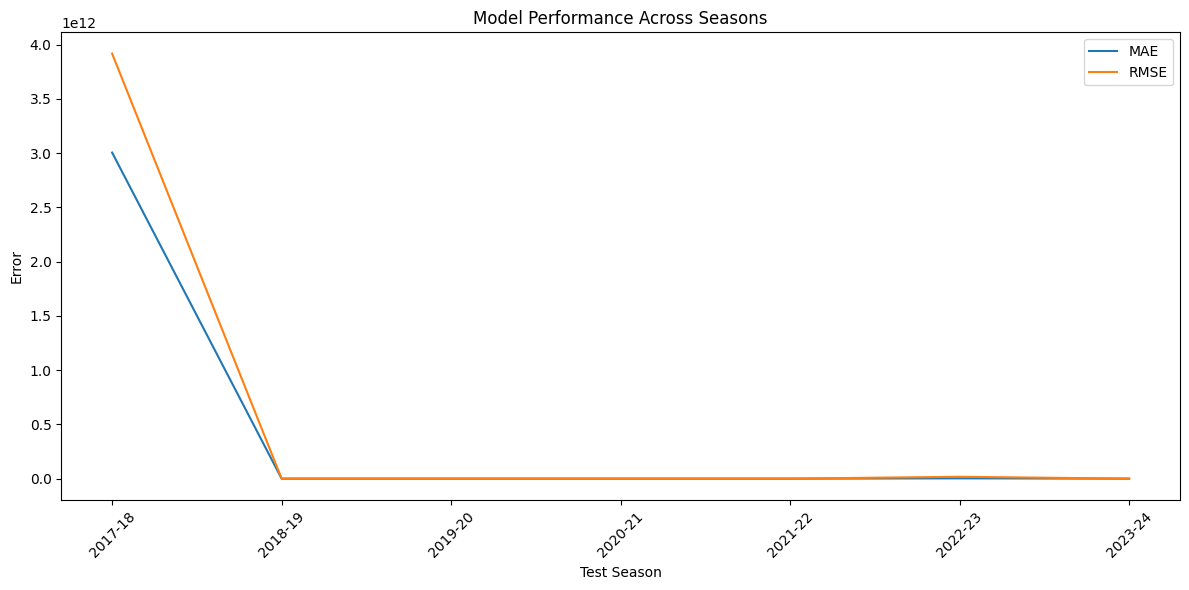


All Results:
  Test Season           MAE          RMSE
0     2017-18  3.005483e+12  3.917887e+12
1     2018-19  1.269672e+01  1.609954e+01
2     2019-20  1.285628e+01  1.642164e+01
3     2020-21  1.354972e+01  1.682183e+01
4     2021-22  1.363345e+01  1.709586e+01
5     2022-23  2.783543e+09  1.731770e+10
6     2023-24  1.366372e+01  1.743702e+01


In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def create_position_features(df):
    """Create binary features for each position."""
    df['IS_G'] = (df['SIMPLIFIED_POSITION'] == 'G').astype(int)
    df['IS_F'] = (df['SIMPLIFIED_POSITION'] == 'F').astype(int)
    df['IS_C'] = (df['SIMPLIFIED_POSITION'] == 'C').astype(int)
    return df

def predict_player_points(player_data, model, preprocessor, feature_names):
    """Predict points for a single player."""
    X = player_data[feature_names]
    X_transformed = preprocessor.transform(X)
    return model.predict(X_transformed)[0]

def project_team_score(team_data, opponent_data, model, preprocessor, feature_names):
    """Project score for a team given all players' data."""
    total_points = 0
    total_minutes = 0
    
    for _, player in team_data.iterrows():
        # Prepare player data for prediction
        player_data = player.to_frame().T
        
        # Add opponent team stats to player data
        for col in opponent_data.columns:
            if col.endswith('_opp'):
                player_data[col] = opponent_data[col].values[0]
        
        # Predict points for the player
        predicted_points = predict_player_points(player_data, model, preprocessor, feature_names)
        
        # Use MIN_EWA as estimated minutes
        estimated_minutes = player['MIN_EWA']
        
        # Add to total points and minutes
        total_points += predicted_points * (estimated_minutes / 48)  # Scale by estimated playing time
        total_minutes += estimated_minutes
    
    # Adjust for team-level factors (example: home court advantage)
    is_home = 1 if team_data['TEAM_ABBREVIATION'].values[0] == team_data['MATCHUP'].values[0][:3] else 0
    home_court_advantage = 2.5 if is_home else 0  # Assuming 2.5 points advantage for home team
    
    # Scale total points to account for 240 total team minutes per game
    scaled_total_points = (total_points / total_minutes) * 240 if total_minutes > 0 else 0
    
    return scaled_total_points + home_court_advantage

def predict_matchup(home_team_data, away_team_data, model, preprocessor, feature_names):
    """Predict the point differential for a matchup."""
    home_score = project_team_score(home_team_data, away_team_data, model, preprocessor, feature_names)
    away_score = project_team_score(away_team_data, home_team_data, model, preprocessor, feature_names)
    
    point_differential = home_score - away_score
    
    return {
        'home_score': home_score,
        'away_score': away_score,
        'point_differential': point_differential
    }

def backtest_projection_system(df, seasons, numeric_features):
    results = []
    
    # Create position features
    df = create_position_features(df)
    position_features = ['IS_G', 'IS_F', 'IS_C']
    all_features = numeric_features + position_features
    
    for i in range(1, len(seasons)):
        train_seasons = seasons[:i]
        test_season = seasons[i]
        
        print(f"\nTraining on seasons: {', '.join(train_seasons)}")
        print(f"Testing on season: {test_season}")
        
        # Split data
        train_data = df[df['SEASON'].isin(train_seasons)]
        test_data = df[df['SEASON'] == test_season]
        
        # Prepare features and target
        X_train = train_data[all_features]
        y_train = train_data['PTS']
        
        # Create and fit preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), all_features)
            ])
        
        # Fit preprocessor
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        
        # Create and train the model
        model = LinearRegression()
        model.fit(X_train_preprocessed, y_train)
        
        # Backtest on the test season
        actual_differentials = []
        predicted_differentials = []
        
        for game_date in test_data['GAME_DATE'].unique():
            games_on_date = test_data[test_data['GAME_DATE'] == game_date]
            for matchup in games_on_date['MATCHUP'].unique():
                home_team = matchup[:3]
                away_team = matchup[-3:]
                
                home_team_data = games_on_date[games_on_date['TEAM_ABBREVIATION'] == home_team]
                away_team_data = games_on_date[games_on_date['TEAM_ABBREVIATION'] == away_team]
                
                result = predict_matchup(home_team_data, away_team_data, model, preprocessor, all_features)
                
                actual_differential = home_team_data['PTS'].sum() - away_team_data['PTS'].sum()
                
                actual_differentials.append(actual_differential)
                predicted_differentials.append(result['point_differential'])
        
        mae = mean_absolute_error(actual_differentials, predicted_differentials)
        rmse = np.sqrt(mean_squared_error(actual_differentials, predicted_differentials))
        
        results.append({
            'Test Season': test_season,
            'MAE': mae,
            'RMSE': rmse
        })
        
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
    
    return pd.DataFrame(results)

# Assuming we have our final_df with all necessary columns
seasons = sorted(final_df['SEASON'].unique())

# Define features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
numeric_features = ['AGE', 'HEIGHT_INCHES', 'WEIGHT_LBS'] + ewa_columns

# Run backtesting
results_df = backtest_projection_system(final_df, seasons, numeric_features)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(results_df['Test Season'], results_df['MAE'], label='MAE')
plt.plot(results_df['Test Season'], results_df['RMSE'], label='RMSE')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Across Seasons')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nAll Results:")
print(results_df)

In [120]:
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
numeric_features = ['AGE', 'HEIGHT_INCHES', 'WEIGHT_LBS'] + ewa_columns
categorical_features = ['SIMPLIFIED_POSITION']

categorical_features

['SIMPLIFIED_POSITION']

In [99]:
df.groupby('PLAYER_ID')['PTS'].var().mean()

df[['GAME_ID', 'GAME_DATE', 'PLAYER_ID', 'PLAYER_NAME', 'PTS']]

,GAME_ID,GAME_DATE,PLAYER_ID,PLAYER_NAME,PTS
53887,0021600009,2016-10-26T00:00:00,1713,Vince Carter,3
53465,0021600028,2016-10-29T00:00:00,1713,Vince Carter,5
53364,0021600039,2016-10-30T00:00:00,1713,Vince Carter,18
53004,0021600052,2016-11-01T00:00:00,1713,Vince Carter,5
52820,0021600060,2016-11-02T00:00:00,1713,Vince Carter,0
...,...,...,...,...,...
217864,0022301137,2024-04-07T00:00:00,1642013,Malik Williams,0
217557,0022301146,2024-04-09T00:00:00,1642013,Malik Williams,6
217412,0022301160,2024-04-10T00:00:00,1642013,Malik Williams,7
216877,0022301176,2024-04-12T00:00:00,1642013,Malik Williams,0


In [98]:
def initialize_kalman_filter(
    initial_points: float = 10.0,
    initial_velocity: float = 0.0,
    initial_point_variance: float = 100.0,
    initial_velocity_variance: float = 10.0,
    measurement_noise: float = 25.0,
    process_noise_points: float = 0.1,
    process_noise_velocity: float = 0.01
) -> KalmanFilter:
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([initial_points, initial_velocity])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P = np.array([[initial_point_variance, 0.], 
                     [0., initial_velocity_variance]])
    kf.R = measurement_noise
    kf.Q = np.array([[process_noise_points, 0.], 
                     [0., process_noise_velocity]])
    return kf

def predict_next_game_points(df: pd.DataFrame, **kf_params) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    player_filters: Dict[int, KalmanFilter] = {}
    predictions = []

    for player_id, player_df in df.groupby('PLAYER_ID'):
        kf = initialize_kalman_filter(**kf_params)
        
        for _, row in player_df.iterrows():
            points = row['PTS']
            game_date = row['GAME_DATE']
            
            kf.predict()
            predicted_points = kf.x[0]
            
            predictions.append({
                'PLAYER_ID': player_id,
                'GAME_DATE': game_date,
                'PREDICTED_POINTS': predicted_points,
            })
            
            kf.update(points)

    return pd.DataFrame(predictions)

def evaluate_hyperparameters(df, **kf_params):
    results = predict_next_game_points(df, **kf_params)
    df_with_pred = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                            on=['PLAYER_ID', 'GAME_DATE'], 
                            how='left')
    
    mae = mean_absolute_error(df_with_pred['PTS'], df_with_pred['PREDICTED_POINTS'])
    mse = mean_squared_error(df_with_pred['PTS'], df_with_pred['PREDICTED_POINTS'])
    
    return mae, mse

# Example usage:
best_mae = float('inf')
best_mse = float('inf')
best_params = {}

for measurement_noise in np.linspace(50, 70, 3):
    for process_noise_points in np.linspace(4, 7, 3):
        params = {
            'initial_points': 10.42,
            'measurement_noise': measurement_noise,
            'process_noise_points': process_noise_points
        }
        mae, mse = evaluate_hyperparameters(df, **params)
        print(f"Parameters: {params}")
        print(f"MAE: {mae}, MSE: {mse}")
        if mae < best_mae:
            best_mae = mae
            best_params['mae'] = params
        if mse < best_mse:
            best_mse = mse
            best_params['mse'] = params

print(f"Best parameters by MAE: {best_params['mae']}")
print(f"Best MAE: {best_mae}")
print(f"Best parameters by MSE: {best_params['mse']}")
print(f"Best MSE: {best_mse}")

# Use the best parameters to make your final predictions
results = predict_next_game_points(df, **best_params['mae'])  # or use best_params['mse']
df_with_predictions = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                               on=['PLAYER_ID', 'GAME_DATE'], 
                               how='left')

Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 4.0}
MAE: 4.7157362200804664, MSE: 38.38324762964129
Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 5.5}
MAE: 4.735784427753418, MSE: 38.757906204022106
Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 7.0}
MAE: 4.755611826558533, MSE: 39.12169449318859
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 4.0}
MAE: 4.69953019152101, MSE: 38.08511481012438
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 5.5}
MAE: 4.716449771121761, MSE: 38.4059908543244
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 7.0}
MAE: 4.733507006315729, MSE: 38.72269342274886
Parameters: {'initial_points': 10.42, 'measurement_noise': 70.0, 'process_noise_points': 4.0}
MAE: 4.687471383768961, MSE: 37.85978485574526
Parameters: {

In [96]:
def calculate_process_noise(df: pd.DataFrame, use_log: bool = False) -> float:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    if use_log:
        df['PTS'] = np.log1p(df['PTS'])
    
    # Calculate point differences between consecutive games for each player
    df['PTS_DIFF'] = df.groupby('PLAYER_ID')['PTS'].diff()
    
    # Calculate the variance of these differences
    variance_of_diffs = df['PTS_DIFF'].var()
    
    # Use a fraction of this variance as the process noise
    # The fraction can be adjusted based on your specific needs
    process_noise = variance_of_diffs * 0.1
    
    return process_noise

calculate_process_noise(df)

6.0074218217976

In [54]:
MAE: 4.666, MSE: 37.8702115549464


array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [60]:
def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    predictions = []
    for player_id, player_df in df.groupby('PLAYER_ID'):
        ewa = player_df['PTS'].ewm(span=span, adjust=False).mean().shift(1)
        
        for game_date, pred_points in zip(player_df['GAME_DATE'], ewa):
            predictions.append({
                'PLAYER_ID': player_id,
                'GAME_DATE': game_date,
                'PREDICTED_POINTS': pred_points
            })
    
    return pd.DataFrame(predictions)

def predict_ewa2(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS'].transform(lambda x: x.ewm(span=span, adjust=False).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]


start = time.time()
ewa_1 = predict_ewa(df, 20)
end = time.time()

print(f"Time taken: {end - start} seconds")


start = time.time()
ewa_2 = predict_ewa2(df, 20)
end = time.time()

print(f"Time taken: {end - start} seconds")

Time taken: 3.23978328704834 seconds
Time taken: 0.616981029510498 seconds


In [129]:
def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.ewm(span=span, adjust=False).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]

def predict_simple_average(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate simple moving average for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]

def evaluate_method(df: pd.DataFrame, predictions: pd.DataFrame) -> Dict[str, float]:
    df_with_pred = df.merge(predictions[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                            on=['PLAYER_ID', 'GAME_DATE'], 
                            how='left')
    
    # Remove first prediction for each player (it's NaN for EWA and Simple Average)
    df_with_pred = df_with_pred.dropna(subset=['PREDICTED_POINTS'])

     
    mae = mean_absolute_error(df_with_pred['PTS_player'], df_with_pred['PREDICTED_POINTS'])
    mse = mean_squared_error(df_with_pred['PTS_player'], df_with_pred['PREDICTED_POINTS'])
    rmse = np.sqrt(mse)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# # Kalman Filter evaluation
# # best_kf_params = {
#     'initial_points': 10,
#     'measurement_noise': 225,
#     'process_noise_points': 0.6
# }  # You may want to run the hyperparameter tuning again

# kf_predictions = predict_next_game_points(df, **best_kf_params)
# kf_metrics = evaluate_method(df, kf_predictions)

# print("Kalman Filter Performance:")
# print(f"MAE: {kf_metrics['MAE']:.2f}")
# print(f"MSE: {kf_metrics['MSE']:.2f}")
# print(f"RMSE: {kf_metrics['RMSE']:.2f}")

# EWA evaluation
ewa_spans = np.arange(10, 21, 1)
ewa_results = {}

for span in ewa_spans:
    ewa_predictions = predict_ewa(df, span)
    ewa_metrics = evaluate_method(df, ewa_predictions)
    ewa_results[span] = ewa_metrics

    print(f"\nEWA Performance (span={span}):")
    print(f"MAE: {ewa_metrics['MAE']:.2f}")
    print(f"MSE: {ewa_metrics['MSE']:.2f}")
    print(f"RMSE: {ewa_metrics['RMSE']:.2f}")

# # Simple Average evaluation
# sa_windows = np.arange(5, 51, 5)
# sa_results = {}

# for window in sa_windows:
#     sa_predictions = predict_simple_average(df, window)
#     sa_metrics = evaluate_method(df, sa_predictions)
#     sa_results[window] = sa_metrics

#     print(f"\nSimple Average Performance (window={window}):")
#     print(f"MAE: {sa_metrics['MAE']:.2f}")
#     print(f"MSE: {sa_metrics['MSE']:.2f}")
#     print(f"RMSE: {sa_metrics['RMSE']:.2f}")

# # Find best EWA and Simple Average
# best_ewa_span = min(ewa_results, key=lambda x: ewa_results[x]['MAE'])
# best_ewa_metrics = ewa_results[best_ewa_span]

# best_sa_window = min(sa_results, key=lambda x: sa_results[x]['MAE'])
# best_sa_metrics = sa_results[best_sa_window]

# print("\nBest methods comparison:")
# # print(f"Kalman Filter - MAE: {kf_metrics['MAE']:.2f}, MSE: {kf_metrics['MSE']:.2f}, RMSE: {kf_metrics['RMSE']:.2f}")
# print(f"Best EWA (span={best_ewa_span}) - MAE: {best_ewa_metrics['MAE']:.2f}, MSE: {best_ewa_metrics['MSE']:.2f}, RMSE: {best_ewa_metrics['RMSE']:.2f}")
# print(f"Best Simple Avg (window={best_sa_window}) - MAE: {best_sa_metrics['MAE']:.2f}, MSE: {best_sa_metrics['MSE']:.2f}, RMSE: {best_sa_metrics['RMSE']:.2f}")

# # Calculate improvements
# def calculate_improvement(baseline_metric, comparison_metric):
#     return (baseline_metric - comparison_metric) / baseline_metric * 100

# best_baseline = min(best_ewa_metrics, best_sa_metrics, key=lambda x: x['MAE'])
# if best_baseline == best_ewa_metrics:
#     baseline_name = f"EWA (span={best_ewa_span})"
# else:
#     baseline_name = f"Simple Average (window={best_sa_window})"

# # print(f"\nKalman Filter improvement over best baseline ({baseline_name}):")
# print(f"MAE improvement: {calculate_improvement(best_baseline['MAE'], kf_metrics['MAE']):.2f}%")
# print(f"MSE improvement: {calculate_improvement(best_baseline['MSE'], kf_metrics['MSE']):.2f}%")
# print(f"RMSE improvement: {calculate_improvement(best_baseline['RMSE'], kf_metrics['RMSE']):.2f}%")


EWA Performance (span=10):
MAE: 4.55
MSE: 35.60
RMSE: 5.97

EWA Performance (span=11):
MAE: 4.54
MSE: 35.47
RMSE: 5.96

EWA Performance (span=12):
MAE: 4.54
MSE: 35.37
RMSE: 5.95

EWA Performance (span=13):
MAE: 4.54
MSE: 35.30
RMSE: 5.94

EWA Performance (span=14):
MAE: 4.53
MSE: 35.26
RMSE: 5.94

EWA Performance (span=15):
MAE: 4.53
MSE: 35.23
RMSE: 5.94

EWA Performance (span=16):
MAE: 4.53
MSE: 35.22
RMSE: 5.93

EWA Performance (span=17):
MAE: 4.54
MSE: 35.21
RMSE: 5.93

EWA Performance (span=18):
MAE: 4.54
MSE: 35.22
RMSE: 5.93

EWA Performance (span=19):
MAE: 4.54
MSE: 35.23
RMSE: 5.94

EWA Performance (span=20):
MAE: 4.54
MSE: 35.25
RMSE: 5.94


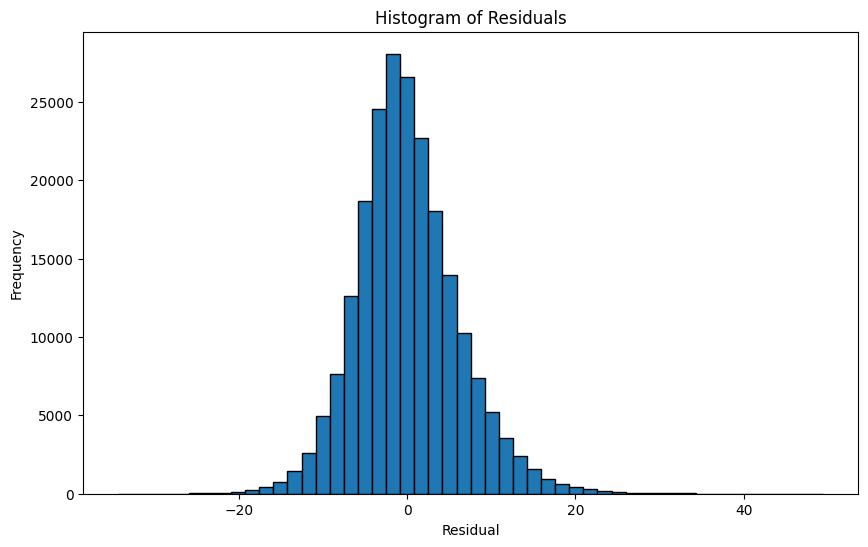

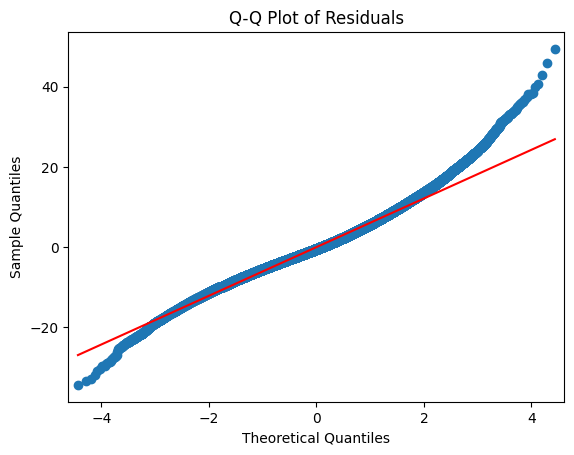

c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 216727.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test p-value: 5.23822498725882e-79
Skewness: 0.45026983417524513
Kurtosis: 1.278278806088121


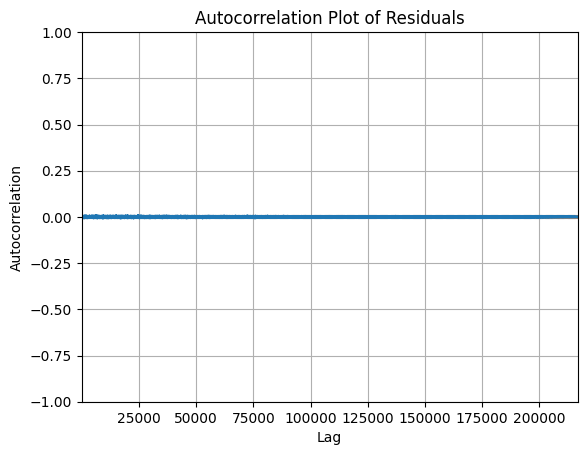

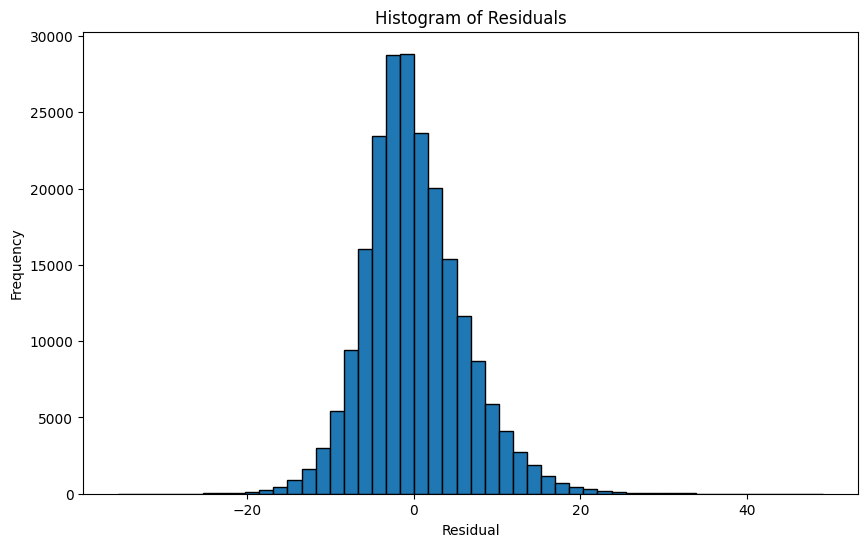

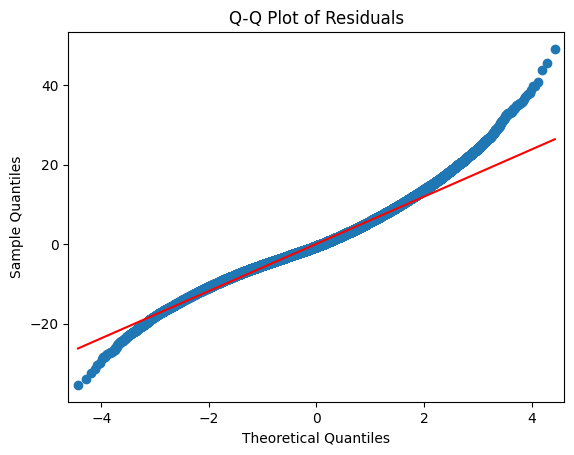

c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 215456.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test p-value: 1.6073302050919183e-84
Skewness: 0.5324904183726242
Kurtosis: 1.3735092405007512


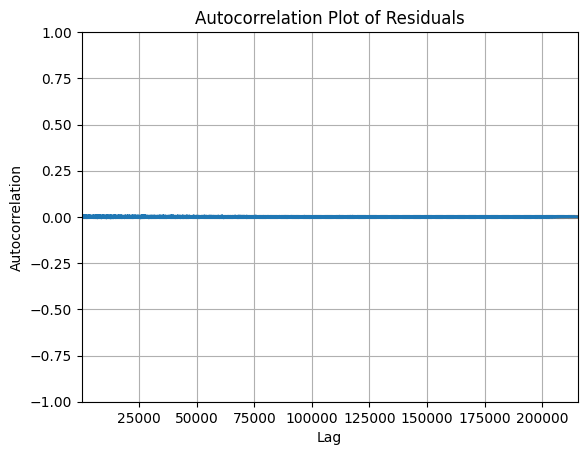

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

def analyze_scoring_noise(df: pd.DataFrame, predictions: pd.DataFrame):
    # Merge actual scores with predictions
    df_merged = df.merge(predictions[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                         on=['PLAYER_ID', 'GAME_DATE'], 
                         how='left')
    
    # Calculate residuals
    df_merged['RESIDUALS'] = df_merged['PTS'] - df_merged['PREDICTED_POINTS']
    
    # Remove NaN values
    df_merged = df_merged.dropna(subset=['RESIDUALS'])
    
    residuals = df_merged['RESIDUALS']
    
    # 1. Histogram of residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()
    
    # 2. Q-Q plot
    qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # 3. Shapiro-Wilk test
    _, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value: {p_value}")
    
    # 4. Skewness and Kurtosis
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals)
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    
    # # 5. Autocorrelation plot
    # pd.plotting.autocorrelation_plot(residuals)
    # plt.title('Autocorrelation Plot of Residuals')
    # plt.show()

# Assuming you have your dataframe 'df' and Kalman filter predictions 'kf_predictions'
analyze_scoring_noise(df, kf_predictions)

# For comparison, let's also analyze the EWA residuals
ewa_predictions = predict_ewa(df, best_ewa_span)  # Use your best EWA span
analyze_scoring_noise(df, ewa_predictions)

In [94]:
best_kf_params

{'initial_points': 10, 'measurement_noise': 225, 'process_noise_points': 0.6}

In [65]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    df = df.rename(columns={'SEASON_YEAR': 'SEASON'})

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    return df


clean_df = clean_team_data(df)
clean_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,240,45,94,0.479,13,35,0.371,14,19,0.737,11,40,51,31,12,5,15,22,117,29,2016-17,110.0,87.3,22.7,0.689,2.07,20.9,0.353,0.729,0.555,14.103,14.9,0.548,0.572,0.198,103.58,101,0.703,0.628,0.372,0.547,0.103,0.333,0.625,0.375,0.846,0.154,0.689,0.311,65.0,46.0,19.0,16.0,0.0,6.0,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,17.12,41.0,72.0,108.0,441.0,2.0,0.0,314.0,17.0,39.0,0.436,28.0,55.0,0.509,10.0,18.0,0.556,21.0,16.0,16.0,52.0,1
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,240,32,87,0.368,9,27,0.333,15,20,0.750,13,29,42,17,6,6,18,22,88,-29,2016-17,87.3,110.0,-22.7,0.531,0.94,13.0,0.271,0.647,0.445,17.857,17.8,0.420,0.459,0.202,103.58,101,0.297,0.690,0.310,0.523,0.205,0.307,0.391,0.609,0.889,0.111,0.531,0.469,65.0,39.0,26.0,9.0,2.0,7.0,15.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,17.29,34.0,71.0,104.0,408.0,1.0,1.0,287.0,12.0,31.0,0.387,20.0,56.0,0.357,21.0,31.0,0.677,14.0,16.0,9.0,28.0,0
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,240,39,75,0.520,13,19,0.684,22,22,1.000,5,29,34,22,5,3,13,18,113,9,2016-17,121.9,107.2,14.8,0.564,1.69,18.4,0.222,0.738,0.500,14.027,14.1,0.607,0.667,0.197,94.86,92,0.548,0.747,0.253,0.460,0.159,0.345,0.500,0.500,0.692,0.308,0.564,0.436,62.0,44.0,18.0,9.0,0.0,18.0,43.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,16.65,19.0,54.0,73.0,362.0,0.0,0.0,255.0,19.0,43.0,0.442,20.0,32.0,0.625,14.0,20.0,0.700,20.0,15.0,4.0,34.0,1
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,240,40,82,0.488,8,24,0.333,16,16,1.000,6,25,31,19,9,5,14,19,104,-9,2016-17,107.2,121.9,-14.8,0.475,1.36,15.6,0.262,0.778,0.500,14.427,15.4,0.537,0.584,0.190,94.86,91,0.452,0.707,0.293,0.615,0.135,0.231,0.344,0.656,1.000,0.000,0.475,0.525,54.0,44.0,10.0,16.0,0.0,10.0,20.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,16.76,19.0,47.0,66.0,425.0,2.0,1.0,310.0,22.0,44.0,0.500,18.0,38.0,0.474,11.0,18.0,0.611,8.0,4.0,8.0,50.0,0
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,240,40,85,0.471,7,33,0.212,13,18,0.722,8,27,35,24,11,6,16,19,100,-29,2016-17,99.1,125.9,-26.8,0.600,1.50,18.1,0.208,0.528,0.376,15.854,15.8,0.512,0.538,0.198,101.68,101,0.400,0.612,0.388,0.660,0.180,0.210,0.576,0.424,0.714,0.286,0.600,0.400,83.0,62.0,21.0,23.0,0.0,5.0,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,16.90,23.0,45.0,67.0,397.0,4.0,1.0,277.0,21.0,38.0,0.553,19.0,47.0,0.404,20.0,32.0,0.625,15.0,4.0,20.0,48.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23043,42023,1610612738,BOS,Boston Celtics,0042300403,2024-06-12,BOS @ DAL,1,240,38,82,0.463,17,46,0.370,13,14,0.929,6,30,36,26,4,6,9,19,106,7,2023-24,116.3,104.2,12.1,0.684,2.89,21.1,0.136,0.750,0.457,9.873,9.8,0.567,0.601,0.200,93.10,92,0.544

In [66]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
clean_df.isnull().sum()

SEASON_ID                         0
TEAM_ID                           0
TEAM_ABBREVIATION                 0
TEAM_NAME                         0
GAME_ID                           0
GAME_DATE                         0
MATCHUP                           0
WL                                0
MIN                               0
FGM                               0
FGA                               0
FG_PCT                            0
FG3M                              0
FG3A                              0
FG3_PCT                           0
FTM                               0
FTA                               0
FT_PCT                            1
OREB                              0
DREB                              0
REB                               0
AST                               0
STL                               0
BLK                               0
TOV                               0
PF                                0
PTS                               0
PLUS_MINUS                  

In [67]:
df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR',
       'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 'contestedShots',
       'contestedShots2pt', 'contestedShots3pt', 'deflections', 'chargesDrawn',
       'screenAssists', 'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensi

In [198]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    df = df.drop(columns = ['PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
                          'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'POSS',                       
                          'PCT_AST_2PM', 'PCT_UAST_2PM','PCT_AST_3PM',
                          'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM',
                          'FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV', 
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'E_USG_PCT',
                           'MIN', 'PIE', 'CFG_PCT', 'UFG_PCT',
                          'DFG_PCT'])
    
    ## Reorder Columns


    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,45,94,13,35,14,19,11,40,51,31,12,5,15,22,117,29,2016-17,110.0,87.3,22.7,103.58,65.0,46.0,19.0,16.0,0.0,6.0,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,17.12,41.0,72.0,108.0,441.0,2.0,0.0,314.0,17.0,39.0,28.0,55.0,10.0,18.0,21.0,16.0,16.0,52.0,1,32,59,12,20,10,12,2,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,32,87,9,27,15,20,13,29,42,17,6,6,18,22,88,-29,2016-17,87.3,110.0,-22.7,103.58,65.0,39.0,26.0,9.0,2.0,7.0,15.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,17.29,34.0,71.0,104.0,408.0,1.0,1.0,287.0,12.0,31.0,20.0,56.0,21.0,31.0,14.0,16.0,9.0,28.0,0,23,60,18,8,8,14,0,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,39,75,13,19,22,22,5,29,34,22,5,3,13,18,113,9,2016-17,121.9,107.2,14.8,94.86,62.0,44.0,18.0,9.0,0.0,18.0,43.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,16.65,19.0,54.0,73.0,362.0,0.0,0.0,255.0,19.0,43.0,20.0,32.0,14.0,20.0,20.0,15.0,4.0,34.0,1,26,56,17,13,8,13,4,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,40,82,8,24,16,16,6,25,31,19,9,5,14,19,104,-9,2016-17,107.2,121.9,-14.8,94.86,54.0,44.0,10.0,16.0,0.0,10.0,20.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,16.76,19.0,47.0,66.0,425.0,2.0,1.0,310.0,22.0,44.0,18.0,38.0,11.0,18.0,8.0,4.0,8.0,50.0,0,32,58,14,11,8,20,0,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,40,85,7,33,13,18,8,27,35,24,11,6,16,19,100,-29,2016-17,99.1,125.9,-26.8,101.68,83.0,62.0,21.0,23.0,0.0,5.0,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,16.90,23.0,45.0,67.0,397.0,4.0,1.0,277.0,21.0,38.0,19.0,47.0,20.0,32.0,15.0,4.0,20.0,48.0,1,33,52,18,19,4,13,2,-29,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23043,42023,1610612738,BOS,Boston Celtics,0042300403,2024-06-12,BOS @ DAL,1,38,82,17,46,13,14,6,30,36,26,4,6,9,19,106,7,2023-24,116.3,104.2,12.1,93.10,45.0,29.0,16.0,8.0,0.0,7.0,16.0,1.0,4.0,5.0,0.0,7.0,6.0,3.0,7.0,16.52,12.0,60.0,72.0,405.0,2.0,0.0,296.0,15.0,26.0,23.0,56.0,17.0,28.0,13.0,6.0,12.0,36.0,0,21,36,6,12,13,8,3,7,1,106
23044,42023,1610612742,DAL,Dallas Mavericks,0042300404,2024-06-14,DAL vs. BOS,1,46,91,15,37,15,22,13,39,52,21,7,2,9,17,122,38,2023-24,126.2,87.8,38.4,96.20,37.0,20.0,17.0,15.0,0.0,11.0,28.0,3.0,2.0,5.0,7.0,5.0,11.0,8.0,12.0,17.63,26.0,59.0,85.0,349.0,1.0,2.0,232.0,17.0,35.0,29.0,56.0,11.0,21.0,17.0,16.0,11.0,60.0,1,31,54,1,7,13,23,1,38,1,122
23045,42023,1610612738,BOS,Boston Celtics,0042300404,2024-06-14,BOS @ DAL,0,29,80,14,41,12,13,4,27,31,18,2,5,14,19,84,-38,2023-24,87.8,126.2,-38.4,96.20,44.0,24.0,20.0,11.0,0.0,6.0,17.0,1.0,2.0,3.0,2.0,3.0,5.0,3.0,5.0,17.26,18.0,55.0,71.0,404.0,6.0,2.0,290.0,11.0,27.0,18.0,53.0,20.0,29.0,9.0,2.0,6.0,26.0,0,15,39,4,7,9,7,4,-38,0,84
23046,42023,1610612742,DAL,Dallas Mavericks,0042300405,2024-06-17,DAL @ BOS,0,35,78,11,37,7,13,7,28,35,18,4,4,13,20,88,-18,2023-24,98.1,115.5,-17.4,90.76,43.0,17.0,26.0,13.0,0.0,11.0,26.0,3.0,1.0,4.0,2.0,6.0,8.0,4.0,8.0,16.67,14.0,56.0,70.0,315.0,1.0,0.0,207.0,13.0,22.0,22.0,56.0,16.0,30.

In [246]:
def find_high_correlations(df, threshold=0.7):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    correlation_matrix = numeric_df.corr()
    
    # Create a list to store highly correlated pairs
    high_correlations = []
    
    # Loop through the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                corr_value = correlation_matrix.iloc[i, j]
                high_correlations.append((col1, col2, corr_value))
    
    # Sort the list by absolute correlation value in descending order
    high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    return high_correlations

# Find highly correlated variables
high_corr_pairs = find_high_correlations(clean_df2, threshold=0.7)

# Print the results
print("Highly correlated variable pairs (correlation > 0.7):")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} and {col2}: {corr:.2f}")

Highly correlated variable pairs (correlation > 0.7):
REL_E_DEF_RATING_L10 and REL_E_OFF_RATING_opp_L10: 1.00
REL_PLUS_MINUS_L10 and REL_PLUS_MINUS_opp_L10: -1.00
REL_OREB_PCT_opp_L10 and REL_DREB_PCT_L10: -1.00
REL_E_NET_RATING_L10 and REL_E_NET_RATING_opp_L10: -1.00
REL_E_OFF_RATING_L10 and REL_E_DEF_RATING_opp_L10: 1.00
REL_E_PACE_opp_L10 and REL_E_PACE_L10: 1.00
REL_REB_PCT_L10 and REL_REB_PCT_opp_L10: -1.00
REL_OREB_PCT_L10 and REL_DREB_PCT_opp_L10: -1.00
REL_TOV_opp_L10 and REL_TOV_PCT_opp_L10: 0.99
REL_screenAssists_opp_L10 and REL_screenAssistPoints_opp_L10: 0.99
REL_PASS_L10 and REL_TCHS_L10: 0.99
REL_PLUS_MINUS_opp_L10 and REL_E_NET_RATING_opp_L10: 0.99
REL_PLUS_MINUS_L10 and REL_E_NET_RATING_opp_L10: -0.99
REL_E_NET_RATING_L10 and REL_PLUS_MINUS_opp_L10: -0.99
REL_E_NET_RATING_L10 and REL_PLUS_MINUS_L10: 0.99
REL_TOV_PCT_L10 and REL_TOV_L10: 0.98
REL_PASS_opp_L10 and REL_TCHS_opp_L10: 0.98
REL_screenAssists_L10 and REL_screenAssistPoints_L10: 0.98
REL_PTS_L10 and REL_E_DEF_R

In [247]:
high_corr_pairs

[('REL_E_DEF_RATING_L10', 'REL_E_OFF_RATING_opp_L10', 1.0),
 ('REL_PLUS_MINUS_L10', 'REL_PLUS_MINUS_opp_L10', -1.0),
 ('REL_OREB_PCT_opp_L10', 'REL_DREB_PCT_L10', -1.0),
 ('REL_E_NET_RATING_L10', 'REL_E_NET_RATING_opp_L10', -1.0),
 ('REL_E_OFF_RATING_L10', 'REL_E_DEF_RATING_opp_L10', 1.0),
 ('REL_E_PACE_opp_L10', 'REL_E_PACE_L10', 1.0),
 ('REL_REB_PCT_L10', 'REL_REB_PCT_opp_L10', -0.9999999999999998),
 ('REL_OREB_PCT_L10', 'REL_DREB_PCT_opp_L10', -0.9999999999999998),
 ('REL_TOV_opp_L10', 'REL_TOV_PCT_opp_L10', 0.9902291776746244),
 ('REL_screenAssists_opp_L10',
  'REL_screenAssistPoints_opp_L10',
  0.9890193015571056),
 ('REL_PASS_L10', 'REL_TCHS_L10', 0.9884518974321779),
 ('REL_PLUS_MINUS_opp_L10', 'REL_E_NET_RATING_opp_L10', 0.9854770826463026),
 ('REL_PLUS_MINUS_L10', 'REL_E_NET_RATING_opp_L10', -0.9854770826463026),
 ('REL_E_NET_RATING_L10', 'REL_PLUS_MINUS_opp_L10', -0.9854770826463026),
 ('REL_E_NET_RATING_L10', 'REL_PLUS_MINUS_L10', 0.9854770826463026),
 ('REL_TOV_PCT_L10', 'R

In [200]:
def normalize_per_100_poss(df):
    df = df.copy(deep=True)
    
    stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'contestedShots',
       'contestedShots2pt', 'contestedShots3pt', 'deflections', 'chargesDrawn',
       'screenAssists', 'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensiveBoxOuts', 'boxOutPlayerTeamRebounds',
       'boxOutPlayerRebounds', 'boxOuts', 'DIST', 'ORBC', 'DRBC', 'RBC',
       'TCHS', 'SAST', 'FTAST', 'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM',
       'DFGA', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT',
        'FG2M', 'FG2A', 'PTS_2PT_MR', 'AST_2PM', 'AST_3PM',
       'UAST_2PM', 'UAST_3PM']
    
    df[stats] = 100*df[stats].div(df['E_PACE'], axis=0) 
    
    return df
 
normalized_df = normalize_per_100_poss(clean_df2)
normalized_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,83.595594,6.884343,32.454760,12.785208,17.702596,7.867821,26.553895,34.421715,23.603462,10.818253,5.900865,15.735641,18.686074,98.347758,-28.520850,2016-17,99.1,125.9,-26.8,101.68,81.628639,60.975610,20.653029,22.619984,0.000000,4.917388,10.818253,0.000000,0.000000,7.867821,0.000000,0.000000,0.000000,0.000000,0.000000,16.620771,22.619984,44.256491,65.892998,390.440598,3.933910,0.983478,272.423289,20.653029,37.372148,18.686074,46.223446,19.669552,31.471282,14.752164,3.933910,19.669552,47.206924,1,32.454760,51.140834,17.702596,18.686074,3.933910,12.

In [98]:
normalized_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'SEASON', 'E_PACE', 'contestedShots', 'contestedShots2pt',
       'contestedShots3pt', 'deflections', 'chargesDrawn', 'screenAssists',
       'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensiveBoxOuts', 'boxOutPlayerTeamRebounds',
       'boxOutPlayerRebounds', 'boxOuts', 'DIST', 'ORBC', 'DRBC', 'RBC',
       'TCHS', 'SAST', 'FTAST', 'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM',
       'DFGA', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT',
       'HOME_GAME', 'FG2M', 'FG2A', 'PTS_2PT_MR', 'AST_2PM', 'AST_3PM',
       'UAST_2PM', 'UAST_3PM', 'POINT_DIFF', 'RECORD', 'TEAM_SCORE'],
      dtype='object')

## Add Betting Data

In [201]:
def load_betting_data(conn):
    betting_data = pd.read_sql("SELECT * FROM nba_odds", conn)
    betting_data = betting_data[['season', 'date', 'status', 'home_team_abbr', 'away_team_abbr', 'home_spread_draftkings',
                                'home_spread_odds_draftkings',
                                'away_spread_draftkings',
                                'away_spread_odds_draftkings',
                                'home_ml_draftkings',
                                'away_ml_draftkings',
                                'total_draftkings',
                                'over_odds_draftkings',
                                'under_odds_draftkings']]
    return betting_data


connection = sqlite3.connect("nba_stats.db")
betting_data = load_betting_data(connection)
betting_data

connection.close()

In [202]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))          

In [203]:
normalized_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,83.595594,6.884343,32.454760,12.785208,17.702596,7.867821,26.553895,34.421715,23.603462,10.818253,5.900865,15.735641,18.686074,98.347758,-28.520850,2016-17,99.1,125.9,-26.8,101.68,81.628639,60.975610,20.653029,22.619984,0.000000,4.917388,10.818253,0.000000,0.000000,7.867821,0.000000,0.000000,0.000000,0.000000,0.000000,16.620771,22.619984,44.256491,65.892998,390.440598,3.933910,0.983478,272.423289,20.653029,37.372148,18.686074,46.223446,19.669552,31.471282,14.752164,3.933910,19.669552,47.206924,1,32.454760,51.140834,17.702596,18.686074,3.933910,12.

In [204]:
def clean_betting_data(df):
    abbr_mapping = {'BK':'BKN',
                    'GS':'GSW',
                    'NO':'NOP',
                    'NY':'NYK',
                    'PHO':'PHX',
                    'SA':'SAS'
                    }

    df['home_team_abbr'] = df['home_team_abbr'].replace(abbr_mapping)
    df['away_team_abbr'] = df['away_team_abbr'].replace(abbr_mapping)

    df['date'] = pd.to_datetime(df['date']).dt.date
    df['GAME_DATE'] = df['date'] - pd.Timedelta(days=1)

    df['home_spread_odds_draftkings'] = convert_american_to_decimal(df['home_spread_odds_draftkings'])
    df['away_spread_odds_draftkings'] = convert_american_to_decimal(df['away_spread_odds_draftkings'])

    df['home_ml_draftkings'] = convert_american_to_decimal(df['home_ml_draftkings'])
    df['away_ml_draftkings'] = convert_american_to_decimal(df['away_ml_draftkings'])
    
    df['over_odds_draftkings'] = convert_american_to_decimal(df['over_odds_draftkings'])
    df['under_odds_draftkings'] = convert_american_to_decimal(df['under_odds_draftkings'])

    return df

In [205]:
clean_betting_df = clean_betting_data(betting_data)

In [206]:
clean_betting_df.head()

,season,date,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,GAME_DATE
0,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
1,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
2,2019-20,2020-10-10,Final,LAL,MIA,-7.0,1.892857,7.0,1.925926,1.298507,3.700000,215.5,1.892857,1.917431,2020-10-09
3,2019-20,2020-10-07,Final,MIA,LAL,7.5,1.909091,-7.5,1.909091,3.750000,1.298507,218.5,1.884956,1.925926,2020-10-06
4,2019-20,2020-10-04,Final,MIA,LAL,9.5,1.909091,-9.5,1.909091,4.500000,1.219780,219.5,1.884956,1.925926,2020-10-03


In [207]:
normalized_df['GAME_DATE'] = pd.to_datetime(normalized_df['GAME_DATE'])

betting_data['season'].unique()

array(['2019-20', '2020-21', '2021-22', '2022-23', '2023-24'],
      dtype=object)

In [208]:
clean_betting_df[['season', 'date', 'GAME_DATE', 'home_team_abbr', 'away_team_abbr']]

,season,date,GAME_DATE,home_team_abbr,away_team_abbr
0,2019-20,2020-10-11,2020-10-10,MIA,LAL
1,2019-20,2020-10-11,2020-10-10,MIA,LAL
2,2019-20,2020-10-10,2020-10-09,LAL,MIA
3,2019-20,2020-10-07,2020-10-06,MIA,LAL
4,2019-20,2020-10-04,2020-10-03,MIA,LAL
...,...,...,...,...,...
6456,2023-24,2024-06-07,2024-06-06,BOS,DAL
6457,2023-24,2024-06-10,2024-06-09,BOS,DAL
6458,2023-24,2024-06-13,2024-06-12,DAL,BOS
6459,2023-24,2024-06-15,2024-06-14,DAL,BOS


In [209]:
# Create copy of input DataFrames to avoid modifying originals
clean_boxscores = normalized_df.copy()
clean_betting_df = clean_betting_df.copy()

# Ensure date columns are in the same format
clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if 'vs' in x else x[-3:])
clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if '@' in x else x[-3:])


merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                        left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                        right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])


merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                    else row['away_ml_draftkings'], axis=1)

merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_odds_draftkings'], axis=1)


merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_draftkings'], axis=1)


merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)


In [210]:
def merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores):
    
    # Create copy of input DataFrames to avoid modifying originals
    clean_boxscores = clean_boxscores.copy()
    clean_betting_df = clean_betting_df.copy()

    # Ensure date columns are in the same format
    clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
    clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])


    merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                            left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                            right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                      else row['away_ml_draftkings'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_odds_draftkings'], axis=1)
    
    
    merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_draftkings'], axis=1)
    

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores=normalized_df)

merged_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,season,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,ML,SPREAD,SPREAD_ODDS,ATS_DIFF,TEAM_COVERED
0,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,

In [211]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    
    
    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'SEASON_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_NAME_opp',
                                       'TEAM_ID_opp', 'WL_opp']
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(normalized_df)
matchups.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,E_PACE_opp,contestedShots_opp,contestedShots2pt_opp,contestedShots3pt_opp,deflections_opp,chargesDrawn_opp,screenAssists_opp,screenAssistPoints_opp,looseBallsRecoveredOffensive_opp,looseBallsRecoveredDefensive_opp,looseBallsRecoveredTotal_opp,offensiveBoxOuts_opp,defensiveBoxOuts_opp,boxOutPlayerTeamRebounds_opp,boxOutPlayerRebounds_opp,boxOuts_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp
1,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
5,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406

In [212]:
def build_team_avg_stats_df(df: pd.DataFrame, span: int = 10) -> pd.DataFrame:
    """
    Calculate the average statistics for each team up to (but not including) the given date.
    
    Args:
    df (pd.DataFrame): Input DataFrame containing team statistics.
    span (int): Number of games to consider for the exponential weighted moving average. Default is 10.
    
    Returns:
    pd.DataFrame: DataFrame with average team statistics.
    """
    df = df.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)

    # Define columns to drop and keep
    drop_cols = ['SEASON_ID', 'SEASON', 'TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'GAME_DATE', 'POINT_DIFF', 'WL', 
                 'TEAM_SCORE_opp', 'POINT_DIFF_opp', 'RECORD', 'RECORD_opp']
    
    keep_cols = ['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'RECORD', 'POINT_DIFF', 'WL']

    # Select stats columns
    stats = df.drop(columns=drop_cols)
    stats_cols = stats.columns[1:]  # Exclude 'TEAM_ABBREVIATION'

    # Calculate exponential weighted moving average for each stat
    avg_stats = stats.groupby('TEAM_ABBREVIATION')[stats_cols].transform(
        lambda x: x.ewm(span=span).mean()
    )

    # Add matchup info and calculate win percentage
    result = df[keep_cols].copy()
    result = pd.concat([result, avg_stats], axis=1)
    result[f'WIN_PCT_L{span}'] = result.groupby('TEAM_ABBREVIATION')['RECORD'].transform(
        lambda x: x.rolling(window=span).mean()
    )
    result = result.drop(columns='RECORD')

    # Shift stats to avoid look-ahead bias
    shift_cols = [col for col in result.columns if col not in keep_cols + [f'WIN_PCT_L{span}']]
    result[shift_cols] = result.groupby('TEAM_ABBREVIATION')[shift_cols].shift(1)

    # Rename columns
    result = result.add_suffix(f'_L{span}')
    rename_dict = {f'{col}_L{span}': col for col in keep_cols}
    result = result.rename(columns=rename_dict)

    return result

# Usage

start = time.time()
team_stats_ewa = build_team_avg_stats_df(matchups, span=10)
end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.5773587226867676 seconds


In [266]:
def add_percentage_features(df, span):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df[f'FG2_PCT_L{span}'] = df[f'FG2M_L{span}'] / df[f'FG2A_L{span}']
    df[f'FG3_PCT_L{span}'] = df[f'FG3M_L{span}'] / df[f'FG3A_L{span}']
    
    df['OREB_PCT_L{}'.format(span)] = df['OREB_L{}'.format(span)] / (df['OREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)])
    df['OREB_PCT_opp_L{}'.format(span)] = df['OREB_opp_L{}'.format(span)] / (df['OREB_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)])

    df['DREB_PCT_L{}'.format(span)] = df['DREB_L{}'.format(span)] / (df['DREB_L{}'.format(span)] + df['OREB_opp_L{}'.format(span)])
    df['DREB_PCT_opp_L{}'.format(span)] = df['DREB_opp_L{}'.format(span)] / (df['DREB_opp_L{}'.format(span)] + df['OREB_L{}'.format(span)])

    df['REB_PCT_L{}'.format(span)] = df['REB_L{}'.format(span)] / (df['REB_L{}'.format(span)] + df['REB_opp_L{}'.format(span)])
    df['REB_PCT_opp_L{}'.format(span)] = df['REB_opp_L{}'.format(span)] / (df['REB_opp_L{}'.format(span)] + df['REB_L{}'.format(span)])

    df['TS_PCT_L{}'.format(span)] = df['PTS_L{}'.format(span)] / ((2*(df['FG2A_L{}'.format(span)] + df['FG3A_L{}'.format(span)]) + 0.44*df['FTA_L{}'.format(span)]))
    
    df['TS_PCT_opp_L{}'.format(span)] = df['PTS_opp_L{}'.format(span)] / ((2*(df['FG2A_opp_L{}'.format(span)] + df['FG3A_opp_L{}'.format(span)]) + 0.44*df['FTA_opp_L{}'.format(span)]))

    df['EFG_PCT_L{}'.format(span)] = (df['FG2M_L{}'.format(span)] + 1.5*df['FG3M_L{}'.format(span)]) / (df['FG2A_L{}'.format(span)]
                                                                    + df['FG3A_L{}'.format(span)])
    df['EFG_PCT_opp_L{}'.format(span)] = (df['FG2M_opp_L{}'.format(span)] + 1.5*df['FG3M_opp_L{}'.format(span)]) / (df['FG2A_opp_L{}'.format(span)] 
                                                                 + df['FG3A_opp_L{}'.format(span)])

    df['AST_RATIO_L{}'.format(span)] = (df['AST_L{}'.format(span)] * 100) / df['E_PACE_L{}'.format(span)]
    df['AST_RATIO_opp_L{}'.format(span)] = (df['AST_opp_L{}'.format(span)] * 100) / df['E_PACE_opp_L{}'.format(span)]

    df['TOV_PCT_L{}'.format(span)] = 100*df['TOV_L{}'.format(span)] / (df['FG2A_L{}'.format(span)] 
                                               + df['FG3A_L{}'.format(span)] 
                                               + 0.44*df['FTA_L{}'.format(span)] 
                                               + df['TOV_L{}'.format(span)])
    
    df['TOV_PCT_opp_L{}'.format(span)] = 100*df['TOV_opp_L{}'.format(span)] / (df['FG2A_opp_L{}'.format(span)] 
                                             + df['FG3A_opp_L{}'.format(span)] 
                                             + 0.44*df['FTA_opp_L{}'.format(span)] 
                                             + df['TOV_opp_L{}'.format(span)])
    
    
    df['PIE_L{}'.format(span)] = ((df['PTS_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG3M_L{}'.format(span)] + df['FTM_L{}'.format(span)] 
                 - df['FG2A_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FTA_L{}'.format(span)] 
                 + df['DREB_L{}'.format(span)] + df['OREB_L{}'.format(span)]/2
                + df['AST_L{}'.format(span)] + df['STL_L{}'.format(span)] + df['BLK_L{}'.format(span)]/2
                - df['PF_L{}'.format(span)] - df['TOV_L{}'.format(span)]) 
                 / (df['PTS_L{}'.format(span)] + df['PTS_opp_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG2M_opp_L{}'.format(span)]
                   + df['FG3M_L{}'.format(span)] + df['FG3M_opp_L{}'.format(span)] + df['FTM_L{}'.format(span)] + df['FTM_opp_L{}'.format(span)]
                   - df['FG2A_L{}'.format(span)] - df['FG2A_opp_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FG3A_opp_L{}'.format(span)] 
                    - df['FTA_L{}'.format(span)] - df['FTA_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)]
                    + (df['OREB_L{}'.format(span)]+df['OREB_opp_L{}'.format(span)])/2 + df['AST_L{}'.format(span)] + df['AST_opp_L{}'.format(span)]
                    + df['STL_L{}'.format(span)] + df['STL_opp_L{}'.format(span)] + (df['BLK_L{}'.format(span)] + df['BLK_opp_L{}'.format(span)])/2
                    - df['PF_L{}'.format(span)] - df['PF_opp_L{}'.format(span)] - df['TOV_L{}'.format(span)] - df['TOV_opp_L{}'.format(span)]))
        
    return df
  
  
  
team_stats_ewa = add_percentage_features(team_stats_ewa, span=10)

In [267]:
def add_rest_days(df: pd.DataFrame, max_rest_days: int = 7) -> pd.DataFrame:
    """
    Calculate the number of rest days between games for each team.

    Args:
    df (pd.DataFrame): Input DataFrame containing game data.
    max_rest_days (int): Maximum number of rest days to consider. Default is 8.

    Returns:
    pd.DataFrame: DataFrame with an additional 'REST' column indicating the number of rest days.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Ensure 'GAME_DATE' is in datetime format
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Calculate rest days
    df['REST'] = df.groupby(['SEASON', 'TEAM_ABBREVIATION'])['GAME_DATE'].diff().dt.days

    # Cap rest days at the specified maximum
    df['REST'] = df['REST'].clip(upper=max_rest_days)

    # Fill NaN values (first game of the season) with max_rest_days
    df['REST'] = df['REST'].fillna(max_rest_days)

    return df


team_stats_ewa = add_rest_days(team_stats_ewa)

In [268]:
team_stats_ewa

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,FGM_L10,FGA_L10,FG3M_L10,FG3A_L10,FTM_L10,FTA_L10,OREB_L10,DREB_L10,REB_L10,AST_L10,STL_L10,BLK_L10,TOV_L10,PF_L10,PTS_L10,PLUS_MINUS_L10,E_OFF_RATING_L10,E_DEF_RATING_L10,E_NET_RATING_L10,E_PACE_L10,contestedShots_L10,contestedShots2pt_L10,contestedShots3pt_L10,deflections_L10,chargesDrawn_L10,screenAssists_L10,screenAssistPoints_L10,looseBallsRecoveredOffensive_L10,looseBallsRecoveredDefensive_L10,looseBallsRecoveredTotal_L10,offensiveBoxOuts_L10,defensiveBoxOuts_L10,boxOutPlayerTeamRebounds_L10,boxOutPlayerRebounds_L10,boxOuts_L10,DIST_L10,ORBC_L10,DRBC_L10,RBC_L10,TCHS_L10,SAST_L10,FTAST_L10,PASS_L10,CFGM_L10,CFGA_L10,UFGM_L10,UFGA_L10,DFGM_L10,DFGA_L10,PTS_OFF_TOV_L10,PTS_2ND_CHANCE_L10,PTS_FB_L10,PTS_PAINT_L10,FG2M_L10,FG2A_L10,PTS_2PT_MR_L10,AST_2PM_L10,AST_3PM_L10,UAST_2PM_L10,UAST_3PM_L10,FGM_opp_L10,FGA_opp_L10,FG3M_opp_L10,FG3A_opp_L10,FTM_opp_L10,FTA_opp_L10,OREB_opp_L10,DREB_opp_L10,REB_opp_L10,AST_opp_L10,STL_opp_L10,BLK_opp_L10,TOV_opp_L10,PF_opp_L10,PTS_opp_L10,PLUS_MINUS_opp_L10,E_OFF_RATING_opp_L10,E_DEF_RATING_opp_L10,E_NET_RATING_opp_L10,E_PACE_opp_L10,contestedShots_opp_L10,contestedShots2pt_opp_L10,contestedShots3pt_opp_L10,deflections_opp_L10,chargesDrawn_opp_L10,screenAssists_opp_L10,screenAssistPoints_opp_L10,looseBallsRecoveredOffensive_opp_L10,looseBallsRecoveredDefensive_opp_L10,looseBallsRecoveredTotal_opp_L10,offensiveBoxOuts_opp_L10,defensiveBoxOuts_opp_L10,boxOutPlayerTeamRebounds_opp_L10,boxOutPlayerRebounds_opp_L10,boxOuts_opp_L10,DIST_opp_L10,ORBC_opp_L10,DRBC_opp_L10,RBC_opp_L10,TCHS_opp_L10,SAST_opp_L10,FTAST_opp_L10,PASS_opp_L10,CFGM_opp_L10,CFGA_opp_L10,UFGM_opp_L10,UFGA_opp_L10,DFGM_opp_L10,DFGA_opp_L10,PTS_OFF_TOV_opp_L10,PTS_2ND_CHANCE_opp_L10,PTS_FB_opp_L10,PTS_PAINT_opp_L10,FG2M_opp_L10,FG2A_opp_L10,PTS_2PT_MR_opp_L10,AST_2PM_opp_L10,AST_3PM_opp_L10,UAST_2PM_opp_L10,UAST_3PM_opp_L10,WIN_PCT_L10_L10,OREB_PCT_L10,OREB_PCT_opp_L10,DREB_PCT_L10,DREB_PCT_opp_L10,REB_PCT_L10,REB_PCT_opp_L10,TS_PCT_L10,TS_PCT_opp_L10,EFG_PCT_L10,EFG_PCT_opp_L10,AST_RATIO_L10,AST_RATIO_opp_L10,TOV_PCT_L10,TOV_PCT_opp_L10,PIE_L10,REST,FG2_PCT_L10,FG3_PCT_L10
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,1,114,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
1,2016-17,ATL,2016-10-29,0021600026,ATL @ PHI,0,104,32,1,41.540785,83.081571,11.329305,24.546828,13.217523,16.993958,13.217523,35.876133,49.093656,26.435045,12.273414,6.608761,19.826284,17.938066,107.628399,14.161631,110.800000,90.900000,19.900000,105.920000,67.975831,50.981873,16.993958,19.826284,0.000000,6.608761,14.161631,0.000000,0.000000,5.664653,0.000000,0.000000,0.000000,0.000000,0.000000,16.399169,25.490937,66.087613,90.634441,407.854985,2.832326,0.944109,283.232628,19.826284,41.540785,21.714502,41.540785,11.329305,20.770393,24.546828,18.882175,15.105740,41.540785,30.211480,58.534743,17.938066,15.105740,11.329305,15.105740,0.000000,37.764350,88.746224,5.664653,18.882175,12.273414,16.993958,11.329305,26.435045,37.764350,23.602719,13.217523,3.776435,17.938066,18.882175,93.466767,-14.161631,90.900000,110.800000,-19.900000,105.920000,50.037764,33.043807,16.993958,23.602719,0.000000,7.552870,16.049849,0.000000,0.000000,4.720544,0.000000,0.000000,0.000000,0.000000,0.000000,16.276435,36.820242,44.373112,77.416918,402.190332,4.720544,0.000000,279.456193,19.826284,41.540785,17.938066,47.205438,14.161631,21.714502,23.602719,5.664653,16.993958,45.317221,32.099698,69.864

In [269]:
def make_matchups_2(df):
    
    home_teams = df.loc[df['HOME_GAME'] == 1]
    home_teams = home_teams.add_prefix('HOME_')

    away_teams = df.loc[df['HOME_GAME'] == 0]
    away_teams = away_teams.add_prefix('AWAY_')

    drop_cols = ['AWAY_SEASON', 'AWAY_GAME_DATE',
                            'AWAY_MATCHUP', 'AWAY_HOME_GAME', 'AWAY_POINT_DIFF', 'AWAY_WL',
                            # 'AWAY_ATS_DIFF', 'AWAY_SPREAD', 'AWAY_TEAM_COVERED'
                            ]
    
    away_teams = away_teams.drop(columns=drop_cols)

    full_matchup_ewa = pd.merge(home_teams, away_teams, how = 'inner',
                                left_on = 'HOME_GAME_ID', right_on = 'AWAY_GAME_ID') 
    
    full_matchup_ewa = full_matchup_ewa.rename(columns = {'HOME_SEASON':'SEASON',
                                                          'HOME_GAME_DATE':'GAME_DATE',
                                                          'HOME_GAME_ID':'GAME_ID',
                                                          'HOME_MATCHUP':'MATCHUP'})
    
    full_matchup_ewa = full_matchup_ewa.drop(columns=['AWAY_GAME_ID'])
    
    return full_matchup_ewa


start = time.time()
full_matchups_team_stats_ewa = make_matchups_2(team_stats_ewa)
end = time.time()
print(f"Time taken: {end - start} seconds")


Time taken: 0.18192505836486816 seconds


In [270]:
cols = [x for x in full_matchups_team_stats_ewa.columns if 'RB' in x or 'Rebound' in x]

full_matchups_team_stats_ewa[cols]

full_matchups_team_stats_ewa

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_POINT_DIFF,HOME_WL,HOME_FGM_L10,HOME_FGA_L10,HOME_FG3M_L10,HOME_FG3A_L10,HOME_FTM_L10,HOME_FTA_L10,HOME_OREB_L10,HOME_DREB_L10,HOME_REB_L10,HOME_AST_L10,HOME_STL_L10,HOME_BLK_L10,HOME_TOV_L10,HOME_PF_L10,HOME_PTS_L10,HOME_PLUS_MINUS_L10,HOME_E_OFF_RATING_L10,HOME_E_DEF_RATING_L10,HOME_E_NET_RATING_L10,HOME_E_PACE_L10,HOME_contestedShots_L10,HOME_contestedShots2pt_L10,HOME_contestedShots3pt_L10,HOME_deflections_L10,HOME_chargesDrawn_L10,HOME_screenAssists_L10,HOME_screenAssistPoints_L10,HOME_looseBallsRecoveredOffensive_L10,HOME_looseBallsRecoveredDefensive_L10,HOME_looseBallsRecoveredTotal_L10,HOME_offensiveBoxOuts_L10,HOME_defensiveBoxOuts_L10,HOME_boxOutPlayerTeamRebounds_L10,HOME_boxOutPlayerRebounds_L10,HOME_boxOuts_L10,HOME_DIST_L10,HOME_ORBC_L10,HOME_DRBC_L10,HOME_RBC_L10,HOME_TCHS_L10,HOME_SAST_L10,HOME_FTAST_L10,HOME_PASS_L10,HOME_CFGM_L10,HOME_CFGA_L10,HOME_UFGM_L10,HOME_UFGA_L10,HOME_DFGM_L10,HOME_DFGA_L10,HOME_PTS_OFF_TOV_L10,HOME_PTS_2ND_CHANCE_L10,HOME_PTS_FB_L10,HOME_PTS_PAINT_L10,HOME_FG2M_L10,HOME_FG2A_L10,HOME_PTS_2PT_MR_L10,HOME_AST_2PM_L10,HOME_AST_3PM_L10,HOME_UAST_2PM_L10,HOME_UAST_3PM_L10,HOME_FGM_opp_L10,HOME_FGA_opp_L10,HOME_FG3M_opp_L10,HOME_FG3A_opp_L10,HOME_FTM_opp_L10,HOME_FTA_opp_L10,HOME_OREB_opp_L10,HOME_DREB_opp_L10,HOME_REB_opp_L10,HOME_AST_opp_L10,HOME_STL_opp_L10,HOME_BLK_opp_L10,HOME_TOV_opp_L10,HOME_PF_opp_L10,HOME_PTS_opp_L10,HOME_PLUS_MINUS_opp_L10,HOME_E_OFF_RATING_opp_L10,HOME_E_DEF_RATING_opp_L10,HOME_E_NET_RATING_opp_L10,HOME_E_PACE_opp_L10,HOME_contestedShots_opp_L10,HOME_contestedShots2pt_opp_L10,HOME_contestedShots3pt_opp_L10,HOME_deflections_opp_L10,HOME_chargesDrawn_opp_L10,HOME_screenAssists_opp_L10,HOME_screenAssistPoints_opp_L10,HOME_looseBallsRecoveredOffensive_opp_L10,HOME_looseBallsRecoveredDefensive_opp_L10,HOME_looseBallsRecoveredTotal_opp_L10,HOME_offensiveBoxOuts_opp_L10,...,AWAY_TCHS_L10,AWAY_SAST_L10,AWAY_FTAST_L10,AWAY_PASS_L10,AWAY_CFGM_L10,AWAY_CFGA_L10,AWAY_UFGM_L10,AWAY_UFGA_L10,AWAY_DFGM_L10,AWAY_DFGA_L10,AWAY_PTS_OFF_TOV_L10,AWAY_PTS_2ND_CHANCE_L10,AWAY_PTS_FB_L10,AWAY_PTS_PAINT_L10,AWAY_FG2M_L10,AWAY_FG2A_L10,AWAY_PTS_2PT_MR_L10,AWAY_AST_2PM_L10,AWAY_AST_3PM_L10,AWAY_UAST_2PM_L10,AWAY_UAST_3PM_L10,AWAY_FGM_opp_L10,AWAY_FGA_opp_L10,AWAY_FG3M_opp_L10,AWAY_FG3A_opp_L10,AWAY_FTM_opp_L10,AWAY_FTA_opp_L10,AWAY_OREB_opp_L10,AWAY_DREB_opp_L10,AWAY_REB_opp_L10,AWAY_AST_opp_L10,AWAY_STL_opp_L10,AWAY_BLK_opp_L10,AWAY_TOV_opp_L10,AWAY_PF_opp_L10,AWAY_PTS_opp_L10,AWAY_PLUS_MINUS_opp_L10,AWAY_E_OFF_RATING_opp_L10,AWAY_E_DEF_RATING_opp_L10,AWAY_E_NET_RATING_opp_L10,AWAY_E_PACE_opp_L10,AWAY_contestedShots_opp_L10,AWAY_contestedShots2pt_opp_L10,AWAY_contestedShots3pt_opp_L10,AWAY_deflections_opp_L10,AWAY_chargesDrawn_opp_L10,AWAY_screenAssists_opp_L10,AWAY_screenAssistPoints_opp_L10,AWAY_looseBallsRecoveredOffensive_opp_L10,AWAY_looseBallsRecoveredDefensive_opp_L10,AWAY_looseBallsRecoveredTotal_opp_L10,AWAY_offensiveBoxOuts_opp_L10,AWAY_defensiveBoxOuts_opp_L10,AWAY_boxOutPlayerTeamRebounds_opp_L10,AWAY_boxOutPlayerRebounds_opp_L10,AWAY_boxOuts_opp_L10,AWAY_DIST_opp_L10,AWAY_ORBC_opp_L10,AWAY_DRBC_opp_L10,AWAY_RBC_opp_L10,AWAY_TCHS_opp_L10,AWAY_SAST_opp_L10,AWAY_FTAST_opp_L10,AWAY_PASS_opp_L10,AWAY_CFGM_opp_L10,AWAY_CFGA_opp_L10,AWAY_UFGM_opp_L10,AWAY_UFGA_opp_L10,AWAY_DFGM_opp_L10,AWAY_DFGA_opp_L10,AWAY_PTS_OFF_TOV_opp_L10,AWAY_PTS_2ND_CHANCE_opp_L10,AWAY_PTS_FB_opp_L10,AWAY_PTS_PAINT_opp_L10,AWAY_FG2M_opp_L10,AWAY_FG2A_opp_L10,AWAY_PTS_2PT_MR_opp_L10,AWAY_AST_2PM_opp_L10,AWAY_AST_3PM_opp_L10,AWAY_UAST_2PM_opp_L10,AWAY_UAST_3PM_opp_L10,AWAY_WIN_PCT_L10_L10,AWAY_OREB_PCT_L10,AWAY_OREB_PCT_opp_L10,AWAY_DREB_PCT_L10,AWAY_DREB_PCT_opp_L10,AWAY_REB_PCT_L10,AWAY_REB_PCT_opp_L10,AWAY_TS_PCT_L10,AWAY_TS_PCT_opp_L10,AWAY_EFG_PCT_L10,AWAY_EFG_PCT_opp_L10,AWAY_AST_RATIO_L10,AWAY_AST_RATIO_opp_L10,AWAY_TOV_PCT_L10,AWAY_TOV_PCT_opp_L10,AWAY_PIE_L10,AWAY_REST,AWAY_FG2_PCT_L10,AWAY_FG3_PCT_L10
0,201

In [272]:
full_matchups_team_stats_ewa[['HOME_FG2M_L10' ,'HOME_FG2A_L10', 'HOME_FG2_PCT_L10']]

,HOME_FG2M_L10,HOME_FG2A_L10,HOME_FG2_PCT_L10
0,NaN,NaN,NaN
1,33.573568,61.437827,0.546464
2,29.287646,57.254366,0.511536
3,28.131515,55.147263,0.510116
4,29.982604,55.722928,0.538066
...,...,...,...
10203,28.611159,53.632790,0.533464
10204,28.479060,52.622632,0.541194
10205,29.837559,52.515619,0.568165
10206,28.906407,51.122845,0.565430


In [252]:
def engineer_features(df, keep_original=False):
    
    df = df.copy()
    # List of features to create relative metrics for
    relative_features = [col[5:] for col in df.columns if col.startswith('HOME_') and col.endswith('_L10')]
    relative_features = list(set(relative_features) - set(['HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL']))

    # Create relative metrics
    for feature in relative_features:
        df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']


    # Matchup-specific metrics
    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OREB_OPPORTUNITY_RATIO'] = df['HOME_ORBC_L10'] / df['AWAY_DRBC_L10']
    df['AWAY_OREB_OPPORTUNITY_RATIO'] = df['AWAY_ORBC_L10'] / df['HOME_DRBC_L10']
    # Rest advantage
    df['REST_ADVANTAGE'] = df['HOME_REST'] - df['AWAY_REST']

    df['HOME_2ND_CHANCE_EFFICIENCY'] = df['HOME_PTS_2ND_CHANCE_L10'] / df['HOME_ORBC_L10']
    df['AWAY_2ND_CHANCE_EFFICIENCY'] = df['AWAY_PTS_2ND_CHANCE_L10'] / df['AWAY_ORBC_L10']
    

    # Creating interaction terms
    interaction_features = ['E_OFF_RATING_L10', 'E_DEF_RATING_L10', 'TS_PCT_L10', 'EFG_PCT_L10', 'AST_RATIO_L10', 'TOV_PCT_L10', 'REB_PCT_L10']
    for feature in interaction_features:
        df[f'HOME_{feature}_INTERACTION'] = df[f'HOME_{feature}'] * df[f'HOME_{feature}_opp'] if f'HOME_{feature}_opp' in df.columns else df[f'HOME_{feature}']
        df[f'AWAY_{feature}_INTERACTION'] = df[f'AWAY_{feature}'] * df[f'AWAY_{feature}_opp'] if f'AWAY_{feature}_opp' in df.columns else df[f'AWAY_{feature}']


    df['HOME_ORBC_TS_INTERACTION'] = df['HOME_ORBC_L10'] * df['HOME_TS_PCT_L10']
    df['AWAY_ORBC_TS_INTERACTION'] = df['AWAY_ORBC_L10'] * df['AWAY_TS_PCT_L10']
    df['HOME_DRBC_OPP_TS_INTERACTION'] = df['HOME_DRBC_L10'] * df['AWAY_TS_PCT_L10']
    df['AWAY_DRBC_OPP_TS_INTERACTION'] = df['AWAY_DRBC_L10'] * df['HOME_TS_PCT_L10']
    

    teams = ['HOME', 'AWAY']
    for team in teams:
        # Rebounding Efficiency Ratios
        df[f'{team}_OREB_EFFICIENCY'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_EFFICIENCY'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        df[f'{team}_OVERALL_REB_EFFICIENCY'] = (df[f'{team}_OREB_L10'] + df[f'{team}_DREB_L10']) / df[f'{team}_RBC_L10']
        
        # Box Out Effectiveness
        df[f'{team}_BOX_OUT_TO_CHANCE_RATIO'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']
        
        # Rebounding Opportunity Ratios
        df[f'{team}_OREB_CHANCE_RATIO'] = df[f'{team}_ORBC_L10'] / df[f'{team}_RBC_L10']
        df[f'{team}_DREB_CHANCE_RATIO'] = df[f'{team}_DRBC_L10'] / df[f'{team}_RBC_L10']
        
        # Rebounding Conversion Rates
        df[f'{team}_OREB_CONVERSION_RATE'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_CONVERSION_RATE'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        
        # Rebounding Chance Differentials
        df[f'{team}_NET_REB_CHANCES'] = df[f'{team}_RBC_L10'] - df[f'{team}_RBC_opp_L10']
        df[f'{team}_NET_OREB_CHANCES'] = df[f'{team}_ORBC_L10'] - df[f'{team}_ORBC_opp_L10']
        df[f'{team}_NET_DREB_CHANCES'] = df[f'{team}_DRBC_L10'] - df[f'{team}_DRBC_opp_L10']
        
        # Box Out Impact
        df[f'{team}_BOX_OUT_EFFECTIVENESS'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']

    
    # df = pd.get_dummies(df, columns=['HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'])

    if not keep_original:
        columns_to_drop = [col for col in df.columns if col.startswith('HOME_') or col.startswith('AWAY_')]
        columns_to_keep = [col for col in df.columns if col.startswith('HOME_TEAM_ABBREVIATION') or col.startswith('AWAY_TEAM_ABBREVIATION')]
        columns_to_keep += ['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF', 'HOME_WL']
        columns_to_drop = list(set(columns_to_drop) - set(columns_to_keep))
        df = df.drop(columns=columns_to_drop)

    high_corr_pairs = find_high_correlations(df, threshold=0.7)
    # Dropping highly correlated features
    drop_cols = [pair[0] for pair in high_corr_pairs]
    df = df.drop(columns=drop_cols)


    return df


final_df = engineer_features(full_matchups_team_stats_ewa)

final_df

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_TEAM_SCORE,HOME_POINT_DIFF,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_SCORE,REL_FG3A_opp_L10,REL_chargesDrawn_opp_L10,REL_boxOuts_L10,REL_UFGA_L10,REL_E_NET_RATING_opp_L10,REL_FGA_opp_L10,REL_BLK_L10,REL_SAST_L10,REL_DFGA_L10,REL_chargesDrawn_L10,REL_PTS_OFF_TOV_opp_L10,REL_screenAssistPoints_opp_L10,REL_DIST_opp_L10,REL_deflections_L10,REL_contestedShots2pt_L10,REL_PTS_2ND_CHANCE_opp_L10,REL_defensiveBoxOuts_opp_L10,REL_FTM_L10,REL_OREB_L10,REL_DREB_opp_L10,REL_looseBallsRecoveredDefensive_L10,REL_RBC_opp_L10,REL_FGA_L10,REL_DREB_PCT_L10,REL_FTM_opp_L10,REL_PTS_FB_opp_L10,REL_DREB_L10,REL_AST_2PM_opp_L10,REL_FTAST_L10,REL_boxOutPlayerRebounds_opp_L10,REL_REB_PCT_opp_L10,REL_CFGM_opp_L10,REL_AST_RATIO_L10,REL_FG2A_L10,REL_looseBallsRecoveredTotal_opp_L10,REL_TCHS_L10,REL_offensiveBoxOuts_L10,REL_boxOutPlayerRebounds_L10,REL_CFGA_L10,REL_STL_opp_L10,REL_screenAssistPoints_L10,REL_PTS_FB_L10,REL_UFGA_opp_L10,REL_DFGM_opp_L10,REL_looseBallsRecoveredDefensive_opp_L10,REL_UAST_3PM_L10,REL_UFGM_opp_L10,REL_PTS_2PT_MR_opp_L10,REL_BLK_opp_L10,REL_SAST_opp_L10,REL_FTAST_opp_L10,REL_RBC_L10,REL_looseBallsRecoveredOffensive_L10,REL_TCHS_opp_L10,REL_contestedShots_opp_L10,REL_PTS_2PT_MR_L10,REL_looseBallsRecoveredTotal_L10,REL_E_PACE_L10,REL_deflections_opp_L10,REL_UAST_2PM_L10,REL_UAST_2PM_opp_L10,REL_looseBallsRecoveredOffensive_opp_L10,REL_offensiveBoxOuts_opp_L10,REL_UAST_3PM_opp_L10,REST_ADVANTAGE
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,114,15,WAS,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2016-17,ATL,2016-10-31,0021600044,ATL vs. SAC,106,11,SAC,95,-1.780474,-0.620167,0.000000,3.376627,-29.814751,4.847807,3.265719,1.646565,-0.896251,-1.049177,-4.940094,1.652732,0.081117,-2.081138,8.250117,-2.513122,0.000000,-10.367962,-0.307124,-0.790764,0.000000,0.605462,-0.697911,0.075434,-11.169586,-1.750502,9.486928,-2.112868,0.572165,0.000000,-0.068597,-4.322066,2.081470,1.212844,-2.611514,-43.053833,0.000000,0.000000,-3.028184,3.134148,0.908426,2.291008,5.037057,3.303282,0.000000,-0.697584,-1.311872,-10.554726,-1.336251,0.300082,-2.599149,25.618207,0.000000,6.265011,-5.617332,3.589799,-2.380645,8.071120,-3.638333,-0.166244,-3.301722,0.000000,0.000000,-0.045225,0.0
2,2016-17,ATL,2016-11-02,0021600059,ATL vs. LAL,116,-7,LAL,123,-5.194633,-0.876078,0.000000,5.970468,-29.405831,-0.930461,3.149246,3.287987,-7.824669,0.741598,-7.542655,9.908386,0.890622,5.116328,6.556475,-9.578658,0.000000,2.352849,2.115681,0.614113,0.000000,1.588706,-0.410920,0.093486,-7.898142,-2.883476,4.125041,0.455743,0.717625,0.000000,-0.055084,-3.237382,11.302087,1.737153,-0.185618,31.147942,0.000000,0.000000,-6.074575,1.260857,0.036600,1.750752,0.760707,1.492548,0.000000,-1.157980,-0.820218,3.035786,-0.551054,0.920564,-0.387363,14.819947,0.000000,33.742595,-1.528691,2.122882,-1.236450,-4.464489,4.310560,-6.573553,-4.250359,0.000000,0.000000,-0.069463,1.0
3,2016-17,ATL,2016-11-05,0021600084,ATL vs. HOU,112,15,HOU,97,-8.402451,-1.454740,0.000000,-6.188182,-2.553562,-4.232303,0.383559,1.129985,0.231970,-0.273526,0.978371,6.152328,-0.112854,3.999616,0.755642,-3.472423,0.000000,2.618497,-0.798768,1.922307,0.000000,1.221270,-3.507336,0.022042,-2.377639,2.600380,0.431006,4.177477,1.319899,0.000000,0.007531,1.553974,0.392413,7.059091,-0.922550,32.643642,0.000000,0.000000,2.680846,1.091430,-6.214719,-0.991221,-7.961212,-1.661152,0.000000,-2.972049,-4.348432,4.543245,1.729237,-0.324071,-0.543885,-1.038928,0.000000,-41.483863,-4.355578,6.168762,-1.954104,3.501102,-0.457724,-1.299462,-2.716511,0.000000,0.000000,-1.032943,-2.0
4,2016-17,ATL,2016-11-09,0021600111,ATL vs. CHI,115,8,CHI,107,0.782766,-0.954468,0.000000,1.907101,-2.681690,-4.767225,-0.796662,1.032031,-1.623559,0.640678,1.282853,0.694900,-0.982443,3.3

In [279]:
full_matchups_team_stats_ewa[[x for x in full_matchups_team_stats_ewa.columns if 'WIN_PCT' in x]]

full_matchups_team_stats_ewa[['HOME_PTS_L10', 'HOME_E_OFF_RATING_L10']]

print(full_matchups_team_stats_ewa.shape)
high_corr_pairs = find_high_correlations(full_matchups_team_stats_ewa, threshold=0.7)
# Dropping highly correlated features
drop_cols = [pair[0] for pair in high_corr_pairs]
final_df = full_matchups_team_stats_ewa.drop(columns=drop_cols)


print(final_df.shape)

(10208, 289)
(10208, 127)


In [280]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1)  # n_jobs=-1 uses all available cores
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return model, mse, mae, r2


def season_to_string(s):
    return str(s) + "-" + str(s+1)[-2:]

def time_series_cv(df, start_season=2016, end_season=2023):
    results = []
    
    for test_season in range(start_season + 2, end_season + 1):
        
        print(f"Training on seasons {start_season}-{test_season-1}, testing on season {test_season}")
        
        # Split data
        train_data = df[df['SEASON'] < season_to_string(test_season)]
        test_data = df[df['SEASON'] == season_to_string(test_season)]
        
        # Prepare features and target
        features = [col for col in df.columns if col not in ['SEASON', 'GAME_DATE', 'GAME_ID', 'HOME_WL', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF'
                                                             , 'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'
                                                             ]]
        X_train = train_data[features].astype(float)
        y_train_home = train_data['HOME_TEAM_SCORE']
        y_train_away = train_data['AWAY_TEAM_SCORE']
        
        X_test = test_data[features].astype(float)
        y_test_home = test_data['HOME_TEAM_SCORE']
        y_test_away = test_data['AWAY_TEAM_SCORE']
        
        # Train and evaluate home score model
        home_model, home_mse, home_mae, home_r2 = train_and_evaluate_model(X_train, y_train_home, X_test, y_test_home)
        
        # Train and evaluate away score model
        away_model, away_mse, away_mae, away_r2 = train_and_evaluate_model(X_train, y_train_away, X_test, y_test_away)
        
        results.append({
            'Test Season': test_season,
            'Home MSE': home_mse,
            'Home MAE': home_mae,
            'Home R2': home_r2,
            'Away MSE': away_mse,
            'Away MAE': away_mae,
            'Away R2': away_r2
        })
        
        # Optionally, save feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance_home': home_model.feature_importances_,
            'importance_away': away_model.feature_importances_
        })
        feature_importance.to_csv(f'feature_importance_season_{test_season}.csv', index=False)
    
    return pd.DataFrame(results)

# Main execution
# df = pd.read_csv('your_data.csv')  # Load your data
# df = prepare_data(df)
# df = engineer_features(df)

results = time_series_cv(final_df)
print(results)

# Optionally, you can save the results
# results.to_csv('model_performance_by_season.csv', index=False)

Training on seasons 2016-2017, testing on season 2018
Training on seasons 2016-2018, testing on season 2019
Training on seasons 2016-2019, testing on season 2020
Training on seasons 2016-2020, testing on season 2021
Training on seasons 2016-2021, testing on season 2022
Training on seasons 2016-2022, testing on season 2023
   Test Season    Home MSE   Home MAE   Home R2    Away MSE   Away MAE  \
0         2018  188.655940  10.684888 -0.179263  197.187114  11.140750   
1         2019  180.804318  10.650202 -0.136876  172.649366  10.465782   
2         2020  183.521204  10.704563 -0.173522  177.000815  10.429149   
3         2021  162.563262  10.143618 -0.053239  167.877496  10.284065   
4         2022  169.407775  10.338518 -0.179088  163.421309  10.065522   
5         2023  164.931441  10.328378  0.006049  162.709375  10.158811   

    Away R2  
0 -0.258666  
1 -0.160861  
2 -0.122366  
3 -0.037349  
4 -0.135367  
5  0.024271  


In [277]:
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False).head(30)

,feature,importance_home,importance_away
17,HOME_E_OFF_RATING_L10,0.051820,0.011681
159,AWAY_E_PACE_L10,0.027823,0.018855
260,AWAY_WIN_PCT_L10_L10,0.019965,0.021255
121,HOME_WIN_PCT_L10_L10,0.018823,0.018782
20,HOME_E_PACE_L10,0.014518,0.019199
125,HOME_DREB_PCT_opp_L10,0.012451,0.000762
234,AWAY_boxOuts_opp_L10,0.008876,0.000000
90,HOME_looseBallsRecoveredTotal_opp_L10,0.007721,0.003149
18,HOME_E_DEF_RATING_L10,0.007453,0.027698
263,AWAY_DREB_PCT_L10,0.007043,0.008359


In [281]:
pd.options.display.max_rows = 200
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False)

,feature,importance_home,importance_away
74,AWAY_E_PACE_L10,0.053607,0.036188
73,AWAY_E_DEF_RATING_L10,0.032104,0.008495
14,HOME_E_PACE_L10,0.024326,0.036574
48,HOME_DRBC_opp_L10,0.019031,0.007658
24,HOME_TCHS_L10,0.017849,0.009797
86,AWAY_DFGM_L10,0.014097,0.007208
31,HOME_PTS_FB_L10,0.012316,0.006305
89,AWAY_PTS_PAINT_L10,0.011750,0.005770
96,AWAY_OREB_opp_L10,0.011572,0.008540
12,HOME_PLUS_MINUS_L10,0.011060,0.006430


In [ ]:
def create_interactions(df, features_to_interact):
    for i, feature1 in enumerate(features_to_interact):
        for feature2 in features_to_interact[i+1:]:
            df[f'{feature1}_{feature2}_interaction'] = df[feature1] * df[feature2]
    return df

def train_and_evaluate(X, y, interactions=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if interactions:
        X_train = create_interactions(X_train, interactions)
        X_test = create_interactions(X_test, interactions)
    
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return mse, feature_importance

# Assume df is your dataframe and 'target' is your target variable
# df = pd.read_csv('your_data.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# Train model without interactions
mse_without, importance_without = train_and_evaluate(X, y)

print("MSE without interactions:", mse_without)
print("\nTop 10 features without interactions:")
print(importance_without.head(10))

# Select top features for interactions
top_features = importance_without['feature'].head(5).tolist()

# Train model with interactions
mse_with, importance_with = train_and_evaluate(X, y, interactions=top_features)

print("\nMSE with interactions:", mse_with)
print("\nTop 10 features with interactions:")
print(importance_with.head(10))

print(f"\nMSE Improvement: {mse_without - mse_with}")